In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.losses import mean_absolute_percentage_error

Using TensorFlow backend.


In [2]:
from utils.generate_models import generate_models, generate_DeepConvLSTM_model
from utils.validate_models import find_best_architecture, evaluate_model
from utils.data_generator import DataGenerator
from utils.get_dataset_pulsi import get_dataset_pulsi

In [3]:
columns = np.array(['bpm', 'spo2'])
dataset_reduced_std, dataset_reduced = get_dataset_pulsi(columns,
                                                         filename='./utils/test_data/42nights.csv')

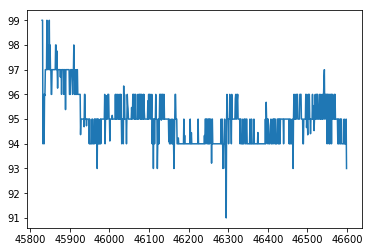

In [4]:
plt.plot(dataset_reduced[dataset_reduced["name"] == 'h_17-04-27']["spo2"])

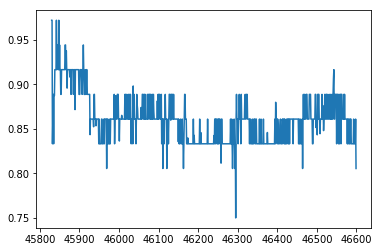

In [5]:
plt.plot(dataset_reduced_std[dataset_reduced_std["name"] == 'h_17-04-27']["spo2"])

In [6]:
window_size = 12            # ventana de valores para la prediccion
dim_length = window_size
number_of_predictions = 4   # numero de predicciones en la salida
output_dim = number_of_predictions
target_variable = "spo2"
dim_channels = 2            # 2 variables

In [7]:
#cv_fold_size = len(val_gen)*batch_size
batch_size = 32
metric = mean_absolute_percentage_error

In [8]:
train_names = np.array(['p_17-01-19', 'p_17-01-20'])
val_names = np.array(['p_17-01-21'])
test_names = np.array(['p_17-01-22'])
train_gen = DataGenerator(dataset_reduced_std, train_names,
                          "spo2", batch_size=batch_size,
                          number_of_predictions=number_of_predictions,
                          window_size=window_size,
                          step_prediction_dates=1, shuffle=False,
                          debug=False)
val_gen = DataGenerator(dataset_reduced_std, val_names,
                        "spo2", batch_size=batch_size,
                        number_of_predictions=number_of_predictions,
                        window_size=window_size,
                        step_prediction_dates=1, shuffle=False,
                        debug=False)
test_gen = DataGenerator(dataset_reduced_std, test_names,
                         "spo2", batch_size=batch_size,
                         number_of_predictions=number_of_predictions,
                         window_size=window_size,
                         step_prediction_dates=1, shuffle=False,
                         debug=False)

In [9]:
hyperparameters = {}
regularization_rate = 10 ** -4 # max bound
hyperparameters['regularization_rate'] = regularization_rate
learning_rate = 10 ** -4 # max bound
hyperparameters['learning_rate'] = learning_rate
filters = []
hyperparameters['filters'] = filters
lstm_dims = [50]
hyperparameters['lstm_dims'] = lstm_dims

In [10]:
model = generate_DeepConvLSTM_model(dim_length, dim_channels, output_dim,
                                    filters, lstm_dims, learning_rate,
                                    regularization_rate,
                                    dropout=None, dropout_rnn=0.75, dropout_cnn=0.75,
                                    metrics=[mean_absolute_percentage_error])

In [11]:
models = [(model, hyperparameters)]

In [12]:
np.random.seed(3)
nr_epochs=100
verbose=True
early_stopping=False

best_model_losses, best_params_losses, best_model_metrics, best_params_metrics, debug = \
    find_best_architecture(train_gen, val_gen, test_gen,
                           verbose=True, number_of_models=None, nr_epochs=nr_epochs,
                           early_stopping=True, batch_size=batch_size,
                           models=models, metric=mean_absolute_percentage_error, use_testset=True,
                           debug=False, test_retrain=False, output_all=True)

Training model 0
{'regularization_rate': 0.0001, 'learning_rate': 0.0001, 'filters': [], 'lstm_dims': [50]}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 12, 2)             8         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 50)            10600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 4)             204       
_________________________________________________________________
lambda_1 (Lambda)            (None, 4)                 0         
Total params: 10,812
Trainable params: 10,808
Non-trainable params: 4
_________________________________________________________________
Epoch 1/100
78/78 [===========

Epoch 38/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0628 - mean_absolute_percentage_error: 367010.9907 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.4439
Epoch 39/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0604 - mean_absolute_percentage_error: 345440.7377 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 9.0343
Epoch 40/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0620 - mean_absolute_percentage_error: 247483.9293 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 7.7845
Epoch 41/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0604 - mean_absolute_percentage_error: 317874.7157 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 7.6356
Epoch 42/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0569 - mean_absolute_percentage_error: 227717.4951 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.2534
Epoch 43/100
78/78 [====================

In [13]:
train_predict, val_predict, test_predict = \
    evaluate_model(train_gen, val_gen, test_gen,
                   best_model_losses)

training error = [0.019428088677810023, 303552.1880847007]
validation error = [0.008298669902820983, 7.2233756486833745]
testing error = [0.00893142217875043, 8.238088256043273]


In [14]:
# Train 250 models at random ==> layers: 1 LSTM 100 cells max + 0 CNN
models = generate_models(dim_length, dim_channels, output_dim,
                         number_of_models=250,
                         metrics=[mean_absolute_percentage_error],
                         deepconvlstm_min_conv_layers=0, deepconvlstm_max_conv_layers=0,
                         deepconvlstm_min_conv_filters=10, deepconvlstm_max_conv_filters=100,
                         deepconvlstm_min_lstm_layers=1, deepconvlstm_max_lstm_layers=1,
                         deepconvlstm_min_lstm_dims=10, deepconvlstm_max_lstm_dims=100,
                         low_lr=1, high_lr=4, low_reg=1, high_reg=4,
                         dropout_rnn_max=0.9, dropout_rnn_min=0.2,
                         dropout_cnn_max=0.9, dropout_cnn_min=0.2)

In [15]:
np.random.seed(3)
nr_epochs=500

best_model_losses, best_params_losses, \
best_model_metrics, best_params_metrics, \
debug_o = \
    find_best_architecture(train_gen, val_gen, test_gen,
                           verbose=True, number_of_models=None, nr_epochs=nr_epochs,
                           early_stopping=True, batch_size=batch_size,
                           models=models, metric=mean_absolute_percentage_error, use_testset=True,
                           debug=False, test_retrain=False, output_all=True)

Training model 0
{'learning_rate': 0.002257145150581335, 'regularization_rate': 0.0007152072379178071, 'filters': [], 'lstm_dims': [77], 'dropout': None, 'dropout_rnn': 0.8005619323359296, 'dropout_cnn': 0.7930762171488877}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 12, 2)             8         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 77)            24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 77)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 4)             312       
_________________________________________________________________
lambda_2 (Lambda)            (None, 4)                 0         
Total params: 24,960
Trainable params: 24,956
Non-

78/78 [==============================] - 2s 23ms/step - loss: 0.0049 - mean_absolute_percentage_error: 371845.8592 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 5.7034
Epoch 38/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0049 - mean_absolute_percentage_error: 359630.1556 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 6.7151
Epoch 39/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0048 - mean_absolute_percentage_error: 369855.5425 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.0472
Epoch 40/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0049 - mean_absolute_percentage_error: 359905.6141 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.0129
Epoch 41/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0049 - mean_absolute_percentage_error: 368366.4306 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.0696
Epoch 42/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.0050 - mean_absolute_percentage_error: 367038.8367 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.1929
Epoch 28/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0049 - mean_absolute_percentage_error: 368838.4299 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.1724
Epoch 29/500
78/78 [==============================] - 2s 19ms/step - loss: 0.0048 - mean_absolute_percentage_error: 373502.4617 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.6802
Epoch 30/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0048 - mean_absolute_percentage_error: 369879.2128 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7323
Epoch 31/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0049 - mean_absolute_percentage_error: 367751.0694 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.4851
Epoch 32/500
78/78 [==============================] -

78/78 [==============================] - 1s 19ms/step - loss: 0.0050 - mean_absolute_percentage_error: 362005.5743 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.2350
Epoch 31/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0049 - mean_absolute_percentage_error: 365362.2232 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.2165
Epoch 32/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363147.0240 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.4189
Epoch 33/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0048 - mean_absolute_percentage_error: 372753.7863 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.4779
Epoch 34/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0049 - mean_absolute_percentage_error: 368978.1499 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6341
Epoch 35/500
78/78 [==============================] -

78/78 [==============================] - 2s 22ms/step - loss: 0.0176 - mean_absolute_percentage_error: 348279.1531 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.1325
Epoch 8/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0149 - mean_absolute_percentage_error: 366398.6870 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 3.9921
Epoch 9/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0167 - mean_absolute_percentage_error: 368987.0148 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.4540
Epoch 10/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0143 - mean_absolute_percentage_error: 364827.7577 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 4.2855
Epoch 11/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0126 - mean_absolute_percentage_error: 381783.7708 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.1402
Epoch 12/500
78/78 [==============================] - 2

Epoch 50/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0048 - mean_absolute_percentage_error: 369594.2714 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.7774
Epoch 51/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0046 - mean_absolute_percentage_error: 368308.5905 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.0234
Epoch 52/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0045 - mean_absolute_percentage_error: 371267.8599 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.4688
Epoch 53/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0045 - mean_absolute_percentage_error: 372924.2377 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.8527
Epoch 54/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0044 - mean_absolute_percentage_error: 377115.9402 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.3537
Epoch 55/500
78/78 [====================

78/78 [==============================] - 2s 23ms/step - loss: 0.0237 - mean_absolute_percentage_error: 358253.9923 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 11.2468
Epoch 13/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0235 - mean_absolute_percentage_error: 362151.5600 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 10.1018
Epoch 14/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0223 - mean_absolute_percentage_error: 380794.9570 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 7.9478
Epoch 15/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0223 - mean_absolute_percentage_error: 409050.9891 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 8.2135
Epoch 16/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0224 - mean_absolute_percentage_error: 353566.8674 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 8.9997
Epoch 17/500
78/78 [==============================]

Epoch 55/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0143 - mean_absolute_percentage_error: 389379.7507 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 7.8317
Epoch 56/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0146 - mean_absolute_percentage_error: 380841.0967 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 9.6871
Epoch 57/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0145 - mean_absolute_percentage_error: 361481.5791 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 11.8267
Epoch 58/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0141 - mean_absolute_percentage_error: 364053.5626 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 6.9944
Epoch 59/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0139 - mean_absolute_percentage_error: 373839.1465 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 9.0669
Epoch 60/500
78/78 [===================

Epoch 98/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0113 - mean_absolute_percentage_error: 376777.9033 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 8.7940
Epoch 99/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0114 - mean_absolute_percentage_error: 361274.2681 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.6256
Epoch 100/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0115 - mean_absolute_percentage_error: 367133.1985 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 9.4610
Epoch 00100: early stopping
Training model 5
{'learning_rate': 0.040029619594569944, 'regularization_rate': 0.017891356073011, 'filters': [], 'lstm_dims': [97], 'dropout': None, 'dropout_rnn': 0.7225030297939083, 'dropout_cnn': 0.7583271747509472}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 12, 2) 

Epoch 1/500
78/78 [==============================] - 12s 158ms/step - loss: 0.9025 - mean_absolute_percentage_error: 77960.1244 - val_loss: 0.8308 - val_mean_absolute_percentage_error: 100.6975
Epoch 2/500
78/78 [==============================] - 2s 21ms/step - loss: 0.7966 - mean_absolute_percentage_error: 77746.7919 - val_loss: 0.7348 - val_mean_absolute_percentage_error: 94.3862
Epoch 3/500
78/78 [==============================] - 2s 20ms/step - loss: 0.6773 - mean_absolute_percentage_error: 142698.3147 - val_loss: 0.6243 - val_mean_absolute_percentage_error: 86.1151
Epoch 4/500
78/78 [==============================] - 1s 19ms/step - loss: 0.5279 - mean_absolute_percentage_error: 169307.5017 - val_loss: 0.4726 - val_mean_absolute_percentage_error: 72.4658
Epoch 5/500
78/78 [==============================] - 1s 19ms/step - loss: 0.3633 - mean_absolute_percentage_error: 251359.0581 - val_loss: 0.3070 - val_mean_absolute_percentage_error: 54.5535
Epoch 6/500
78/78 [====================

78/78 [==============================] - 1s 19ms/step - loss: 0.0627 - mean_absolute_percentage_error: 320328.2779 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 8.8836
Epoch 44/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0628 - mean_absolute_percentage_error: 305647.3115 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.9238
Epoch 45/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0600 - mean_absolute_percentage_error: 340526.8543 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 9.1417
Epoch 46/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0558 - mean_absolute_percentage_error: 364043.0396 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.2865
Epoch 47/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0542 - mean_absolute_percentage_error: 272025.7468 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 8.6195
Epoch 48/500
78/78 [==============================] -

Epoch 86/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0139 - mean_absolute_percentage_error: 379135.6898 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.2037
Epoch 87/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0128 - mean_absolute_percentage_error: 376972.8594 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.0904
Epoch 88/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0132 - mean_absolute_percentage_error: 335244.2943 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.1071
Epoch 89/500
78/78 [==============================] - 2s 19ms/step - loss: 0.0122 - mean_absolute_percentage_error: 357580.0714 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.2772
Epoch 90/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0120 - mean_absolute_percentage_error: 332060.0774 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.0662
Epoch 91/500
78/78 [====================

78/78 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_absolute_percentage_error: 363123.5379 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7312
Epoch 129/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_absolute_percentage_error: 359006.6251 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.8086
Epoch 130/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0053 - mean_absolute_percentage_error: 364588.3010 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7414
Epoch 131/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0053 - mean_absolute_percentage_error: 367128.0082 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7552
Epoch 132/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0053 - mean_absolute_percentage_error: 364757.8193 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.9195
Epoch 133/500
78/78 [============================

78/78 [==============================] - 2s 21ms/step - loss: 0.0050 - mean_absolute_percentage_error: 370455.6780 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.1497
Epoch 29/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363893.3895 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.6678
Epoch 30/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365024.8983 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.4161
Epoch 31/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0049 - mean_absolute_percentage_error: 366296.3464 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.3511
Epoch 32/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0051 - mean_absolute_percentage_error: 364678.6513 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.9064
Epoch 33/500
78/78 [==============================] -

78/78 [==============================] - 1s 18ms/step - loss: 0.0490 - mean_absolute_percentage_error: 363689.1913 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 4.8086
Epoch 15/500
78/78 [==============================] - 1s 18ms/step - loss: 0.0467 - mean_absolute_percentage_error: 351773.5236 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 5.2981
Epoch 16/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0446 - mean_absolute_percentage_error: 326753.3811 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 4.8428
Epoch 17/500
78/78 [==============================] - 2s 19ms/step - loss: 0.0414 - mean_absolute_percentage_error: 344049.4572 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 5.0711
Epoch 18/500
78/78 [==============================] - 2s 19ms/step - loss: 0.0403 - mean_absolute_percentage_error: 342377.1058 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 5.0049
Epoch 19/500
78/78 [==============================] -

Epoch 57/500
78/78 [==============================] - 1s 18ms/step - loss: 0.0085 - mean_absolute_percentage_error: 384677.8832 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.0291
Epoch 58/500
78/78 [==============================] - 1s 18ms/step - loss: 0.0082 - mean_absolute_percentage_error: 363575.9673 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.8002
Epoch 59/500
78/78 [==============================] - 1s 18ms/step - loss: 0.0081 - mean_absolute_percentage_error: 361423.7470 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.0162
Epoch 60/500
78/78 [==============================] - 2s 19ms/step - loss: 0.0078 - mean_absolute_percentage_error: 365376.0925 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.7329
Epoch 61/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0074 - mean_absolute_percentage_error: 363441.7489 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.3341
Epoch 62/500
78/78 [====================

Epoch 1/500
78/78 [==============================] - 14s 179ms/step - loss: 0.1934 - mean_absolute_percentage_error: 51941.1987 - val_loss: 0.0387 - val_mean_absolute_percentage_error: 19.7755
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0385 - mean_absolute_percentage_error: 368981.9077 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 12.7231
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0313 - mean_absolute_percentage_error: 352465.0825 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 11.8383
Epoch 4/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0273 - mean_absolute_percentage_error: 350345.7647 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.5775
Epoch 5/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0255 - mean_absolute_percentage_error: 386268.7301 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 12.1329
Epoch 6/500
78/78 [=====================

Epoch 44/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0072 - mean_absolute_percentage_error: 358489.6613 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 7.3882
Epoch 00044: early stopping
Training model 10
{'learning_rate': 0.003853181140238101, 'regularization_rate': 0.04250586647843282, 'filters': [], 'lstm_dims': [91], 'dropout': None, 'dropout_rnn': 0.5065215421448299, 'dropout_cnn': 0.21108960270242222}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 12, 2)             8         
_________________________________________________________________
lstm_12 (LSTM)               (None, 12, 91)            34216     
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 91)            0         
_________________________________________________________________
time_distributed_12 (TimeDis

78/78 [==============================] - 2s 24ms/step - loss: 0.0047 - mean_absolute_percentage_error: 365323.7554 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.8735
Epoch 37/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0046 - mean_absolute_percentage_error: 365887.2219 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.4857
Epoch 38/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0046 - mean_absolute_percentage_error: 369266.0828 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.7079
Epoch 39/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0047 - mean_absolute_percentage_error: 370917.5481 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.8933
Epoch 40/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 368600.4877 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.5389
Epoch 41/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 360516.2415 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.2457
Epoch 29/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 363664.7607 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.5992
Epoch 30/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 371209.6398 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 9.4280
Epoch 31/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 372432.8182 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.6489
Epoch 32/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 362301.5194 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 7.8569
Epoch 33/500
78/78 [==============================] -

78/78 [==============================] - 2s 22ms/step - loss: 0.0179 - mean_absolute_percentage_error: 374670.2545 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 7.5519
Epoch 25/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0179 - mean_absolute_percentage_error: 353536.5943 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 7.8767
Epoch 26/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0176 - mean_absolute_percentage_error: 343872.2453 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 10.0360
Epoch 27/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0174 - mean_absolute_percentage_error: 365169.5089 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 8.5355
Epoch 28/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0172 - mean_absolute_percentage_error: 392080.1382 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 9.8989
Epoch 29/500
78/78 [==============================] 

Epoch 67/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0096 - mean_absolute_percentage_error: 367284.2109 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 9.5257
Epoch 68/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0097 - mean_absolute_percentage_error: 374511.8209 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 8.4166
Epoch 69/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0093 - mean_absolute_percentage_error: 352142.1825 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 7.7366
Epoch 70/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0094 - mean_absolute_percentage_error: 352078.7163 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 8.5036
Epoch 71/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0092 - mean_absolute_percentage_error: 352417.7250 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 7.1064
Epoch 72/500
78/78 [====================

78/78 [==============================] - 2s 22ms/step - loss: 0.0076 - mean_absolute_percentage_error: 369280.0453 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.6302
Epoch 110/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0077 - mean_absolute_percentage_error: 359644.8893 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.6761
Epoch 111/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0073 - mean_absolute_percentage_error: 347925.8127 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.5235
Epoch 112/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0076 - mean_absolute_percentage_error: 353554.7028 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.3374
Epoch 113/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0073 - mean_absolute_percentage_error: 347186.0274 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.2484
Epoch 114/500
78/78 [============================

78/78 [==============================] - 2s 22ms/step - loss: 0.0066 - mean_absolute_percentage_error: 372023.2918 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.2294
Epoch 152/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0067 - mean_absolute_percentage_error: 358247.4408 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.9677
Epoch 153/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0063 - mean_absolute_percentage_error: 375048.6406 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 8.2021
Epoch 154/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0066 - mean_absolute_percentage_error: 361040.8986 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.3637
Epoch 155/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0065 - mean_absolute_percentage_error: 373723.2778 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.5370
Epoch 156/500
78/78 [============================

78/78 [==============================] - 2s 22ms/step - loss: 0.0059 - mean_absolute_percentage_error: 384958.9355 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.8258
Epoch 194/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0058 - mean_absolute_percentage_error: 385306.9821 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.4785
Epoch 195/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0057 - mean_absolute_percentage_error: 375109.1991 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.9423
Epoch 196/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0055 - mean_absolute_percentage_error: 370748.0929 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.9075
Epoch 197/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0054 - mean_absolute_percentage_error: 366967.1592 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.2052
Epoch 198/500
78/78 [============================

78/78 [==============================] - 2s 22ms/step - loss: 0.0060 - mean_absolute_percentage_error: 387552.5144 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.4825
Epoch 13/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0053 - mean_absolute_percentage_error: 360896.9499 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 7.0177
Epoch 14/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0051 - mean_absolute_percentage_error: 371312.3821 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 8.6993
Epoch 15/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0052 - mean_absolute_percentage_error: 369829.8498 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 7.0406
Epoch 16/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0053 - mean_absolute_percentage_error: 371483.1976 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.8497
Epoch 17/500
78/78 [==============================] -

78/78 [==============================] - 2s 23ms/step - loss: 0.0077 - mean_absolute_percentage_error: 385539.3296 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.3412
Epoch 23/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0069 - mean_absolute_percentage_error: 350890.9194 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.8854
Epoch 24/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0075 - mean_absolute_percentage_error: 380202.3799 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.5506
Epoch 25/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0057 - mean_absolute_percentage_error: 371143.7410 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.2313
Epoch 26/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0049 - mean_absolute_percentage_error: 374118.4567 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.3964
Epoch 27/500
78/78 [==============================] -

78/78 [==============================] - 2s 22ms/step - loss: 0.0069 - mean_absolute_percentage_error: 377749.9125 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.5184
Epoch 6/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0064 - mean_absolute_percentage_error: 353612.5544 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.5956
Epoch 7/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0070 - mean_absolute_percentage_error: 360355.7655 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 8.0700
Epoch 8/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0063 - mean_absolute_percentage_error: 374573.4181 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.5240
Epoch 9/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0064 - mean_absolute_percentage_error: 371017.0189 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 9.0367
Epoch 10/500
78/78 [==============================] - 2s 

78/78 [==============================] - 2s 22ms/step - loss: 0.0053 - mean_absolute_percentage_error: 352412.8277 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.7641
Epoch 14/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0058 - mean_absolute_percentage_error: 352257.0040 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.5921
Epoch 15/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0057 - mean_absolute_percentage_error: 368647.8470 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.9066
Epoch 16/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0053 - mean_absolute_percentage_error: 367452.2921 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 8.2345
Epoch 17/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0054 - mean_absolute_percentage_error: 382274.6783 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.5518
Epoch 18/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.0372 - mean_absolute_percentage_error: 342908.1757 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 6.5437
Epoch 27/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0352 - mean_absolute_percentage_error: 362547.4894 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 6.3530
Epoch 28/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0355 - mean_absolute_percentage_error: 380168.4362 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 6.9099
Epoch 29/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0340 - mean_absolute_percentage_error: 430336.1357 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 6.7985
Epoch 30/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0337 - mean_absolute_percentage_error: 366770.8181 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 7.0514
Epoch 31/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0256 - mean_absolute_percentage_error: 388739.3573 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 6.3816
Epoch 16/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0262 - mean_absolute_percentage_error: 393463.2995 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 4.6219
Epoch 17/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0244 - mean_absolute_percentage_error: 311446.3266 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 6.4275
Epoch 18/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0242 - mean_absolute_percentage_error: 344244.9410 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 4.7391
Epoch 19/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0236 - mean_absolute_percentage_error: 332126.6077 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 5.0723
Epoch 20/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0061 - mean_absolute_percentage_error: 351683.4876 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 5.8388
Epoch 9/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0060 - mean_absolute_percentage_error: 363047.1823 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.0939
Epoch 10/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0062 - mean_absolute_percentage_error: 380427.8981 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.9756
Epoch 11/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0057 - mean_absolute_percentage_error: 372750.1967 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 9.5031
Epoch 12/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0069 - mean_absolute_percentage_error: 378712.9419 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.1611
Epoch 13/500
78/78 [==============================] - 

78/78 [==============================] - 2s 20ms/step - loss: 0.0352 - mean_absolute_percentage_error: 341731.2765 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 6.1282
Epoch 20/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0353 - mean_absolute_percentage_error: 366686.1864 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 5.8966
Epoch 21/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0352 - mean_absolute_percentage_error: 337550.3325 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 6.0450
Epoch 22/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0326 - mean_absolute_percentage_error: 403382.1039 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 6.3645
Epoch 23/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0330 - mean_absolute_percentage_error: 385170.5910 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 7.0187
Epoch 24/500
78/78 [==============================] -

Epoch 62/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0134 - mean_absolute_percentage_error: 388174.6197 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 6.5843
Epoch 63/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0138 - mean_absolute_percentage_error: 368642.3466 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.7533
Epoch 64/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0132 - mean_absolute_percentage_error: 353717.9903 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 5.8135
Epoch 65/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0132 - mean_absolute_percentage_error: 359833.6735 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.1580
Epoch 66/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0130 - mean_absolute_percentage_error: 354006.4501 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 6.1142
Epoch 67/500
78/78 [====================

78/78 [==============================] - 2s 23ms/step - loss: 0.0062 - mean_absolute_percentage_error: 371222.7471 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.7205
Epoch 16/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0062 - mean_absolute_percentage_error: 350159.9024 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.8050
Epoch 17/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0051 - mean_absolute_percentage_error: 376787.2935 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.7009
Epoch 18/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0051 - mean_absolute_percentage_error: 368029.1725 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 7.0342
Epoch 19/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 362479.4285 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.8335
Epoch 20/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 14s 186ms/step - loss: 0.5763 - mean_absolute_percentage_error: 211404.3104 - val_loss: 0.0916 - val_mean_absolute_percentage_error: 11.6363
Epoch 2/500
78/78 [==============================] - 2s 20ms/step - loss: 0.2344 - mean_absolute_percentage_error: 229365.7117 - val_loss: 0.0762 - val_mean_absolute_percentage_error: 12.1474
Epoch 3/500
78/78 [==============================] - 2s 21ms/step - loss: 0.1812 - mean_absolute_percentage_error: 306202.6380 - val_loss: 0.0539 - val_mean_absolute_percentage_error: 6.4815
Epoch 4/500
78/78 [==============================] - 2s 21ms/step - loss: 0.1489 - mean_absolute_percentage_error: 301448.8683 - val_loss: 0.0444 - val_mean_absolute_percentage_error: 7.7283
Epoch 5/500
78/78 [==============================] - 2s 21ms/step - loss: 0.1169 - mean_absolute_percentage_error: 273281.3038 - val_loss: 0.0352 - val_mean_absolute_percentage_error: 6.9408
Epoch 6/500
78/78 [======================

Epoch 44/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0058 - mean_absolute_percentage_error: 359972.3884 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6273
Epoch 45/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0055 - mean_absolute_percentage_error: 370236.8346 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.5426
Epoch 46/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0054 - mean_absolute_percentage_error: 363054.0843 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6591
Epoch 47/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0052 - mean_absolute_percentage_error: 372107.8058 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.8526
Epoch 48/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0051 - mean_absolute_percentage_error: 369461.2366 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.3635
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 22ms/step - loss: 0.0331 - mean_absolute_percentage_error: 391624.3046 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 6.8373
Epoch 25/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0308 - mean_absolute_percentage_error: 366196.0056 - val_loss: 0.0135 - val_mean_absolute_percentage_error: 6.8457
Epoch 26/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0300 - mean_absolute_percentage_error: 340975.7054 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 6.4860
Epoch 27/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0304 - mean_absolute_percentage_error: 313625.7094 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 6.3813
Epoch 28/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0292 - mean_absolute_percentage_error: 365926.6115 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 9.5997
Epoch 29/500
78/78 [==============================] -

Epoch 67/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0130 - mean_absolute_percentage_error: 377201.3321 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.3541
Epoch 68/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0122 - mean_absolute_percentage_error: 378797.4799 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 6.9077
Epoch 69/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0122 - mean_absolute_percentage_error: 353438.9950 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.7523
Epoch 70/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0121 - mean_absolute_percentage_error: 399003.8779 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.8288
Epoch 71/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0116 - mean_absolute_percentage_error: 373194.7172 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 6.4427
Epoch 72/500
78/78 [====================

78/78 [==============================] - 2s 24ms/step - loss: 0.0115 - mean_absolute_percentage_error: 408234.0870 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.7346
Epoch 18/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0111 - mean_absolute_percentage_error: 403568.3520 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 7.8727
Epoch 19/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0103 - mean_absolute_percentage_error: 348840.3420 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 8.0938
Epoch 20/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0104 - mean_absolute_percentage_error: 370601.3358 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 6.9634
Epoch 21/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0099 - mean_absolute_percentage_error: 349190.4830 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 6.3567
Epoch 22/500
78/78 [==============================] -

Epoch 60/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0063 - mean_absolute_percentage_error: 378865.2413 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.7368
Epoch 61/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0061 - mean_absolute_percentage_error: 374094.4680 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.4753
Epoch 62/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 373077.3844 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.2660
Epoch 63/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 354039.2166 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 8.9405
Epoch 64/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 358432.6180 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.3345
Epoch 65/500
78/78 [====================

Epoch 1/500
78/78 [==============================] - 15s 190ms/step - loss: 0.5185 - mean_absolute_percentage_error: 392836.7251 - val_loss: 0.1690 - val_mean_absolute_percentage_error: 6.5628
Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.1221 - mean_absolute_percentage_error: 393906.7764 - val_loss: 0.0469 - val_mean_absolute_percentage_error: 4.9276
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0455 - mean_absolute_percentage_error: 401062.3324 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 4.3436
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0292 - mean_absolute_percentage_error: 340836.7833 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 8.1895
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0245 - mean_absolute_percentage_error: 357840.3093 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 11.1091
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0076 - mean_absolute_percentage_error: 357900.0317 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.0750
Epoch 45/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0079 - mean_absolute_percentage_error: 380852.3554 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 9.8609
Epoch 46/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0085 - mean_absolute_percentage_error: 403286.0725 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 11.8083
Epoch 47/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0075 - mean_absolute_percentage_error: 369114.2061 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.0840
Epoch 48/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0079 - mean_absolute_percentage_error: 341925.7966 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 8.8009
Epoch 49/500
78/78 [===================

Epoch 1/500
78/78 [==============================] - 15s 192ms/step - loss: 0.8499 - mean_absolute_percentage_error: 25231.3632 - val_loss: 0.6631 - val_mean_absolute_percentage_error: 88.9963
Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.5135 - mean_absolute_percentage_error: 100396.7102 - val_loss: 0.1260 - val_mean_absolute_percentage_error: 24.9723
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0959 - mean_absolute_percentage_error: 327494.7482 - val_loss: 0.0842 - val_mean_absolute_percentage_error: 17.1208
Epoch 4/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0837 - mean_absolute_percentage_error: 368722.4464 - val_loss: 0.0768 - val_mean_absolute_percentage_error: 15.7476
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0800 - mean_absolute_percentage_error: 310565.1200 - val_loss: 0.0658 - val_mean_absolute_percentage_error: 12.3347
Epoch 6/500
78/78 [====================

Epoch 44/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0203 - mean_absolute_percentage_error: 364750.6396 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 8.1364
Epoch 45/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0198 - mean_absolute_percentage_error: 328095.0254 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 7.8507
Epoch 46/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0196 - mean_absolute_percentage_error: 381034.9970 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 8.2416
Epoch 47/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0190 - mean_absolute_percentage_error: 370901.8712 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 7.5676
Epoch 48/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0185 - mean_absolute_percentage_error: 387415.6282 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 8.0222
Epoch 49/500
78/78 [====================

Epoch 87/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0107 - mean_absolute_percentage_error: 337560.0812 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 6.6790
Epoch 88/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0105 - mean_absolute_percentage_error: 366164.5326 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 6.8936
Epoch 89/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0110 - mean_absolute_percentage_error: 360781.9979 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 7.3409
Epoch 90/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0108 - mean_absolute_percentage_error: 369731.3339 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 6.9601
Epoch 91/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0104 - mean_absolute_percentage_error: 348393.1005 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 6.9814
Epoch 92/500
78/78 [====================

78/78 [==============================] - 15s 193ms/step - loss: 0.1584 - mean_absolute_percentage_error: 331851.1580 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 5.7261
Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0151 - mean_absolute_percentage_error: 361387.2023 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 7.7290
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0120 - mean_absolute_percentage_error: 387172.5087 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 4.3735
Epoch 4/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0101 - mean_absolute_percentage_error: 358568.4451 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.5048
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0082 - mean_absolute_percentage_error: 334473.1478 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.0724
Epoch 6/500
78/78 [==============================] - 2s

Epoch 1/500
78/78 [==============================] - 15s 193ms/step - loss: 0.2066 - mean_absolute_percentage_error: 378382.5660 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 10.8591
Epoch 2/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0382 - mean_absolute_percentage_error: 317396.6881 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 9.1520
Epoch 3/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0317 - mean_absolute_percentage_error: 351653.0989 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 7.7913
Epoch 4/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0280 - mean_absolute_percentage_error: 370294.2819 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 9.5017
Epoch 5/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0237 - mean_absolute_percentage_error: 343398.3519 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 7.6646
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0059 - mean_absolute_percentage_error: 358298.5728 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.5568
Epoch 45/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0054 - mean_absolute_percentage_error: 370514.6817 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.3068
Epoch 46/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0056 - mean_absolute_percentage_error: 392711.4287 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.2437
Epoch 47/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0054 - mean_absolute_percentage_error: 374798.9564 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 6.2456
Epoch 48/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0052 - mean_absolute_percentage_error: 375769.7550 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.8470
Epoch 49/500
78/78 [====================

78/78 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_absolute_percentage_error: 347043.9867 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 9.2049
Epoch 12/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_absolute_percentage_error: 353997.0244 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.6488
Epoch 13/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_absolute_percentage_error: 376801.0408 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.0080
Epoch 14/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0058 - mean_absolute_percentage_error: 373070.0619 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.3551
Epoch 15/500
78/78 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_absolute_percentage_error: 357888.8208 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.1615
Epoch 16/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 16s 199ms/step - loss: 0.8071 - mean_absolute_percentage_error: 10863.1460 - val_loss: 0.5401 - val_mean_absolute_percentage_error: 78.4318
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.2026 - mean_absolute_percentage_error: 366922.7404 - val_loss: 0.0898 - val_mean_absolute_percentage_error: 16.4168
Epoch 3/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0949 - mean_absolute_percentage_error: 379785.9525 - val_loss: 0.0628 - val_mean_absolute_percentage_error: 8.0821
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0871 - mean_absolute_percentage_error: 320738.2422 - val_loss: 0.0590 - val_mean_absolute_percentage_error: 7.9449
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0804 - mean_absolute_percentage_error: 336383.0019 - val_loss: 0.0555 - val_mean_absolute_percentage_error: 7.7987
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0148 - mean_absolute_percentage_error: 381647.0368 - val_loss: 0.0107 - val_mean_absolute_percentage_error: 6.8154
Epoch 45/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0159 - mean_absolute_percentage_error: 363771.8273 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 8.8263
Epoch 46/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0154 - mean_absolute_percentage_error: 385856.0025 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 6.9520
Epoch 47/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0154 - mean_absolute_percentage_error: 349715.2149 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 7.0849
Epoch 48/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0146 - mean_absolute_percentage_error: 374506.8916 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 9.4857
Epoch 49/500
78/78 [====================

Epoch 87/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0107 - mean_absolute_percentage_error: 325491.8328 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 7.4575
Epoch 88/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0105 - mean_absolute_percentage_error: 367981.9912 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 6.6933
Epoch 89/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0106 - mean_absolute_percentage_error: 367747.1590 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 6.4317
Epoch 90/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0108 - mean_absolute_percentage_error: 365510.5600 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 7.3470
Epoch 91/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 362240.2196 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 6.7899
Epoch 92/500
78/78 [====================

78/78 [==============================] - 2s 22ms/step - loss: 0.0381 - mean_absolute_percentage_error: 416794.8142 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 5.9458
Epoch 15/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0365 - mean_absolute_percentage_error: 389211.2720 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 6.0556
Epoch 16/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0329 - mean_absolute_percentage_error: 336114.5060 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 6.0752
Epoch 17/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0321 - mean_absolute_percentage_error: 384869.6592 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 5.6303
Epoch 18/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0300 - mean_absolute_percentage_error: 375794.8303 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 5.5286
Epoch 19/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 15s 195ms/step - loss: 0.7106 - mean_absolute_percentage_error: 25364.7918 - val_loss: 0.2556 - val_mean_absolute_percentage_error: 53.4522
Epoch 2/500
78/78 [==============================] - 2s 21ms/step - loss: 0.1105 - mean_absolute_percentage_error: 329492.8000 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 12.0032
Epoch 3/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0476 - mean_absolute_percentage_error: 326493.2141 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 10.0737
Epoch 4/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0451 - mean_absolute_percentage_error: 396994.0042 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 6.9644
Epoch 5/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0410 - mean_absolute_percentage_error: 348468.6463 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 6.2623
Epoch 6/500
78/78 [======================

78/78 [==============================] - 2s 20ms/step - loss: 0.0066 - mean_absolute_percentage_error: 380540.0799 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.7534
Epoch 11/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0059 - mean_absolute_percentage_error: 362704.6337 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.2211
Epoch 12/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0055 - mean_absolute_percentage_error: 371555.9488 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.1083
Epoch 13/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0051 - mean_absolute_percentage_error: 365330.7662 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 5.2371
Epoch 14/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0054 - mean_absolute_percentage_error: 368178.2819 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.4689
Epoch 15/500
78/78 [==============================] -

78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 341596.6758 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 9.0607
Epoch 12/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0055 - mean_absolute_percentage_error: 369331.4183 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.3502
Epoch 13/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0054 - mean_absolute_percentage_error: 372419.6976 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.1868
Epoch 14/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 356667.9153 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.8285
Epoch 15/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0055 - mean_absolute_percentage_error: 368392.5284 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.9855
Epoch 16/500
78/78 [==============================] -

78/78 [==============================] - 2s 20ms/step - loss: 0.0054 - mean_absolute_percentage_error: 354924.0085 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.8146
Epoch 5/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0079 - mean_absolute_percentage_error: 374743.1871 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 12.2610
Epoch 6/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0071 - mean_absolute_percentage_error: 389330.9859 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 10.1189
Epoch 7/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0056 - mean_absolute_percentage_error: 372165.4981 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 12.5733
Epoch 8/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0074 - mean_absolute_percentage_error: 361826.5795 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.8172
Epoch 9/500
78/78 [==============================] - 2

78/78 [==============================] - 2s 20ms/step - loss: 0.0050 - mean_absolute_percentage_error: 358504.8290 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.6087
Epoch 8/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0050 - mean_absolute_percentage_error: 366424.8063 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.8647
Epoch 9/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0048 - mean_absolute_percentage_error: 368234.0292 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.4439
Epoch 10/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0056 - mean_absolute_percentage_error: 374064.5446 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.4045
Epoch 11/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0050 - mean_absolute_percentage_error: 354827.0560 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 7.0080
Epoch 12/500
78/78 [==============================] - 2

78/78 [==============================] - 2s 24ms/step - loss: 0.0202 - mean_absolute_percentage_error: 383440.6610 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.0869
Epoch 12/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0192 - mean_absolute_percentage_error: 336759.5201 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.4811
Epoch 13/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0194 - mean_absolute_percentage_error: 330669.7720 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.1676
Epoch 14/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0186 - mean_absolute_percentage_error: 369248.4667 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.9965
Epoch 15/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0176 - mean_absolute_percentage_error: 386897.2220 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 4.8858
Epoch 16/500
78/78 [==============================] -

78/78 [==============================] - 17s 212ms/step - loss: 0.2879 - mean_absolute_percentage_error: 221505.4330 - val_loss: 0.0675 - val_mean_absolute_percentage_error: 24.5042
Epoch 2/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0609 - mean_absolute_percentage_error: 397501.4793 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 9.2324
Epoch 3/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0475 - mean_absolute_percentage_error: 306084.4931 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.7183
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0429 - mean_absolute_percentage_error: 444832.5103 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 5.4454
Epoch 5/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0380 - mean_absolute_percentage_error: 386703.2114 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 7.1003
Epoch 6/500
78/78 [==============================] - 2

Epoch 44/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0093 - mean_absolute_percentage_error: 359158.8209 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 5.6577
Epoch 45/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0090 - mean_absolute_percentage_error: 371618.5755 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.7489
Epoch 46/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0088 - mean_absolute_percentage_error: 396536.5023 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.5099
Epoch 47/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0085 - mean_absolute_percentage_error: 347063.9330 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.9499
Epoch 48/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0088 - mean_absolute_percentage_error: 375498.2578 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 7.3351
Epoch 00048: early stopping
Training mod

78/78 [==============================] - 2s 21ms/step - loss: 0.0082 - mean_absolute_percentage_error: 360403.0753 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.4991
Epoch 33/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0076 - mean_absolute_percentage_error: 352821.7670 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.4421
Epoch 34/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0072 - mean_absolute_percentage_error: 344109.3770 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.1538
Epoch 35/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0069 - mean_absolute_percentage_error: 351729.5024 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.3471
Epoch 36/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0066 - mean_absolute_percentage_error: 351731.5062 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.2847
Epoch 37/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.2485 - mean_absolute_percentage_error: 405550.1842 - val_loss: 0.1550 - val_mean_absolute_percentage_error: 11.4289
Epoch 12/500
78/78 [==============================] - 2s 22ms/step - loss: 0.2338 - mean_absolute_percentage_error: 286463.6987 - val_loss: 0.1391 - val_mean_absolute_percentage_error: 8.2225
Epoch 13/500
78/78 [==============================] - 2s 21ms/step - loss: 0.2135 - mean_absolute_percentage_error: 254698.9895 - val_loss: 0.1311 - val_mean_absolute_percentage_error: 9.7281
Epoch 14/500
78/78 [==============================] - 2s 21ms/step - loss: 0.2011 - mean_absolute_percentage_error: 282160.6428 - val_loss: 0.1221 - val_mean_absolute_percentage_error: 9.8798
Epoch 15/500
78/78 [==============================] - 2s 21ms/step - loss: 0.1898 - mean_absolute_percentage_error: 403951.9336 - val_loss: 0.1141 - val_mean_absolute_percentage_error: 10.6772
Epoch 16/500
78/78 [==============================]

Epoch 54/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0336 - mean_absolute_percentage_error: 303495.5708 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 5.5589
Epoch 55/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0338 - mean_absolute_percentage_error: 334009.6691 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 5.5732
Epoch 56/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0337 - mean_absolute_percentage_error: 324315.5963 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 4.7643
Epoch 57/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0316 - mean_absolute_percentage_error: 297493.2224 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 4.5016
Epoch 58/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0322 - mean_absolute_percentage_error: 352740.7490 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 4.7603
Epoch 59/500
78/78 [====================

Epoch 97/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0185 - mean_absolute_percentage_error: 391252.0027 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.0115
Epoch 98/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0191 - mean_absolute_percentage_error: 352641.1279 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.4768
Epoch 99/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0173 - mean_absolute_percentage_error: 345245.0135 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 5.1590
Epoch 100/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0182 - mean_absolute_percentage_error: 322184.3177 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 5.2510
Epoch 101/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0171 - mean_absolute_percentage_error: 345426.7994 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 5.2880
Epoch 102/500
78/78 [=================

78/78 [==============================] - 2s 26ms/step - loss: 0.0051 - mean_absolute_percentage_error: 367191.3417 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 10.8338
Epoch 29/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0051 - mean_absolute_percentage_error: 372052.2033 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.9765
Epoch 30/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 368322.0838 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.2178
Epoch 31/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 365828.2118 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.5634
Epoch 32/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0049 - mean_absolute_percentage_error: 366460.1407 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.8583
Epoch 33/500
78/78 [==============================] 

78/78 [==============================] - 2s 21ms/step - loss: 0.0977 - mean_absolute_percentage_error: 297010.9140 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 13.0874
Epoch 25/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0957 - mean_absolute_percentage_error: 262452.6269 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 10.6240
Epoch 26/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0929 - mean_absolute_percentage_error: 287327.9646 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 10.8084
Epoch 27/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0902 - mean_absolute_percentage_error: 408440.0601 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 11.6588
Epoch 28/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0907 - mean_absolute_percentage_error: 378718.1879 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 11.8261
Epoch 29/500
78/78 [============================

Epoch 67/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0437 - mean_absolute_percentage_error: 317072.9708 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 7.2196
Epoch 68/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0427 - mean_absolute_percentage_error: 318444.2194 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 7.3804
Epoch 69/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0423 - mean_absolute_percentage_error: 328948.5190 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 7.7720
Epoch 70/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0424 - mean_absolute_percentage_error: 314490.6423 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.4945
Epoch 71/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0404 - mean_absolute_percentage_error: 339115.6665 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 5.9694
Epoch 72/500
78/78 [====================

78/78 [==============================] - 2s 20ms/step - loss: 0.0234 - mean_absolute_percentage_error: 362792.4910 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.8263
Epoch 110/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0230 - mean_absolute_percentage_error: 338337.1002 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.8747
Epoch 111/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0226 - mean_absolute_percentage_error: 358950.6039 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 4.6057
Epoch 112/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0214 - mean_absolute_percentage_error: 353896.6191 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 4.8636
Epoch 113/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0218 - mean_absolute_percentage_error: 361880.4248 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 4.6690
Epoch 114/500
78/78 [============================

78/78 [==============================] - 2s 20ms/step - loss: 0.0136 - mean_absolute_percentage_error: 372151.5255 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.6397
Epoch 152/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0137 - mean_absolute_percentage_error: 333059.0392 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.5467
Epoch 153/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0130 - mean_absolute_percentage_error: 379907.5581 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.5729
Epoch 154/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0131 - mean_absolute_percentage_error: 342401.5591 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.5706
Epoch 155/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0129 - mean_absolute_percentage_error: 366594.0998 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.6139
Epoch 156/500
78/78 [============================

78/78 [==============================] - 2s 20ms/step - loss: 0.0091 - mean_absolute_percentage_error: 340287.6102 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 4.7374
Epoch 194/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0091 - mean_absolute_percentage_error: 352857.1356 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 4.8033
Epoch 195/500
78/78 [==============================] - 1s 18ms/step - loss: 0.0086 - mean_absolute_percentage_error: 359835.8663 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 4.8089
Epoch 196/500
78/78 [==============================] - 1s 18ms/step - loss: 0.0086 - mean_absolute_percentage_error: 367553.5427 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 4.6343
Epoch 197/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0086 - mean_absolute_percentage_error: 349519.3042 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 4.7711
Epoch 198/500
78/78 [============================

78/78 [==============================] - 2s 24ms/step - loss: 0.0054 - mean_absolute_percentage_error: 381640.0603 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.7890
Epoch 9/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0055 - mean_absolute_percentage_error: 362647.6705 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.4673
Epoch 10/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0051 - mean_absolute_percentage_error: 364339.3575 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.4571
Epoch 11/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0050 - mean_absolute_percentage_error: 356314.3543 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.9687
Epoch 12/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 366496.1267 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.3324
Epoch 13/500
78/78 [==============================] - 

Epoch 51/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0048 - mean_absolute_percentage_error: 370604.9819 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.3665
Epoch 52/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 367292.9097 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.6493
Epoch 53/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0049 - mean_absolute_percentage_error: 364937.2875 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.6517
Epoch 54/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0050 - mean_absolute_percentage_error: 371077.2997 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.5230
Epoch 55/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0051 - mean_absolute_percentage_error: 361959.4306 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.5748
Epoch 00055: early stopping
Training mod

78/78 [==============================] - 2s 22ms/step - loss: 0.0046 - mean_absolute_percentage_error: 369973.6750 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.4140
Epoch 33/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0046 - mean_absolute_percentage_error: 367104.3600 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.6174
Epoch 34/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0048 - mean_absolute_percentage_error: 388232.7000 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.5670
Epoch 35/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0043 - mean_absolute_percentage_error: 369006.3666 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.5921
Epoch 36/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0046 - mean_absolute_percentage_error: 385257.1281 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 7.2983
Epoch 37/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.0051 - mean_absolute_percentage_error: 373461.6564 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7462
Epoch 10/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0057 - mean_absolute_percentage_error: 360909.4660 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 7.7450
Epoch 11/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0055 - mean_absolute_percentage_error: 375892.2353 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 8.1717
Epoch 12/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0053 - mean_absolute_percentage_error: 370703.3399 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.8924
Epoch 13/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0051 - mean_absolute_percentage_error: 376148.6610 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.4122
Epoch 14/500
78/78 [==============================] -

78/78 [==============================] - 2s 22ms/step - loss: 0.0158 - mean_absolute_percentage_error: 375793.3863 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.2540
Epoch 12/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0134 - mean_absolute_percentage_error: 389317.7417 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 4.9611
Epoch 13/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0110 - mean_absolute_percentage_error: 334818.7066 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4319
Epoch 14/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0102 - mean_absolute_percentage_error: 338637.4697 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.9717
Epoch 15/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0090 - mean_absolute_percentage_error: 376360.5679 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.3895
Epoch 16/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 17s 221ms/step - loss: 0.9421 - mean_absolute_percentage_error: 46395.2534 - val_loss: 0.7076 - val_mean_absolute_percentage_error: 86.1448
Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.8069 - mean_absolute_percentage_error: 68721.3427 - val_loss: 0.4721 - val_mean_absolute_percentage_error: 65.8544
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.4868 - mean_absolute_percentage_error: 75762.2702 - val_loss: 0.1568 - val_mean_absolute_percentage_error: 20.3304
Epoch 4/500
78/78 [==============================] - 2s 22ms/step - loss: 0.3244 - mean_absolute_percentage_error: 250598.9099 - val_loss: 0.1316 - val_mean_absolute_percentage_error: 13.8843
Epoch 5/500
78/78 [==============================] - 2s 22ms/step - loss: 0.2917 - mean_absolute_percentage_error: 314401.4096 - val_loss: 0.1247 - val_mean_absolute_percentage_error: 13.1836
Epoch 6/500
78/78 [======================

Epoch 44/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0519 - mean_absolute_percentage_error: 415975.7040 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 6.7232
Epoch 45/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0514 - mean_absolute_percentage_error: 359135.6383 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 6.0933
Epoch 46/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0489 - mean_absolute_percentage_error: 285464.1655 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 9.1946
Epoch 47/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0495 - mean_absolute_percentage_error: 242347.6911 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 7.5776
Epoch 48/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0472 - mean_absolute_percentage_error: 398499.3790 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 6.3527
Epoch 49/500
78/78 [====================

Epoch 87/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0230 - mean_absolute_percentage_error: 377036.0198 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 5.2304
Epoch 88/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0232 - mean_absolute_percentage_error: 406484.8516 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 4.9461
Epoch 89/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0230 - mean_absolute_percentage_error: 305233.0340 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.0701
Epoch 90/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0216 - mean_absolute_percentage_error: 367927.6205 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 5.5400
Epoch 91/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0213 - mean_absolute_percentage_error: 358323.7625 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.6060
Epoch 92/500
78/78 [====================

78/78 [==============================] - 18s 230ms/step - loss: 0.0963 - mean_absolute_percentage_error: 358519.0952 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 12.7643
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0238 - mean_absolute_percentage_error: 367223.7395 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 11.2846
Epoch 3/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0138 - mean_absolute_percentage_error: 359283.7162 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 4.2013
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0087 - mean_absolute_percentage_error: 343278.7758 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 7.7269
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0066 - mean_absolute_percentage_error: 354849.9342 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.8841
Epoch 6/500
78/78 [==============================] - 

78/78 [==============================] - 2s 22ms/step - loss: 0.0201 - mean_absolute_percentage_error: 324822.9761 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 4.4696
Epoch 9/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0166 - mean_absolute_percentage_error: 308591.3032 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 4.6878
Epoch 10/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0133 - mean_absolute_percentage_error: 361117.5331 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 7.3351
Epoch 11/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0125 - mean_absolute_percentage_error: 346282.6422 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.4819
Epoch 12/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0105 - mean_absolute_percentage_error: 350091.1361 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.8027
Epoch 13/500
78/78 [==============================] - 

78/78 [==============================] - 2s 21ms/step - loss: 0.0303 - mean_absolute_percentage_error: 349106.2586 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 4.8315
Epoch 10/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0261 - mean_absolute_percentage_error: 330816.7980 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 5.5968
Epoch 11/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0240 - mean_absolute_percentage_error: 383505.8635 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 4.6282
Epoch 12/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0238 - mean_absolute_percentage_error: 327860.2435 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 7.4231
Epoch 13/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0228 - mean_absolute_percentage_error: 365772.0934 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 4.5515
Epoch 14/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0414 - mean_absolute_percentage_error: 304882.6592 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 7.5594
Epoch 9/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0374 - mean_absolute_percentage_error: 462529.3972 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 6.7669
Epoch 10/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0336 - mean_absolute_percentage_error: 392743.8836 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 6.5546
Epoch 11/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0322 - mean_absolute_percentage_error: 357207.9143 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 7.0380
Epoch 12/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0288 - mean_absolute_percentage_error: 398280.8875 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 11.8014
Epoch 13/500
78/78 [==============================] -

78/78 [==============================] - 18s 231ms/step - loss: 0.9888 - mean_absolute_percentage_error: 19281.9369 - val_loss: 0.7050 - val_mean_absolute_percentage_error: 80.4888
Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.5277 - mean_absolute_percentage_error: 218773.8123 - val_loss: 0.2218 - val_mean_absolute_percentage_error: 14.6143
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.2600 - mean_absolute_percentage_error: 359631.2463 - val_loss: 0.1913 - val_mean_absolute_percentage_error: 9.9623
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.2340 - mean_absolute_percentage_error: 368340.7722 - val_loss: 0.1746 - val_mean_absolute_percentage_error: 10.0355
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.2110 - mean_absolute_percentage_error: 332892.4275 - val_loss: 0.1568 - val_mean_absolute_percentage_error: 8.7379
Epoch 6/500
78/78 [==============================] - 

Epoch 44/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0172 - mean_absolute_percentage_error: 390104.7113 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 5.9651
Epoch 45/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0175 - mean_absolute_percentage_error: 347453.7085 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 5.6086
Epoch 46/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0164 - mean_absolute_percentage_error: 357220.0509 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 7.0989
Epoch 47/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0165 - mean_absolute_percentage_error: 361165.6334 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 5.4483
Epoch 48/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0157 - mean_absolute_percentage_error: 341634.1524 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 6.0029
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 21ms/step - loss: 0.0360 - mean_absolute_percentage_error: 407820.0949 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 7.0409
Epoch 8/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0339 - mean_absolute_percentage_error: 405211.1400 - val_loss: 0.0120 - val_mean_absolute_percentage_error: 5.7080
Epoch 9/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0298 - mean_absolute_percentage_error: 393920.2546 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 5.5333
Epoch 10/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0285 - mean_absolute_percentage_error: 396904.3220 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 6.2561
Epoch 11/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0266 - mean_absolute_percentage_error: 336358.1133 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 5.5024
Epoch 12/500
78/78 [==============================] - 2

Epoch 50/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0056 - mean_absolute_percentage_error: 379734.3970 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.0891
Epoch 51/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0056 - mean_absolute_percentage_error: 361916.2010 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.9067
Epoch 52/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0056 - mean_absolute_percentage_error: 365130.0026 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.4963
Epoch 53/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0052 - mean_absolute_percentage_error: 374974.5914 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.5132
Epoch 54/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0052 - mean_absolute_percentage_error: 368881.4414 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.9660
Epoch 55/500
78/78 [====================

Epoch 1/500
78/78 [==============================] - 19s 238ms/step - loss: 0.1975 - mean_absolute_percentage_error: 416040.3271 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 9.7748
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0312 - mean_absolute_percentage_error: 294107.3079 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 13.4206
Epoch 3/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0267 - mean_absolute_percentage_error: 354765.4992 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 5.2266
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0214 - mean_absolute_percentage_error: 382774.0389 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 10.5879
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0190 - mean_absolute_percentage_error: 356069.4717 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 4.0228
Epoch 6/500
78/78 [======================

Epoch 1/500
78/78 [==============================] - 18s 233ms/step - loss: 0.0687 - mean_absolute_percentage_error: 390322.6640 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 15.1208
Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0096 - mean_absolute_percentage_error: 367627.7273 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 9.5298
Epoch 3/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0089 - mean_absolute_percentage_error: 340678.6362 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.5969
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0070 - mean_absolute_percentage_error: 370067.4262 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.2888
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0055 - mean_absolute_percentage_error: 370598.5655 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.9942
Epoch 6/500
78/78 [=======================

78/78 [==============================] - 2s 22ms/step - loss: 0.0452 - mean_absolute_percentage_error: 338677.1265 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 9.1471
Epoch 6/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0330 - mean_absolute_percentage_error: 329546.9980 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 4.4954
Epoch 7/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0244 - mean_absolute_percentage_error: 342207.6283 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.6296
Epoch 8/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0168 - mean_absolute_percentage_error: 353204.3013 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 3.9182
Epoch 9/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0128 - mean_absolute_percentage_error: 332874.4091 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.0883
Epoch 10/500
78/78 [==============================] - 2s 

78/78 [==============================] - 2s 23ms/step - loss: 0.0062 - mean_absolute_percentage_error: 346598.6484 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.6351
Epoch 11/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0055 - mean_absolute_percentage_error: 372471.1682 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 3.9677
Epoch 12/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0056 - mean_absolute_percentage_error: 378771.6954 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.2511
Epoch 13/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 372276.3119 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.1785
Epoch 14/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0050 - mean_absolute_percentage_error: 369942.4042 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.5374
Epoch 15/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0550 - mean_absolute_percentage_error: 320148.9976 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 5.2861
Epoch 11/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0536 - mean_absolute_percentage_error: 305284.8216 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 5.4967
Epoch 12/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0501 - mean_absolute_percentage_error: 368062.4337 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 6.6401
Epoch 13/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0494 - mean_absolute_percentage_error: 299731.4697 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 7.3074
Epoch 14/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0480 - mean_absolute_percentage_error: 371028.2311 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 6.7573
Epoch 15/500
78/78 [==============================] -

Epoch 53/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0223 - mean_absolute_percentage_error: 337979.8201 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 7.3677
Epoch 54/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0224 - mean_absolute_percentage_error: 367345.0394 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 7.6696
Epoch 55/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0224 - mean_absolute_percentage_error: 382047.4952 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 7.0230
Epoch 56/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0213 - mean_absolute_percentage_error: 352608.2084 - val_loss: 0.0120 - val_mean_absolute_percentage_error: 6.9048
Epoch 57/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0205 - mean_absolute_percentage_error: 382287.6856 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 8.4812
Epoch 58/500
78/78 [====================

Epoch 96/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0144 - mean_absolute_percentage_error: 362743.7493 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 7.3118
Epoch 97/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0142 - mean_absolute_percentage_error: 362793.8079 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 7.4237
Epoch 98/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0146 - mean_absolute_percentage_error: 377572.8612 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 7.5154
Epoch 99/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0138 - mean_absolute_percentage_error: 356960.0757 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 8.3786
Epoch 100/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0136 - mean_absolute_percentage_error: 367376.9016 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 8.9302
Epoch 101/500
78/78 [==================

78/78 [==============================] - 2s 26ms/step - loss: 0.0111 - mean_absolute_percentage_error: 358924.1768 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 8.1900
Epoch 139/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0111 - mean_absolute_percentage_error: 347691.1157 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 8.2030
Epoch 140/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0108 - mean_absolute_percentage_error: 354714.3515 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 8.2209
Epoch 141/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0109 - mean_absolute_percentage_error: 367071.3048 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 8.1501
Epoch 142/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0106 - mean_absolute_percentage_error: 364128.2525 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.7216
Epoch 143/500
78/78 [============================

78/78 [==============================] - 2s 26ms/step - loss: 0.0264 - mean_absolute_percentage_error: 347644.8482 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 7.5840
Epoch 18/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0253 - mean_absolute_percentage_error: 376047.2595 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 9.7793
Epoch 19/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0239 - mean_absolute_percentage_error: 344515.7984 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 6.9360
Epoch 20/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0230 - mean_absolute_percentage_error: 355513.7036 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 8.7102
Epoch 21/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0234 - mean_absolute_percentage_error: 326122.3612 - val_loss: 0.0145 - val_mean_absolute_percentage_error: 7.7512
Epoch 22/500
78/78 [==============================] -

Epoch 60/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0105 - mean_absolute_percentage_error: 376196.8031 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 7.3815
Epoch 61/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0103 - mean_absolute_percentage_error: 362128.5898 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 7.5637
Epoch 62/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 380657.1821 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 7.3514
Epoch 63/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0107 - mean_absolute_percentage_error: 374704.2080 - val_loss: 0.0120 - val_mean_absolute_percentage_error: 7.6969
Epoch 00063: early stopping
Training model 60
{'learning_rate': 0.007176939174566682, 'regularization_rate': 0.0222555483628965, 'filters': [], 'lstm_dims': [84], 'dropout': None, 'dropout_rnn': 0.29299316389722746, 'dropout_cnn': 0

78/78 [==============================] - 2s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 363869.2859 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.2364
Epoch 34/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 359389.2218 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.4673
Epoch 35/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 366514.4943 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.5076
Epoch 36/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 377496.3379 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.1838
Epoch 37/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 364031.4279 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.3314
Epoch 38/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.0134 - mean_absolute_percentage_error: 357854.1593 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.4301
Epoch 23/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0125 - mean_absolute_percentage_error: 394717.7614 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 6.7130
Epoch 24/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0120 - mean_absolute_percentage_error: 349090.7111 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 4.8772
Epoch 25/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0112 - mean_absolute_percentage_error: 356578.7987 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 5.1267
Epoch 26/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0111 - mean_absolute_percentage_error: 323611.3725 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.5447
Epoch 27/500
78/78 [==============================] -

Epoch 65/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0046 - mean_absolute_percentage_error: 378666.0792 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7001
Epoch 66/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0045 - mean_absolute_percentage_error: 357691.3141 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.9456
Epoch 67/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0046 - mean_absolute_percentage_error: 363347.1009 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.2429
Epoch 68/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0045 - mean_absolute_percentage_error: 364266.6940 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.2924
Epoch 69/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0044 - mean_absolute_percentage_error: 363552.0341 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.4652
Epoch 70/500
78/78 [====================

78/78 [==============================] - 2s 27ms/step - loss: 0.0050 - mean_absolute_percentage_error: 359176.5360 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 9.6958
Epoch 29/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0047 - mean_absolute_percentage_error: 367248.1703 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.2352
Epoch 30/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 367159.6787 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 3.9100
Epoch 31/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0048 - mean_absolute_percentage_error: 367383.7028 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.3036
Epoch 32/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0047 - mean_absolute_percentage_error: 365908.1132 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.0386
Epoch 33/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.0421 - mean_absolute_percentage_error: 390818.4947 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 6.5269
Epoch 4/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0321 - mean_absolute_percentage_error: 407785.8114 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 4.3481
Epoch 5/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0234 - mean_absolute_percentage_error: 358136.7548 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 4.0645
Epoch 6/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0196 - mean_absolute_percentage_error: 342100.4041 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 4.5092
Epoch 7/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0162 - mean_absolute_percentage_error: 365187.2181 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 4.6734
Epoch 8/500
78/78 [==============================] - 2s 2

Epoch 46/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0045 - mean_absolute_percentage_error: 365665.8677 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.5772
Epoch 47/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0043 - mean_absolute_percentage_error: 370497.9471 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.8518
Epoch 48/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0044 - mean_absolute_percentage_error: 371747.8369 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.3454
Epoch 49/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0044 - mean_absolute_percentage_error: 363695.4594 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.2866
Epoch 50/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0045 - mean_absolute_percentage_error: 371037.6005 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.5713
Epoch 51/500
78/78 [====================

Epoch 1/500
78/78 [==============================] - 20s 253ms/step - loss: 0.2906 - mean_absolute_percentage_error: 311992.5637 - val_loss: 0.0778 - val_mean_absolute_percentage_error: 7.3355
Epoch 2/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0592 - mean_absolute_percentage_error: 376874.8956 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 4.3765
Epoch 3/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0258 - mean_absolute_percentage_error: 357358.7369 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 6.3176
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0203 - mean_absolute_percentage_error: 301739.2857 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 4.2335
Epoch 5/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0171 - mean_absolute_percentage_error: 340591.3452 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 4.7034
Epoch 6/500
78/78 [========================

Epoch 44/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 357588.7979 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.1830
Epoch 45/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0055 - mean_absolute_percentage_error: 363121.1403 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.6197
Epoch 46/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0063 - mean_absolute_percentage_error: 359288.6540 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.4597
Epoch 47/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 365674.0903 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.8476
Epoch 48/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0054 - mean_absolute_percentage_error: 373537.7308 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.9140
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 25ms/step - loss: 0.0569 - mean_absolute_percentage_error: 337210.9217 - val_loss: 0.0426 - val_mean_absolute_percentage_error: 6.2895
Epoch 10/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0550 - mean_absolute_percentage_error: 343588.5171 - val_loss: 0.0434 - val_mean_absolute_percentage_error: 7.4468
Epoch 11/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0533 - mean_absolute_percentage_error: 337942.0016 - val_loss: 0.0524 - val_mean_absolute_percentage_error: 13.1248
Epoch 12/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0522 - mean_absolute_percentage_error: 390858.1299 - val_loss: 0.0410 - val_mean_absolute_percentage_error: 7.6987
Epoch 13/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0504 - mean_absolute_percentage_error: 381893.8873 - val_loss: 0.0420 - val_mean_absolute_percentage_error: 8.4654
Epoch 14/500
78/78 [==============================] 

Epoch 52/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0173 - mean_absolute_percentage_error: 375300.0041 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 9.0272
Epoch 53/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0174 - mean_absolute_percentage_error: 389700.9486 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 7.2571
Epoch 54/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0168 - mean_absolute_percentage_error: 356379.3760 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 7.9348
Epoch 55/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0169 - mean_absolute_percentage_error: 344904.2419 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 7.9000
Epoch 56/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0163 - mean_absolute_percentage_error: 361662.7816 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 9.6657
Epoch 57/500
78/78 [====================

Epoch 95/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0102 - mean_absolute_percentage_error: 383792.6679 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 7.8249
Epoch 96/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 367039.0731 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 7.9128
Epoch 97/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0099 - mean_absolute_percentage_error: 384192.4813 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 8.6594
Epoch 98/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 380891.4961 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 7.1991
Epoch 99/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 379797.3969 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 8.1906
Epoch 100/500
78/78 [===================

78/78 [==============================] - 2s 25ms/step - loss: 0.0087 - mean_absolute_percentage_error: 349865.5153 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 7.5492
Epoch 138/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0086 - mean_absolute_percentage_error: 350398.1334 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 6.9211
Epoch 139/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0088 - mean_absolute_percentage_error: 360871.7216 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 8.3073
Epoch 140/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0088 - mean_absolute_percentage_error: 342835.6994 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 7.7123
Epoch 141/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0089 - mean_absolute_percentage_error: 356969.3447 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 7.8006
Epoch 142/500
78/78 [============================

78/78 [==============================] - 2s 25ms/step - loss: 0.0093 - mean_absolute_percentage_error: 352678.9225 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.1514
Epoch 26/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0085 - mean_absolute_percentage_error: 344194.0925 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.3455
Epoch 27/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0085 - mean_absolute_percentage_error: 362498.3771 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.1190
Epoch 28/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0082 - mean_absolute_percentage_error: 384825.4720 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.8833
Epoch 29/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0080 - mean_absolute_percentage_error: 354551.2074 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.7595
Epoch 30/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 377699.0693 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.8159
Epoch 11/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0057 - mean_absolute_percentage_error: 372123.4367 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.4745
Epoch 12/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0057 - mean_absolute_percentage_error: 366841.9896 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.7566
Epoch 13/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0055 - mean_absolute_percentage_error: 378291.9670 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.0571
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0062 - mean_absolute_percentage_error: 374374.7682 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.1541
Epoch 15/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0058 - mean_absolute_percentage_error: 366767.3851 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 13.5427
Epoch 12/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0063 - mean_absolute_percentage_error: 370841.1099 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 8.9234
Epoch 13/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0063 - mean_absolute_percentage_error: 365642.6246 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.7055
Epoch 14/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0054 - mean_absolute_percentage_error: 369056.6445 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.1920
Epoch 15/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0056 - mean_absolute_percentage_error: 355213.8192 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.6821
Epoch 16/500
78/78 [==============================] 

78/78 [==============================] - 2s 24ms/step - loss: 0.0076 - mean_absolute_percentage_error: 350712.2976 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.4364
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0088 - mean_absolute_percentage_error: 395521.1289 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.5010
Epoch 15/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0061 - mean_absolute_percentage_error: 379200.2000 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.2572
Epoch 16/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0064 - mean_absolute_percentage_error: 379122.2817 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.6804
Epoch 17/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0073 - mean_absolute_percentage_error: 387624.8968 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.7437
Epoch 18/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0207 - mean_absolute_percentage_error: 406075.4272 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 7.2653
Epoch 22/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0207 - mean_absolute_percentage_error: 370958.6016 - val_loss: 0.0126 - val_mean_absolute_percentage_error: 8.2385
Epoch 23/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0203 - mean_absolute_percentage_error: 401523.6528 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 6.6785
Epoch 24/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0199 - mean_absolute_percentage_error: 393003.1966 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 9.1373
Epoch 25/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0190 - mean_absolute_percentage_error: 384026.2379 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 6.3758
Epoch 26/500
78/78 [==============================] -

Epoch 64/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0112 - mean_absolute_percentage_error: 377527.5533 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 6.6284
Epoch 65/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0112 - mean_absolute_percentage_error: 366499.0442 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 6.8104
Epoch 66/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0100 - mean_absolute_percentage_error: 355974.2995 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 6.5168
Epoch 67/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0105 - mean_absolute_percentage_error: 340983.0848 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 9.1450
Epoch 68/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0105 - mean_absolute_percentage_error: 342802.9022 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 6.9994
Epoch 69/500
78/78 [====================

78/78 [==============================] - 2s 21ms/step - loss: 0.0050 - mean_absolute_percentage_error: 371643.7091 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.5550
Epoch 20/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0055 - mean_absolute_percentage_error: 373696.6519 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.8435
Epoch 21/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0052 - mean_absolute_percentage_error: 369086.8619 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.4804
Epoch 22/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0054 - mean_absolute_percentage_error: 366954.6276 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.4803
Epoch 23/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0054 - mean_absolute_percentage_error: 357070.2162 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.2208
Epoch 24/500
78/78 [==============================] -

78/78 [==============================] - 2s 21ms/step - loss: 0.0287 - mean_absolute_percentage_error: 365840.6694 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 6.3124
Epoch 31/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0270 - mean_absolute_percentage_error: 367789.9364 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 6.4685
Epoch 32/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0247 - mean_absolute_percentage_error: 349511.7939 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 4.8909
Epoch 33/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0233 - mean_absolute_percentage_error: 388763.7289 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 4.7065
Epoch 34/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0207 - mean_absolute_percentage_error: 370205.9331 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.7171
Epoch 35/500
78/78 [==============================] -

Epoch 73/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365216.1698 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.8215
Epoch 00073: early stopping
Training model 74
{'learning_rate': 0.0004269761065987975, 'regularization_rate': 0.00019733394263352297, 'filters': [], 'lstm_dims': [33], 'dropout': None, 'dropout_rnn': 0.4928588725576974, 'dropout_cnn': 0.2279155013749086}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_76 (Batc (None, 12, 2)             8         
_________________________________________________________________
lstm_76 (LSTM)               (None, 12, 33)            4752      
_________________________________________________________________
dropout_76 (Dropout)         (None, 12, 33)            0         
_________________________________________________________________
time_distributed_76 (Time

Epoch 2/500
78/78 [==============================] - 2s 23ms/step - loss: 0.1707 - mean_absolute_percentage_error: 380203.4009 - val_loss: 0.1212 - val_mean_absolute_percentage_error: 16.6809
Epoch 3/500
78/78 [==============================] - 2s 24ms/step - loss: 0.1159 - mean_absolute_percentage_error: 347488.9016 - val_loss: 0.1039 - val_mean_absolute_percentage_error: 14.3163
Epoch 4/500
78/78 [==============================] - 2s 24ms/step - loss: 0.1030 - mean_absolute_percentage_error: 286067.8744 - val_loss: 0.0850 - val_mean_absolute_percentage_error: 10.5573
Epoch 5/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0915 - mean_absolute_percentage_error: 346393.0683 - val_loss: 0.0708 - val_mean_absolute_percentage_error: 7.1754
Epoch 6/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0821 - mean_absolute_percentage_error: 355665.2037 - val_loss: 0.0654 - val_mean_absolute_percentage_error: 8.5400
Epoch 7/500
78/78 [=======================

Epoch 45/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0114 - mean_absolute_percentage_error: 373537.0696 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 7.5495
Epoch 46/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0109 - mean_absolute_percentage_error: 382362.4032 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 6.4044
Epoch 47/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0114 - mean_absolute_percentage_error: 364422.4844 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 6.4960
Epoch 48/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0109 - mean_absolute_percentage_error: 390147.6971 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 6.2281
Epoch 49/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0111 - mean_absolute_percentage_error: 364910.8571 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 6.2689
Epoch 50/500
78/78 [====================

78/78 [==============================] - 2s 27ms/step - loss: 0.0061 - mean_absolute_percentage_error: 367494.8851 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 6.8574
Epoch 22/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0065 - mean_absolute_percentage_error: 365287.4585 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 5.0633
Epoch 00022: early stopping
Training model 77
{'learning_rate': 0.0002684221021900429, 'regularization_rate': 0.026655738994734182, 'filters': [], 'lstm_dims': [100], 'dropout': None, 'dropout_rnn': 0.7718631291818958, 'dropout_cnn': 0.2615939526040237}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_79 (Batc (None, 12, 2)             8         
_________________________________________________________________
lstm_79 (LSTM)               (None, 12, 100)           41200     
_____________________________________________

78/78 [==============================] - 2s 27ms/step - loss: 0.0246 - mean_absolute_percentage_error: 354969.3284 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 5.5802
Epoch 36/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0251 - mean_absolute_percentage_error: 345555.7980 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.2592
Epoch 37/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0256 - mean_absolute_percentage_error: 386080.3714 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.1966
Epoch 38/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0251 - mean_absolute_percentage_error: 407147.6196 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 6.7564
Epoch 39/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0238 - mean_absolute_percentage_error: 382355.7589 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.2816
Epoch 40/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0938 - mean_absolute_percentage_error: 227481.9341 - val_loss: 0.0348 - val_mean_absolute_percentage_error: 15.5816
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0552 - mean_absolute_percentage_error: 419430.7792 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 12.4305
Epoch 5/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0516 - mean_absolute_percentage_error: 399665.5270 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 10.5365
Epoch 6/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0471 - mean_absolute_percentage_error: 406347.4952 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 9.5528
Epoch 7/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0440 - mean_absolute_percentage_error: 370444.1780 - val_loss: 0.0131 - val_mean_absolute_percentage_error: 8.0798
Epoch 8/500
78/78 [==============================] - 2

78/78 [==============================] - 2s 22ms/step - loss: 0.0066 - mean_absolute_percentage_error: 382542.4943 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.0282
Epoch 11/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0059 - mean_absolute_percentage_error: 358404.9600 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.1770
Epoch 12/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0059 - mean_absolute_percentage_error: 361601.9066 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.5953
Epoch 13/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0066 - mean_absolute_percentage_error: 361929.2354 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.1441
Epoch 14/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0062 - mean_absolute_percentage_error: 369595.6183 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.0612
Epoch 15/500
78/78 [==============================] -

78/78 [==============================] - 2s 24ms/step - loss: 0.0075 - mean_absolute_percentage_error: 346502.9542 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 9.6825
Epoch 13/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0063 - mean_absolute_percentage_error: 354844.8167 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 8.9469
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0061 - mean_absolute_percentage_error: 374877.7385 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.3624
Epoch 15/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0067 - mean_absolute_percentage_error: 357902.3623 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 7.5909
Epoch 16/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0066 - mean_absolute_percentage_error: 388892.0738 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.2927
Epoch 17/500
78/78 [==============================] -

Epoch 55/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0069 - mean_absolute_percentage_error: 392730.7393 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.1375
Epoch 56/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0057 - mean_absolute_percentage_error: 370742.8977 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.7546
Epoch 57/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0071 - mean_absolute_percentage_error: 372498.1881 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 9.7335
Epoch 00057: early stopping
Training model 81
{'learning_rate': 0.027745085426731386, 'regularization_rate': 0.0008506767723881047, 'filters': [], 'lstm_dims': [75], 'dropout': None, 'dropout_rnn': 0.6965099792988814, 'dropout_cnn': 0.5103357136254936}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_83 (Batc (None, 12,

78/78 [==============================] - 2s 25ms/step - loss: 0.0060 - mean_absolute_percentage_error: 371786.7975 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.1518
Epoch 00034: early stopping
Training model 82
{'learning_rate': 0.003299368736144577, 'regularization_rate': 0.00023023807340706782, 'filters': [], 'lstm_dims': [40], 'dropout': None, 'dropout_rnn': 0.34007210847631597, 'dropout_cnn': 0.4944214961197665}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_84 (Batc (None, 12, 2)             8         
_________________________________________________________________
lstm_84 (LSTM)               (None, 12, 40)            6880      
_________________________________________________________________
dropout_84 (Dropout)         (None, 12, 40)            0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 12

78/78 [==============================] - 2s 23ms/step - loss: 0.0049 - mean_absolute_percentage_error: 351113.9271 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 9.2496
Epoch 37/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0053 - mean_absolute_percentage_error: 375023.1343 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.9680
Epoch 38/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0056 - mean_absolute_percentage_error: 373073.1764 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.4554
Epoch 39/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0050 - mean_absolute_percentage_error: 375924.8068 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.5697
Epoch 40/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0048 - mean_absolute_percentage_error: 365707.7758 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.9451
Epoch 41/500
78/78 [==============================] -

78/78 [==============================] - 2s 23ms/step - loss: 0.0054 - mean_absolute_percentage_error: 361313.3145 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 9.0053
Epoch 19/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0057 - mean_absolute_percentage_error: 376331.6431 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 3.8436
Epoch 20/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0058 - mean_absolute_percentage_error: 372941.4559 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.0382
Epoch 21/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 373975.2118 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6597
Epoch 22/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 373824.2308 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.5724
Epoch 23/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0356 - mean_absolute_percentage_error: 340527.5458 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 7.1618
Epoch 16/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0356 - mean_absolute_percentage_error: 349647.9756 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 5.9739
Epoch 17/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0325 - mean_absolute_percentage_error: 347405.8927 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 7.0993
Epoch 18/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0298 - mean_absolute_percentage_error: 341810.6831 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 6.8854
Epoch 19/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0297 - mean_absolute_percentage_error: 382726.5680 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 6.5314
Epoch 20/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 23s 293ms/step - loss: 0.4177 - mean_absolute_percentage_error: 292500.5116 - val_loss: 0.1037 - val_mean_absolute_percentage_error: 23.2170
Epoch 2/500
78/78 [==============================] - 2s 24ms/step - loss: 0.1604 - mean_absolute_percentage_error: 302232.3430 - val_loss: 0.0620 - val_mean_absolute_percentage_error: 19.0946
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.1060 - mean_absolute_percentage_error: 251656.4158 - val_loss: 0.0336 - val_mean_absolute_percentage_error: 13.2687
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0706 - mean_absolute_percentage_error: 345576.8167 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 6.5530
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0504 - mean_absolute_percentage_error: 351429.6101 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 6.8691
Epoch 6/500
78/78 [=====================

78/78 [==============================] - 23s 297ms/step - loss: 0.0949 - mean_absolute_percentage_error: 377389.9926 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.1123
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0063 - mean_absolute_percentage_error: 366386.2107 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.4709
Epoch 3/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0059 - mean_absolute_percentage_error: 354927.7856 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.5971
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0056 - mean_absolute_percentage_error: 367401.6535 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.8102
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0066 - mean_absolute_percentage_error: 367303.3387 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.7514
Epoch 6/500
78/78 [==============================] - 2s

78/78 [==============================] - 2s 24ms/step - loss: 0.0235 - mean_absolute_percentage_error: 368818.7298 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 6.6628
Epoch 14/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0229 - mean_absolute_percentage_error: 356228.0327 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 8.7293
Epoch 15/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0231 - mean_absolute_percentage_error: 393398.7190 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 5.3210
Epoch 16/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0199 - mean_absolute_percentage_error: 331673.9917 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 5.5576
Epoch 17/500
78/78 [==============================] - 2s 21ms/step - loss: 0.0190 - mean_absolute_percentage_error: 412714.5060 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 5.1550
Epoch 18/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0492 - mean_absolute_percentage_error: 390333.1597 - val_loss: 0.0386 - val_mean_absolute_percentage_error: 9.4467
Epoch 6/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0463 - mean_absolute_percentage_error: 360705.8383 - val_loss: 0.0326 - val_mean_absolute_percentage_error: 7.2470
Epoch 7/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0421 - mean_absolute_percentage_error: 352182.6878 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 7.3904
Epoch 8/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0393 - mean_absolute_percentage_error: 380877.3583 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 7.4095
Epoch 9/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0369 - mean_absolute_percentage_error: 355086.8429 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 7.1916
Epoch 10/500
78/78 [==============================] - 2s 

Epoch 48/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0096 - mean_absolute_percentage_error: 368852.1266 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 7.1255
Epoch 49/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0091 - mean_absolute_percentage_error: 362834.0948 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 8.5207
Epoch 50/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0094 - mean_absolute_percentage_error: 366508.2152 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 8.0826
Epoch 51/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0102 - mean_absolute_percentage_error: 400870.4030 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 8.5052
Epoch 52/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0095 - mean_absolute_percentage_error: 368463.1657 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 7.4414
Epoch 53/500
78/78 [====================

78/78 [==============================] - 2s 25ms/step - loss: 0.0125 - mean_absolute_percentage_error: 373769.4040 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.4375
Epoch 21/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0112 - mean_absolute_percentage_error: 373949.7584 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.3545
Epoch 22/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0109 - mean_absolute_percentage_error: 386960.5433 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 4.7579
Epoch 23/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 336779.7070 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.0194
Epoch 24/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0103 - mean_absolute_percentage_error: 367253.1251 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.0511
Epoch 25/500
78/78 [==============================] -

Epoch 63/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 372947.9696 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.8175
Epoch 64/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 367219.6986 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.8178
Epoch 65/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 368334.9513 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.9150
Epoch 66/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0044 - mean_absolute_percentage_error: 361156.5979 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 7.0628
Epoch 67/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0042 - mean_absolute_percentage_error: 361145.3128 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 7.2808
Epoch 68/500
78/78 [====================

Epoch 1/500
78/78 [==============================] - 24s 310ms/step - loss: 0.1295 - mean_absolute_percentage_error: 358092.6154 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.0618
Epoch 2/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0113 - mean_absolute_percentage_error: 349501.2878 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.4007
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0074 - mean_absolute_percentage_error: 367839.8352 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 7.4772
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0078 - mean_absolute_percentage_error: 366935.5366 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.4182
Epoch 5/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0060 - mean_absolute_percentage_error: 374119.4729 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.6183
Epoch 6/500
78/78 [========================

78/78 [==============================] - 2s 23ms/step - loss: 0.0919 - mean_absolute_percentage_error: 293911.9551 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 7.4787
Epoch 3/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0544 - mean_absolute_percentage_error: 366746.4995 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 5.7949
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0355 - mean_absolute_percentage_error: 347212.4056 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 7.0780
Epoch 5/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0268 - mean_absolute_percentage_error: 323200.3673 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 4.8830
Epoch 6/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0190 - mean_absolute_percentage_error: 340625.5464 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 4.6994
Epoch 7/500
78/78 [==============================] - 2s 2

78/78 [==============================] - 2s 23ms/step - loss: 0.0051 - mean_absolute_percentage_error: 365185.8615 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.7362
Epoch 8/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0049 - mean_absolute_percentage_error: 364161.0918 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.6680
Epoch 9/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0051 - mean_absolute_percentage_error: 363852.8789 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.4477
Epoch 10/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0050 - mean_absolute_percentage_error: 362108.3280 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.8099
Epoch 11/500
78/78 [==============================] - 2s 20ms/step - loss: 0.0049 - mean_absolute_percentage_error: 359545.3362 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 7.4290
Epoch 12/500
78/78 [==============================] - 2

Epoch 1/500
78/78 [==============================] - 25s 318ms/step - loss: 0.7434 - mean_absolute_percentage_error: 82139.3035 - val_loss: 0.1819 - val_mean_absolute_percentage_error: 37.3236
Epoch 2/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1095 - mean_absolute_percentage_error: 299214.7972 - val_loss: 0.0662 - val_mean_absolute_percentage_error: 13.3299
Epoch 3/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0762 - mean_absolute_percentage_error: 387796.5612 - val_loss: 0.0568 - val_mean_absolute_percentage_error: 11.8887
Epoch 4/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0708 - mean_absolute_percentage_error: 358871.9437 - val_loss: 0.0475 - val_mean_absolute_percentage_error: 7.9628
Epoch 5/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0664 - mean_absolute_percentage_error: 389912.3198 - val_loss: 0.0491 - val_mean_absolute_percentage_error: 10.3666
Epoch 6/500
78/78 [=====================

Epoch 44/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0135 - mean_absolute_percentage_error: 373707.9721 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 7.3871
Epoch 45/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0129 - mean_absolute_percentage_error: 350652.2859 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 8.5679
Epoch 46/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0131 - mean_absolute_percentage_error: 344184.4418 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 7.5165
Epoch 47/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0138 - mean_absolute_percentage_error: 352178.8269 - val_loss: 0.0135 - val_mean_absolute_percentage_error: 9.8897
Epoch 48/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0134 - mean_absolute_percentage_error: 346603.6331 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 7.3798
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 27ms/step - loss: 0.0096 - mean_absolute_percentage_error: 390385.5148 - val_loss: 0.0107 - val_mean_absolute_percentage_error: 7.2365
Epoch 87/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0098 - mean_absolute_percentage_error: 353362.5769 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 7.7308
Epoch 88/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0099 - mean_absolute_percentage_error: 343951.0095 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 8.0621
Epoch 89/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0093 - mean_absolute_percentage_error: 399427.3580 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 7.5177
Epoch 90/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0100 - mean_absolute_percentage_error: 386960.3824 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 6.9555
Epoch 91/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0049 - mean_absolute_percentage_error: 358713.7780 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.5643
Epoch 23/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363463.0763 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.3082
Epoch 24/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0049 - mean_absolute_percentage_error: 368517.7775 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.2459
Epoch 25/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0049 - mean_absolute_percentage_error: 367573.5955 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.8314
Epoch 26/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365800.4458 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.1262
Epoch 27/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0053 - mean_absolute_percentage_error: 373083.0620 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.9646
Epoch 21/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0071 - mean_absolute_percentage_error: 350471.9580 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 8.3876
Epoch 22/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 361097.6318 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.8246
Epoch 23/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0052 - mean_absolute_percentage_error: 377778.0443 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.9407
Epoch 24/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0057 - mean_absolute_percentage_error: 376469.4249 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.6859
Epoch 25/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0062 - mean_absolute_percentage_error: 373372.6493 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 8.5687
Epoch 9/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0055 - mean_absolute_percentage_error: 366143.0467 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 6.6210
Epoch 10/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0053 - mean_absolute_percentage_error: 366923.6966 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.2527
Epoch 11/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 374714.9500 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.6459
Epoch 12/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0056 - mean_absolute_percentage_error: 353304.5582 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.6152
Epoch 13/500
78/78 [==============================] - 

78/78 [==============================] - 2s 25ms/step - loss: 0.0530 - mean_absolute_percentage_error: 337897.2989 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 9.2765
Epoch 8/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0508 - mean_absolute_percentage_error: 363686.3894 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 9.5518
Epoch 9/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0479 - mean_absolute_percentage_error: 257362.5778 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 8.1307
Epoch 10/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0450 - mean_absolute_percentage_error: 379748.3609 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.5029
Epoch 11/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0431 - mean_absolute_percentage_error: 382025.9690 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 7.3325
Epoch 12/500
78/78 [==============================] - 2

Epoch 50/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0209 - mean_absolute_percentage_error: 359884.2274 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 6.8234
Epoch 51/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0212 - mean_absolute_percentage_error: 392074.1968 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 7.2721
Epoch 52/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0212 - mean_absolute_percentage_error: 379200.4716 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 8.9812
Epoch 53/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0203 - mean_absolute_percentage_error: 366369.3456 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 7.1971
Epoch 54/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0199 - mean_absolute_percentage_error: 376854.9379 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 6.5553
Epoch 55/500
78/78 [====================

78/78 [==============================] - 2s 29ms/step - loss: 0.0065 - mean_absolute_percentage_error: 377217.3642 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.8382
Epoch 27/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0061 - mean_absolute_percentage_error: 382086.3373 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.2094
Epoch 28/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0059 - mean_absolute_percentage_error: 373332.6706 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.2999
Epoch 29/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0065 - mean_absolute_percentage_error: 345684.2795 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.9243
Epoch 30/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0072 - mean_absolute_percentage_error: 363793.1139 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 6.3826
Epoch 31/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0087 - mean_absolute_percentage_error: 383871.7701 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.1727
Epoch 8/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0102 - mean_absolute_percentage_error: 416178.9927 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.2414
Epoch 9/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0066 - mean_absolute_percentage_error: 361731.1867 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.2699
Epoch 10/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0063 - mean_absolute_percentage_error: 362419.3063 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.9236
Epoch 11/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0061 - mean_absolute_percentage_error: 360262.8686 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.4864
Epoch 12/500
78/78 [==============================] - 2

78/78 [==============================] - 2s 25ms/step - loss: 0.0071 - mean_absolute_percentage_error: 378237.2812 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 8.7010
Epoch 13/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 380693.0938 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 4.8781
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0059 - mean_absolute_percentage_error: 371519.4105 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.0143
Epoch 15/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0056 - mean_absolute_percentage_error: 366238.7413 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.1947
Epoch 16/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0060 - mean_absolute_percentage_error: 358742.3823 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.7310
Epoch 17/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0209 - mean_absolute_percentage_error: 357477.8311 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 6.5248
Epoch 12/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0200 - mean_absolute_percentage_error: 322225.6542 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 5.8342
Epoch 13/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0185 - mean_absolute_percentage_error: 414493.4150 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 7.0025
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0168 - mean_absolute_percentage_error: 384931.6454 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.3531
Epoch 15/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0178 - mean_absolute_percentage_error: 340092.8262 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 6.0149
Epoch 16/500
78/78 [==============================] -

78/78 [==============================] - 2s 23ms/step - loss: 0.0150 - mean_absolute_percentage_error: 348540.7085 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 4.9458
Epoch 9/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0148 - mean_absolute_percentage_error: 360780.6010 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 5.4770
Epoch 10/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0131 - mean_absolute_percentage_error: 373825.4787 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 8.2136
Epoch 11/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0112 - mean_absolute_percentage_error: 334546.2529 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.1887
Epoch 12/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0108 - mean_absolute_percentage_error: 359387.4186 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 4.8212
Epoch 13/500
78/78 [==============================] - 

Epoch 51/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0042 - mean_absolute_percentage_error: 369528.2825 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.8986
Epoch 52/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0041 - mean_absolute_percentage_error: 370722.3862 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 7.7327
Epoch 53/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0041 - mean_absolute_percentage_error: 366896.5892 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.6070
Epoch 54/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0040 - mean_absolute_percentage_error: 365906.5774 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 7.8297
Epoch 55/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0040 - mean_absolute_percentage_error: 363958.0483 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.4371
Epoch 56/500
78/78 [====================

78/78 [==============================] - 2s 23ms/step - loss: 0.0055 - mean_absolute_percentage_error: 380086.8560 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.3218
Epoch 26/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0053 - mean_absolute_percentage_error: 358485.4871 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.1470
Epoch 27/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0054 - mean_absolute_percentage_error: 359919.3664 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.1723
Epoch 28/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0063 - mean_absolute_percentage_error: 381461.5849 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.9199
Epoch 29/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0051 - mean_absolute_percentage_error: 362245.6084 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.6367
Epoch 30/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0376 - mean_absolute_percentage_error: 375228.9977 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 6.8724
Epoch 31/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0361 - mean_absolute_percentage_error: 360908.7570 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 5.5069
Epoch 32/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0343 - mean_absolute_percentage_error: 359103.5775 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 5.6804
Epoch 33/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0344 - mean_absolute_percentage_error: 326654.2510 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 6.4976
Epoch 34/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0339 - mean_absolute_percentage_error: 383893.9502 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 6.3156
Epoch 35/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 26s 337ms/step - loss: 0.1114 - mean_absolute_percentage_error: 343107.1845 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 4.9314
Epoch 2/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0119 - mean_absolute_percentage_error: 360811.4180 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.4587
Epoch 3/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0063 - mean_absolute_percentage_error: 357802.8938 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 7.2397
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0056 - mean_absolute_percentage_error: 377635.8281 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.8412
Epoch 5/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 370440.1971 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.9693
Epoch 6/500
78/78 [========================

78/78 [==============================] - 2s 23ms/step - loss: 0.0443 - mean_absolute_percentage_error: 313501.2008 - val_loss: 0.0112 - val_mean_absolute_percentage_error: 8.7021
Epoch 10/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0425 - mean_absolute_percentage_error: 331442.1986 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.0055
Epoch 11/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0385 - mean_absolute_percentage_error: 313973.9013 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 5.8537
Epoch 12/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0368 - mean_absolute_percentage_error: 370252.3792 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 5.4932
Epoch 13/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0321 - mean_absolute_percentage_error: 377076.0059 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 5.9629
Epoch 14/500
78/78 [==============================] -

Epoch 52/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0081 - mean_absolute_percentage_error: 370964.8854 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.4089
Epoch 53/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0080 - mean_absolute_percentage_error: 369255.4998 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 5.7339
Epoch 54/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0078 - mean_absolute_percentage_error: 361432.2774 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.6008
Epoch 55/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0077 - mean_absolute_percentage_error: 377245.7439 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.4565
Epoch 56/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0075 - mean_absolute_percentage_error: 352337.6094 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.3715
Epoch 57/500
78/78 [====================

Epoch 95/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0047 - mean_absolute_percentage_error: 375652.9481 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2385
Epoch 96/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0046 - mean_absolute_percentage_error: 369580.6854 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 6.1009
Epoch 97/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0046 - mean_absolute_percentage_error: 369821.6810 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 6.0252
Epoch 98/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0046 - mean_absolute_percentage_error: 367627.1893 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2324
Epoch 99/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0046 - mean_absolute_percentage_error: 369688.8648 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2473
Epoch 100/500
78/78 [===================

78/78 [==============================] - 2s 24ms/step - loss: 0.0225 - mean_absolute_percentage_error: 372419.9542 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 5.2563
Epoch 21/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0212 - mean_absolute_percentage_error: 333136.6517 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 4.4520
Epoch 22/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0223 - mean_absolute_percentage_error: 423658.1215 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 4.2307
Epoch 23/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0221 - mean_absolute_percentage_error: 351713.7447 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 4.1329
Epoch 24/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0208 - mean_absolute_percentage_error: 374074.5183 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.7742
Epoch 25/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 27s 343ms/step - loss: 0.0877 - mean_absolute_percentage_error: 369956.5348 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 13.2820
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0094 - mean_absolute_percentage_error: 360153.6616 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 4.9760
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0079 - mean_absolute_percentage_error: 375439.7095 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.2568
Epoch 4/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0068 - mean_absolute_percentage_error: 363875.1011 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 10.6033
Epoch 5/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0064 - mean_absolute_percentage_error: 346760.8773 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 7.0632
Epoch 6/500
78/78 [======================

78/78 [==============================] - 2s 29ms/step - loss: 0.0127 - mean_absolute_percentage_error: 389431.1370 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.6639
Epoch 8/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0097 - mean_absolute_percentage_error: 359640.6434 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.0824
Epoch 9/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0084 - mean_absolute_percentage_error: 347206.6526 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.0541
Epoch 10/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0073 - mean_absolute_percentage_error: 382404.6807 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.2163
Epoch 11/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0066 - mean_absolute_percentage_error: 349435.9403 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.7697
Epoch 12/500
78/78 [==============================] - 2

Epoch 50/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0043 - mean_absolute_percentage_error: 370324.5806 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.9138
Epoch 51/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0046 - mean_absolute_percentage_error: 373457.6344 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.0295
Epoch 52/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0043 - mean_absolute_percentage_error: 369872.4511 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 10.0511
Epoch 53/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0043 - mean_absolute_percentage_error: 360365.7652 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.1996
Epoch 54/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0044 - mean_absolute_percentage_error: 365054.7864 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 8.7375
Epoch 55/500
78/78 [===================

78/78 [==============================] - 2s 24ms/step - loss: 0.0162 - mean_absolute_percentage_error: 432479.7789 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 5.9406
Epoch 31/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0136 - mean_absolute_percentage_error: 361568.9363 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.9325
Epoch 32/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0137 - mean_absolute_percentage_error: 358430.3184 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.3570
Epoch 33/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0131 - mean_absolute_percentage_error: 331005.5995 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.8622
Epoch 34/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0128 - mean_absolute_percentage_error: 382256.1780 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.1029
Epoch 35/500
78/78 [==============================] -

Epoch 73/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 366810.0295 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.9911
Epoch 74/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 375043.6700 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.9435
Epoch 00074: early stopping
Training model 112
{'learning_rate': 0.0002864916586163381, 'regularization_rate': 0.03132629690988139, 'filters': [], 'lstm_dims': [53], 'dropout': None, 'dropout_rnn': 0.7625354880438555, 'dropout_cnn': 0.6281521361507145}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_114 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_114 (LSTM)              (None, 12, 53)            11872     
_________________________________

78/78 [==============================] - 2s 26ms/step - loss: 0.0315 - mean_absolute_percentage_error: 362738.4674 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.4102
Epoch 36/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0334 - mean_absolute_percentage_error: 393133.9493 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 4.6480
Epoch 37/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0320 - mean_absolute_percentage_error: 440701.6055 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.1107
Epoch 38/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0294 - mean_absolute_percentage_error: 360956.9457 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 4.5754
Epoch 39/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0292 - mean_absolute_percentage_error: 386617.7352 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 4.5194
Epoch 40/500
78/78 [==============================] -

78/78 [==============================] - 2s 29ms/step - loss: 0.0518 - mean_absolute_percentage_error: 329281.0484 - val_loss: 0.0145 - val_mean_absolute_percentage_error: 5.4173
Epoch 9/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0479 - mean_absolute_percentage_error: 403000.6541 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 4.3616
Epoch 10/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0448 - mean_absolute_percentage_error: 340812.5595 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 5.9492
Epoch 11/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0413 - mean_absolute_percentage_error: 413962.2803 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 4.7514
Epoch 12/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0402 - mean_absolute_percentage_error: 374264.0103 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 6.5047
Epoch 13/500
78/78 [==============================] - 

Epoch 1/500
78/78 [==============================] - 28s 355ms/step - loss: 0.1797 - mean_absolute_percentage_error: 307855.4216 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 7.8769
Epoch 2/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0248 - mean_absolute_percentage_error: 313142.0329 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 9.7734
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0147 - mean_absolute_percentage_error: 374293.2197 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 4.3393
Epoch 4/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0085 - mean_absolute_percentage_error: 355735.3926 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.9966
Epoch 5/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0069 - mean_absolute_percentage_error: 351538.4313 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 8.5288
Epoch 6/500
78/78 [========================

78/78 [==============================] - 2s 28ms/step - loss: 0.0181 - mean_absolute_percentage_error: 394342.7344 - val_loss: 0.0944 - val_mean_absolute_percentage_error: 35.1569
Epoch 4/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0149 - mean_absolute_percentage_error: 371466.0237 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.3487
Epoch 5/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0201 - mean_absolute_percentage_error: 317173.8588 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 10.9452
Epoch 6/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0131 - mean_absolute_percentage_error: 336573.6590 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.7047
Epoch 7/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0140 - mean_absolute_percentage_error: 355536.4103 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 10.6672
Epoch 8/500
78/78 [==============================] - 2

78/78 [==============================] - 2s 27ms/step - loss: 0.1492 - mean_absolute_percentage_error: 269559.3298 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 11.0595
Epoch 14/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1394 - mean_absolute_percentage_error: 308299.0773 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 10.5231
Epoch 15/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1368 - mean_absolute_percentage_error: 231800.9154 - val_loss: 0.0336 - val_mean_absolute_percentage_error: 12.2262
Epoch 16/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1339 - mean_absolute_percentage_error: 400427.2100 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 11.8246
Epoch 17/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1255 - mean_absolute_percentage_error: 331380.2228 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 12.1529
Epoch 18/500
78/78 [============================

Epoch 56/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0501 - mean_absolute_percentage_error: 301621.4282 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 8.2335
Epoch 57/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0469 - mean_absolute_percentage_error: 420807.0893 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 6.1016
Epoch 58/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0476 - mean_absolute_percentage_error: 396665.0959 - val_loss: 0.0135 - val_mean_absolute_percentage_error: 5.8771
Epoch 59/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0462 - mean_absolute_percentage_error: 336467.0772 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 6.6796
Epoch 60/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0446 - mean_absolute_percentage_error: 301573.5672 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 7.8092
Epoch 61/500
78/78 [====================

Epoch 99/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0207 - mean_absolute_percentage_error: 373726.4838 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 5.2498
Epoch 100/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0213 - mean_absolute_percentage_error: 349165.7633 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 4.9744
Epoch 101/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0198 - mean_absolute_percentage_error: 358071.3282 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 5.0077
Epoch 102/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0192 - mean_absolute_percentage_error: 352511.3790 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 5.3347
Epoch 103/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0185 - mean_absolute_percentage_error: 361501.7768 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 5.3240
Epoch 104/500
78/78 [===============

78/78 [==============================] - 2s 26ms/step - loss: 0.0095 - mean_absolute_percentage_error: 357217.0196 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.3343
Epoch 142/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0096 - mean_absolute_percentage_error: 391445.7842 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.2270
Epoch 143/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0093 - mean_absolute_percentage_error: 388836.7475 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.5025
Epoch 144/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0095 - mean_absolute_percentage_error: 363896.7488 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 4.9824
Epoch 145/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0089 - mean_absolute_percentage_error: 351212.1380 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.1024
Epoch 146/500
78/78 [============================

78/78 [==============================] - 2s 27ms/step - loss: 0.0060 - mean_absolute_percentage_error: 362321.5751 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.8519
Epoch 184/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0059 - mean_absolute_percentage_error: 363331.7612 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.7688
Epoch 185/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0057 - mean_absolute_percentage_error: 368545.0895 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.7163
Epoch 186/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0057 - mean_absolute_percentage_error: 357902.3497 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 6.0027
Epoch 187/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0058 - mean_absolute_percentage_error: 359799.0353 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.6001
Epoch 188/500
78/78 [============================

Epoch 1/500
78/78 [==============================] - 28s 360ms/step - loss: 0.1190 - mean_absolute_percentage_error: 328215.9137 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 3.8971
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0305 - mean_absolute_percentage_error: 387358.3845 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 11.6824
Epoch 3/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0194 - mean_absolute_percentage_error: 384074.2499 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.4476
Epoch 4/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0121 - mean_absolute_percentage_error: 371330.9315 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 7.0476
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0092 - mean_absolute_percentage_error: 378096.8955 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.5191
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - mean_absolute_percentage_error: 364888.5596 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.9774
Epoch 45/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0046 - mean_absolute_percentage_error: 367906.6505 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.6661
Epoch 46/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0048 - mean_absolute_percentage_error: 372836.7216 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 6.9737
Epoch 47/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 356161.3492 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 6.0405
Epoch 48/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0050 - mean_absolute_percentage_error: 361484.6572 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.5852
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 30ms/step - loss: 0.0055 - mean_absolute_percentage_error: 353335.0737 - val_loss: 0.0384 - val_mean_absolute_percentage_error: 8.7535
Epoch 31/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0054 - mean_absolute_percentage_error: 373313.5341 - val_loss: 0.0569 - val_mean_absolute_percentage_error: 11.3367
Epoch 32/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0051 - mean_absolute_percentage_error: 364758.3343 - val_loss: 0.0338 - val_mean_absolute_percentage_error: 9.1008
Epoch 33/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0050 - mean_absolute_percentage_error: 363990.0228 - val_loss: 0.0480 - val_mean_absolute_percentage_error: 11.3653
Epoch 34/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0051 - mean_absolute_percentage_error: 365274.3821 - val_loss: 0.0396 - val_mean_absolute_percentage_error: 10.5855
Epoch 35/500
78/78 [==============================

78/78 [==============================] - 2s 24ms/step - loss: 0.0049 - mean_absolute_percentage_error: 365572.8658 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.7785
Epoch 30/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0048 - mean_absolute_percentage_error: 367437.4170 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.9749
Epoch 31/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0048 - mean_absolute_percentage_error: 363232.8783 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.5192
Epoch 32/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0049 - mean_absolute_percentage_error: 370920.9611 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.7440
Epoch 33/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0047 - mean_absolute_percentage_error: 363734.2552 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.0257
Epoch 34/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0051 - mean_absolute_percentage_error: 375914.5355 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.6407
Epoch 32/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 377086.3775 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.4752
Epoch 33/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 360841.1256 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.4261
Epoch 34/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0049 - mean_absolute_percentage_error: 374639.0094 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.1477
Epoch 35/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363990.7727 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.4009
Epoch 36/500
78/78 [==============================] -

78/78 [==============================] - 2s 24ms/step - loss: 0.1557 - mean_absolute_percentage_error: 392246.2374 - val_loss: 0.0431 - val_mean_absolute_percentage_error: 20.9878
Epoch 19/500
78/78 [==============================] - 2s 25ms/step - loss: 0.1466 - mean_absolute_percentage_error: 217532.2274 - val_loss: 0.0379 - val_mean_absolute_percentage_error: 19.6872
Epoch 20/500
78/78 [==============================] - 2s 24ms/step - loss: 0.1398 - mean_absolute_percentage_error: 344556.3490 - val_loss: 0.0338 - val_mean_absolute_percentage_error: 18.5109
Epoch 21/500
78/78 [==============================] - 2s 24ms/step - loss: 0.1301 - mean_absolute_percentage_error: 282294.8926 - val_loss: 0.0375 - val_mean_absolute_percentage_error: 19.6859
Epoch 22/500
78/78 [==============================] - 2s 25ms/step - loss: 0.1255 - mean_absolute_percentage_error: 228191.9551 - val_loss: 0.0336 - val_mean_absolute_percentage_error: 18.4972
Epoch 23/500
78/78 [============================

78/78 [==============================] - 2s 25ms/step - loss: 0.0182 - mean_absolute_percentage_error: 336735.6366 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 4.6819
Epoch 61/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0174 - mean_absolute_percentage_error: 349103.8526 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 4.7466
Epoch 62/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0166 - mean_absolute_percentage_error: 340808.7054 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 5.1356
Epoch 63/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0155 - mean_absolute_percentage_error: 378396.1552 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 4.7636
Epoch 64/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0147 - mean_absolute_percentage_error: 315829.2758 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 4.4155
Epoch 65/500
78/78 [==============================] -

Epoch 103/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0052 - mean_absolute_percentage_error: 365280.9655 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.7335
Epoch 104/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0051 - mean_absolute_percentage_error: 366999.3321 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.6929
Epoch 105/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0051 - mean_absolute_percentage_error: 363901.8879 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.6259
Epoch 106/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0051 - mean_absolute_percentage_error: 363997.1131 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.7713
Epoch 107/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0051 - mean_absolute_percentage_error: 365412.6936 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.7389
Epoch 108/500
78/78 [==============

78/78 [==============================] - 2s 25ms/step - loss: 0.0052 - mean_absolute_percentage_error: 364699.6477 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.3413
Epoch 21/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0052 - mean_absolute_percentage_error: 364914.6379 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.7698
Epoch 22/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0052 - mean_absolute_percentage_error: 370414.6673 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.8360
Epoch 23/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 367344.3943 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 7.3260
Epoch 00023: early stopping
Training model 123
{'learning_rate': 0.00013727901858119867, 'regularization_rate': 0.004071385450672043, 'filters': [], 'lstm_dims': [22], 'dropout': None, 'dropout_rnn': 0.29088935414943584, 'dropout_cnn': 0.5829083

78/78 [==============================] - 2s 26ms/step - loss: 0.0516 - mean_absolute_percentage_error: 331671.5661 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 6.7516
Epoch 34/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0497 - mean_absolute_percentage_error: 341943.6702 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 6.7699
Epoch 35/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0478 - mean_absolute_percentage_error: 295497.0038 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 6.7369
Epoch 36/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0490 - mean_absolute_percentage_error: 338944.8182 - val_loss: 0.0237 - val_mean_absolute_percentage_error: 6.5274
Epoch 37/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0480 - mean_absolute_percentage_error: 308064.2215 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 6.4939
Epoch 38/500
78/78 [==============================] -

Epoch 76/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0229 - mean_absolute_percentage_error: 392431.3926 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 6.0131
Epoch 77/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0226 - mean_absolute_percentage_error: 324337.1164 - val_loss: 0.0120 - val_mean_absolute_percentage_error: 5.9882
Epoch 78/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0231 - mean_absolute_percentage_error: 357977.4440 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 6.2677
Epoch 79/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0226 - mean_absolute_percentage_error: 370588.0252 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 6.3226
Epoch 80/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0218 - mean_absolute_percentage_error: 323419.1833 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 6.5893
Epoch 81/500
78/78 [====================

78/78 [==============================] - 2s 22ms/step - loss: 0.0143 - mean_absolute_percentage_error: 380515.3612 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 6.0590
Epoch 119/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0138 - mean_absolute_percentage_error: 363971.1463 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 6.4312
Epoch 120/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0140 - mean_absolute_percentage_error: 344951.5351 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 6.6328
Epoch 121/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0136 - mean_absolute_percentage_error: 386668.2515 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 6.0357
Epoch 122/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0135 - mean_absolute_percentage_error: 367179.2006 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 6.1697
Epoch 123/500
78/78 [============================

78/78 [==============================] - 2s 24ms/step - loss: 0.0106 - mean_absolute_percentage_error: 377419.7355 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.1223
Epoch 161/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0102 - mean_absolute_percentage_error: 349232.5236 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 6.1591
Epoch 162/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0104 - mean_absolute_percentage_error: 367659.8830 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 6.3137
Epoch 163/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0103 - mean_absolute_percentage_error: 355137.6460 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.3787
Epoch 164/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0102 - mean_absolute_percentage_error: 364081.4738 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.1694
Epoch 165/500
78/78 [============================

78/78 [==============================] - 2s 27ms/step - loss: 0.0096 - mean_absolute_percentage_error: 398148.2985 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 6.4113
Epoch 16/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0087 - mean_absolute_percentage_error: 350143.9872 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 11.2026
Epoch 17/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0086 - mean_absolute_percentage_error: 371040.7735 - val_loss: 0.1083 - val_mean_absolute_percentage_error: 14.6711
Epoch 18/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0085 - mean_absolute_percentage_error: 365404.6263 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.7473
Epoch 19/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0092 - mean_absolute_percentage_error: 325341.9236 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.8655
Epoch 20/500
78/78 [==============================]

Epoch 58/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0048 - mean_absolute_percentage_error: 373678.9609 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 3.9354
Epoch 59/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0051 - mean_absolute_percentage_error: 376020.0513 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.4001
Epoch 60/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 364939.4251 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7395
Epoch 61/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0050 - mean_absolute_percentage_error: 367969.9029 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 3.9533
Epoch 62/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0046 - mean_absolute_percentage_error: 375601.4662 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.1240
Epoch 63/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0055 - mean_absolute_percentage_error: 352121.2181 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.3483
Epoch 14/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0056 - mean_absolute_percentage_error: 386677.3025 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.4641
Epoch 15/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0058 - mean_absolute_percentage_error: 352323.2111 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 10.4047
Epoch 16/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0071 - mean_absolute_percentage_error: 365580.9698 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.9457
Epoch 17/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 377497.3826 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 10.4268
Epoch 18/500
78/78 [==============================]

Epoch 56/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0050 - mean_absolute_percentage_error: 371892.2051 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.7887
Epoch 57/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363370.5380 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.3353
Epoch 58/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0053 - mean_absolute_percentage_error: 369436.6196 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.8464
Epoch 00058: early stopping
Training model 126
{'learning_rate': 0.07570891589750904, 'regularization_rate': 0.0008632260236230668, 'filters': [], 'lstm_dims': [65], 'dropout': None, 'dropout_rnn': 0.7629290620096183, 'dropout_cnn': 0.5632193744880418}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_128 (Bat (None, 12,

Epoch 1/500
78/78 [==============================] - 29s 373ms/step - loss: 1.1316 - mean_absolute_percentage_error: 31775.2959 - val_loss: 0.6442 - val_mean_absolute_percentage_error: 56.6805
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.5507 - mean_absolute_percentage_error: 371420.7874 - val_loss: 0.3295 - val_mean_absolute_percentage_error: 12.2356
Epoch 3/500
78/78 [==============================] - 2s 26ms/step - loss: 0.4157 - mean_absolute_percentage_error: 295226.2665 - val_loss: 0.2626 - val_mean_absolute_percentage_error: 9.6722
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 0.3378 - mean_absolute_percentage_error: 384707.0188 - val_loss: 0.2128 - val_mean_absolute_percentage_error: 9.4204
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.2780 - mean_absolute_percentage_error: 358048.1446 - val_loss: 0.1677 - val_mean_absolute_percentage_error: 7.6419
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0237 - mean_absolute_percentage_error: 386129.0181 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.8722
Epoch 45/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0232 - mean_absolute_percentage_error: 396767.9441 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 4.9408
Epoch 46/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0227 - mean_absolute_percentage_error: 352694.6280 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.1970
Epoch 47/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0218 - mean_absolute_percentage_error: 371121.8924 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 4.8304
Epoch 48/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0217 - mean_absolute_percentage_error: 321571.9074 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 4.8228
Epoch 49/500
78/78 [====================

Epoch 87/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0074 - mean_absolute_percentage_error: 352158.9889 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.4309
Epoch 88/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0074 - mean_absolute_percentage_error: 354512.2679 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.2537
Epoch 89/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0070 - mean_absolute_percentage_error: 357373.9651 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.3931
Epoch 90/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0071 - mean_absolute_percentage_error: 369410.5829 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.8691
Epoch 91/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0068 - mean_absolute_percentage_error: 357218.2274 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.0857
Epoch 92/500
78/78 [====================

78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - mean_absolute_percentage_error: 374625.3058 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.1907
Epoch 130/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - mean_absolute_percentage_error: 367274.0153 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 6.3226
Epoch 131/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - mean_absolute_percentage_error: 358357.2201 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.5080
Epoch 132/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - mean_absolute_percentage_error: 364443.9253 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.4988
Epoch 133/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - mean_absolute_percentage_error: 365869.8624 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.5333
Epoch 134/500
78/78 [============================

78/78 [==============================] - 2s 25ms/step - loss: 0.0080 - mean_absolute_percentage_error: 359092.2535 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 5.2079
Epoch 32/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0080 - mean_absolute_percentage_error: 368778.9131 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 5.4078
Epoch 33/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0079 - mean_absolute_percentage_error: 376848.0163 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 9.7559
Epoch 34/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0073 - mean_absolute_percentage_error: 361820.3160 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 9.2505
Epoch 35/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0073 - mean_absolute_percentage_error: 384620.7148 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.5788
Epoch 36/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 29s 376ms/step - loss: 0.9150 - mean_absolute_percentage_error: 28355.6462 - val_loss: 0.8326 - val_mean_absolute_percentage_error: 98.5911
Epoch 2/500
78/78 [==============================] - 2s 25ms/step - loss: 0.7960 - mean_absolute_percentage_error: 62894.2823 - val_loss: 0.6941 - val_mean_absolute_percentage_error: 89.3308
Epoch 3/500
78/78 [==============================] - 2s 24ms/step - loss: 0.5848 - mean_absolute_percentage_error: 94525.5038 - val_loss: 0.3853 - val_mean_absolute_percentage_error: 62.2698
Epoch 4/500
78/78 [==============================] - 2s 25ms/step - loss: 0.3068 - mean_absolute_percentage_error: 338839.4023 - val_loss: 0.1497 - val_mean_absolute_percentage_error: 28.6121
Epoch 5/500
78/78 [==============================] - 2s 24ms/step - loss: 0.2544 - mean_absolute_percentage_error: 302530.8360 - val_loss: 0.1134 - val_mean_absolute_percentage_error: 20.6605
Epoch 6/500
78/78 [======================

78/78 [==============================] - 2s 24ms/step - loss: 0.0510 - mean_absolute_percentage_error: 387332.0200 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 8.3879
Epoch 44/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0479 - mean_absolute_percentage_error: 366835.3840 - val_loss: 0.0138 - val_mean_absolute_percentage_error: 7.4455
Epoch 45/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0474 - mean_absolute_percentage_error: 345469.1501 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 7.0621
Epoch 46/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0460 - mean_absolute_percentage_error: 339842.2980 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 7.6412
Epoch 47/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0440 - mean_absolute_percentage_error: 333775.3327 - val_loss: 0.0126 - val_mean_absolute_percentage_error: 7.0050
Epoch 48/500
78/78 [==============================] -

Epoch 86/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0134 - mean_absolute_percentage_error: 346104.7236 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.5325
Epoch 87/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0133 - mean_absolute_percentage_error: 358625.9104 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.5287
Epoch 88/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0123 - mean_absolute_percentage_error: 345435.6942 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.5291
Epoch 89/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0120 - mean_absolute_percentage_error: 360258.6871 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.5135
Epoch 90/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0118 - mean_absolute_percentage_error: 367990.4196 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.6649
Epoch 91/500
78/78 [====================

78/78 [==============================] - 2s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 372894.9741 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.9473
Epoch 129/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0053 - mean_absolute_percentage_error: 360946.2601 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.5802
Epoch 130/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0054 - mean_absolute_percentage_error: 370079.3116 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.4308
Epoch 131/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 357441.8371 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.3818
Epoch 132/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0051 - mean_absolute_percentage_error: 358664.8327 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 5.0805
Epoch 133/500
78/78 [============================

78/78 [==============================] - 2s 29ms/step - loss: 0.0052 - mean_absolute_percentage_error: 362839.9221 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7535
Epoch 19/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0050 - mean_absolute_percentage_error: 367642.1561 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 7.2068
Epoch 20/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0053 - mean_absolute_percentage_error: 367828.1965 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.3865
Epoch 21/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0052 - mean_absolute_percentage_error: 378657.0945 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.4642
Epoch 22/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363354.0105 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.9822
Epoch 23/500
78/78 [==============================] -

78/78 [==============================] - 2s 24ms/step - loss: 0.0056 - mean_absolute_percentage_error: 381567.5930 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 15.3226
Epoch 21/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0088 - mean_absolute_percentage_error: 357324.2196 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 7.1270
Epoch 22/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0079 - mean_absolute_percentage_error: 372743.0616 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.3505
Epoch 23/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0062 - mean_absolute_percentage_error: 347705.9904 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 13.7614
Epoch 24/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0074 - mean_absolute_percentage_error: 353211.6035 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 7.8432
Epoch 25/500
78/78 [==============================]

78/78 [==============================] - 2s 28ms/step - loss: 0.0244 - mean_absolute_percentage_error: 431663.9098 - val_loss: 0.0135 - val_mean_absolute_percentage_error: 7.4708
Epoch 27/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0226 - mean_absolute_percentage_error: 333399.9392 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 7.1985
Epoch 28/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0223 - mean_absolute_percentage_error: 340917.7361 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 7.6498
Epoch 29/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0224 - mean_absolute_percentage_error: 404208.4782 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 8.9372
Epoch 30/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0208 - mean_absolute_percentage_error: 349442.2220 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 6.8860
Epoch 31/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 30s 384ms/step - loss: 0.0733 - mean_absolute_percentage_error: 438264.8035 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 6.0605
Epoch 2/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0146 - mean_absolute_percentage_error: 367196.7285 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 6.3408
Epoch 3/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0102 - mean_absolute_percentage_error: 356349.3865 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 5.1730
Epoch 4/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0087 - mean_absolute_percentage_error: 381363.8393 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.2474
Epoch 5/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0076 - mean_absolute_percentage_error: 346806.3447 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.2413
Epoch 6/500
78/78 [========================

78/78 [==============================] - 2s 27ms/step - loss: 0.1514 - mean_absolute_percentage_error: 437853.6216 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 10.2456
Epoch 6/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1401 - mean_absolute_percentage_error: 224198.5201 - val_loss: 0.0348 - val_mean_absolute_percentage_error: 15.5436
Epoch 7/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1296 - mean_absolute_percentage_error: 321551.6361 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 8.8735
Epoch 8/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1230 - mean_absolute_percentage_error: 331049.6509 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 11.6701
Epoch 9/500
78/78 [==============================] - 2s 24ms/step - loss: 0.1156 - mean_absolute_percentage_error: 316989.0943 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 7.5247
Epoch 10/500
78/78 [==============================] - 

Epoch 48/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0234 - mean_absolute_percentage_error: 368626.8882 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 5.4303
Epoch 49/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0225 - mean_absolute_percentage_error: 357307.4055 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 4.9049
Epoch 50/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0217 - mean_absolute_percentage_error: 304666.6867 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 5.2092
Epoch 51/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0212 - mean_absolute_percentage_error: 345598.3103 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 4.9690
Epoch 52/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0211 - mean_absolute_percentage_error: 395517.0358 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 5.1828
Epoch 53/500
78/78 [====================

Epoch 91/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0061 - mean_absolute_percentage_error: 355255.3965 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.1905
Epoch 92/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0061 - mean_absolute_percentage_error: 357035.7318 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.3402
Epoch 93/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0057 - mean_absolute_percentage_error: 364952.1763 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.9141
Epoch 94/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 360594.6278 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.3615
Epoch 95/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0059 - mean_absolute_percentage_error: 363010.9897 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.0982
Epoch 96/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0180 - mean_absolute_percentage_error: 408899.7854 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 4.2408
Epoch 9/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0170 - mean_absolute_percentage_error: 383848.1793 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 4.7752
Epoch 10/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0164 - mean_absolute_percentage_error: 366350.6854 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 10.3315
Epoch 11/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0154 - mean_absolute_percentage_error: 337048.2977 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.4257
Epoch 12/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0158 - mean_absolute_percentage_error: 327860.9846 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 5.0420
Epoch 13/500
78/78 [==============================] -

Epoch 51/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0044 - mean_absolute_percentage_error: 369738.6088 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.0908
Epoch 52/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 363750.8099 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.4161
Epoch 53/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0042 - mean_absolute_percentage_error: 363678.8875 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 6.0371
Epoch 54/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0043 - mean_absolute_percentage_error: 358429.9988 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.6089
Epoch 55/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0042 - mean_absolute_percentage_error: 363855.4835 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.5626
Epoch 56/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0379 - mean_absolute_percentage_error: 352073.8275 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 6.4802
Epoch 30/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0400 - mean_absolute_percentage_error: 356424.6643 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 6.6578
Epoch 31/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0375 - mean_absolute_percentage_error: 376517.0041 - val_loss: 0.0131 - val_mean_absolute_percentage_error: 7.5092
Epoch 32/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0375 - mean_absolute_percentage_error: 389540.6720 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 6.7544
Epoch 33/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0364 - mean_absolute_percentage_error: 355915.6306 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 6.8300
Epoch 34/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.0316 - mean_absolute_percentage_error: 347065.5560 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 6.6921
Epoch 32/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0293 - mean_absolute_percentage_error: 335659.1205 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 6.2467
Epoch 33/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0265 - mean_absolute_percentage_error: 310479.8069 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 7.4280
Epoch 34/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0247 - mean_absolute_percentage_error: 325442.9848 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 6.7595
Epoch 35/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0219 - mean_absolute_percentage_error: 347979.4014 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 6.2550
Epoch 36/500
78/78 [==============================] -

Epoch 74/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 366265.5961 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.0220
Epoch 75/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0050 - mean_absolute_percentage_error: 367105.3128 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.9726
Epoch 76/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 366089.4095 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.9177
Epoch 77/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0049 - mean_absolute_percentage_error: 364548.3740 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.9584
Epoch 78/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0049 - mean_absolute_percentage_error: 367057.1024 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.9365
Epoch 79/500
78/78 [====================

78/78 [==============================] - 2s 31ms/step - loss: 0.0120 - mean_absolute_percentage_error: 383433.8799 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 7.7267
Epoch 12/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0118 - mean_absolute_percentage_error: 342066.4961 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 4.5937
Epoch 13/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0122 - mean_absolute_percentage_error: 332755.7432 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.4859
Epoch 14/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0123 - mean_absolute_percentage_error: 361185.7631 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 4.9160
Epoch 15/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0124 - mean_absolute_percentage_error: 366695.6375 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 7.5707
Epoch 16/500
78/78 [==============================] -

78/78 [==============================] - 2s 24ms/step - loss: 0.0182 - mean_absolute_percentage_error: 352076.2908 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 4.6288
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0152 - mean_absolute_percentage_error: 331458.5761 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 4.5963
Epoch 15/500
78/78 [==============================] - 2s 22ms/step - loss: 0.0124 - mean_absolute_percentage_error: 375780.9876 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.4062
Epoch 16/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0109 - mean_absolute_percentage_error: 351474.4032 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.6376
Epoch 17/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0095 - mean_absolute_percentage_error: 383407.3493 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.4754
Epoch 18/500
78/78 [==============================] -

78/78 [==============================] - 2s 25ms/step - loss: 0.3432 - mean_absolute_percentage_error: 322405.2042 - val_loss: 0.2670 - val_mean_absolute_percentage_error: 15.5325
Epoch 7/500
78/78 [==============================] - 2s 25ms/step - loss: 0.3214 - mean_absolute_percentage_error: 280419.1622 - val_loss: 0.2436 - val_mean_absolute_percentage_error: 13.6111
Epoch 8/500
78/78 [==============================] - 2s 25ms/step - loss: 0.3011 - mean_absolute_percentage_error: 368869.9500 - val_loss: 0.2243 - val_mean_absolute_percentage_error: 12.5283
Epoch 9/500
78/78 [==============================] - 2s 25ms/step - loss: 0.2804 - mean_absolute_percentage_error: 327317.0080 - val_loss: 0.2073 - val_mean_absolute_percentage_error: 11.7905
Epoch 10/500
78/78 [==============================] - 2s 26ms/step - loss: 0.2624 - mean_absolute_percentage_error: 302568.9866 - val_loss: 0.1921 - val_mean_absolute_percentage_error: 11.3443
Epoch 11/500
78/78 [==============================]

Epoch 49/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0325 - mean_absolute_percentage_error: 352843.1826 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 4.3963
Epoch 50/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0312 - mean_absolute_percentage_error: 322273.3190 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 4.5675
Epoch 51/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0304 - mean_absolute_percentage_error: 387269.9450 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 4.4239
Epoch 52/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0287 - mean_absolute_percentage_error: 343303.9077 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 4.6987
Epoch 53/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0293 - mean_absolute_percentage_error: 381131.0807 - val_loss: 0.0107 - val_mean_absolute_percentage_error: 4.3359
Epoch 54/500
78/78 [====================

Epoch 92/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0171 - mean_absolute_percentage_error: 387336.4798 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 4.9642
Epoch 93/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0171 - mean_absolute_percentage_error: 321849.3919 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.0634
Epoch 94/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0169 - mean_absolute_percentage_error: 332562.0915 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 5.2125
Epoch 95/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0168 - mean_absolute_percentage_error: 338906.1994 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.1368
Epoch 96/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0164 - mean_absolute_percentage_error: 328254.9614 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 5.3888
Epoch 97/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0127 - mean_absolute_percentage_error: 352463.2349 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 12.9444
Epoch 23/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0109 - mean_absolute_percentage_error: 369713.5823 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 8.7297
Epoch 24/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0099 - mean_absolute_percentage_error: 350920.7126 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 5.1812
Epoch 25/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0105 - mean_absolute_percentage_error: 370540.6690 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 8.1749
Epoch 26/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0108 - mean_absolute_percentage_error: 349793.8562 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.4189
Epoch 27/500
78/78 [==============================] 

78/78 [==============================] - 2s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 369539.1366 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.5056
Epoch 30/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 363633.8606 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.5855
Epoch 31/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0048 - mean_absolute_percentage_error: 361107.8506 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.6206
Epoch 32/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0047 - mean_absolute_percentage_error: 364798.7898 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.2821
Epoch 33/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0046 - mean_absolute_percentage_error: 370890.5313 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.8027
Epoch 34/500
78/78 [==============================] -

78/78 [==============================] - 2s 31ms/step - loss: 0.0070 - mean_absolute_percentage_error: 353601.4356 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 6.8386
Epoch 24/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0064 - mean_absolute_percentage_error: 336486.1898 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 5.6734
Epoch 25/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0071 - mean_absolute_percentage_error: 380141.0521 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.7334
Epoch 26/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0064 - mean_absolute_percentage_error: 350366.4737 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.7339
Epoch 27/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0068 - mean_absolute_percentage_error: 367410.8214 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.4079
Epoch 28/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.1553 - mean_absolute_percentage_error: 366348.2791 - val_loss: 0.1038 - val_mean_absolute_percentage_error: 6.9855
Epoch 15/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1463 - mean_absolute_percentage_error: 375805.9637 - val_loss: 0.0978 - val_mean_absolute_percentage_error: 7.0747
Epoch 16/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1388 - mean_absolute_percentage_error: 380541.5695 - val_loss: 0.0921 - val_mean_absolute_percentage_error: 7.0728
Epoch 17/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1311 - mean_absolute_percentage_error: 323830.7698 - val_loss: 0.0870 - val_mean_absolute_percentage_error: 7.2412
Epoch 18/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1262 - mean_absolute_percentage_error: 319770.6598 - val_loss: 0.0812 - val_mean_absolute_percentage_error: 6.6098
Epoch 19/500
78/78 [==============================] -

Epoch 57/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0278 - mean_absolute_percentage_error: 298165.9935 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 5.6047
Epoch 58/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0290 - mean_absolute_percentage_error: 400468.7230 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 4.6846
Epoch 59/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0283 - mean_absolute_percentage_error: 380925.1263 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 4.6788
Epoch 60/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0277 - mean_absolute_percentage_error: 405098.9746 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 4.9792
Epoch 61/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0263 - mean_absolute_percentage_error: 375968.9224 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 4.7219
Epoch 62/500
78/78 [====================

Epoch 100/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0182 - mean_absolute_percentage_error: 384714.2510 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 4.7553
Epoch 101/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0178 - mean_absolute_percentage_error: 371151.8029 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 4.6492
Epoch 102/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0170 - mean_absolute_percentage_error: 365090.7214 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 5.2579
Epoch 103/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0178 - mean_absolute_percentage_error: 352364.1660 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 4.7507
Epoch 104/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0178 - mean_absolute_percentage_error: 386001.9036 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 4.9336
Epoch 105/500
78/78 [==============

78/78 [==============================] - 2s 25ms/step - loss: 0.0071 - mean_absolute_percentage_error: 361927.2043 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.4368
Epoch 16/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0067 - mean_absolute_percentage_error: 373261.2151 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.4664
Epoch 17/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0061 - mean_absolute_percentage_error: 381220.8003 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.1892
Epoch 18/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0059 - mean_absolute_percentage_error: 361313.9966 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.3871
Epoch 19/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 372307.4371 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.3219
Epoch 20/500
78/78 [==============================] -

78/78 [==============================] - 3s 34ms/step - loss: 0.0796 - mean_absolute_percentage_error: 358199.9712 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 10.4421
Epoch 8/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0755 - mean_absolute_percentage_error: 365799.3701 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 8.2687
Epoch 9/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0712 - mean_absolute_percentage_error: 334528.8532 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 7.9508
Epoch 10/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0686 - mean_absolute_percentage_error: 343079.2325 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 7.6753
Epoch 11/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0657 - mean_absolute_percentage_error: 290554.7773 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 8.4121
Epoch 12/500
78/78 [==============================] - 

78/78 [==============================] - 2s 29ms/step - loss: 0.0237 - mean_absolute_percentage_error: 353621.5027 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 5.9138
Epoch 9/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0203 - mean_absolute_percentage_error: 366029.6859 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 5.4609
Epoch 10/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0171 - mean_absolute_percentage_error: 330785.2079 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 5.5126
Epoch 11/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0161 - mean_absolute_percentage_error: 347281.1120 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 5.4713
Epoch 12/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0139 - mean_absolute_percentage_error: 357856.8428 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 5.5765
Epoch 13/500
78/78 [==============================] - 

78/78 [==============================] - 2s 31ms/step - loss: 0.0414 - mean_absolute_percentage_error: 355587.7978 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 5.6284
Epoch 10/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0349 - mean_absolute_percentage_error: 370115.4950 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 7.0596
Epoch 11/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0311 - mean_absolute_percentage_error: 408727.2667 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 6.9251
Epoch 12/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0278 - mean_absolute_percentage_error: 336441.9662 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 5.3241
Epoch 13/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0262 - mean_absolute_percentage_error: 372026.5163 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 6.8837
Epoch 14/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 32s 414ms/step - loss: 0.6227 - mean_absolute_percentage_error: 18016.5691 - val_loss: 0.1870 - val_mean_absolute_percentage_error: 32.9931
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1032 - mean_absolute_percentage_error: 335874.0556 - val_loss: 0.0647 - val_mean_absolute_percentage_error: 9.6340
Epoch 3/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0853 - mean_absolute_percentage_error: 356092.3414 - val_loss: 0.0583 - val_mean_absolute_percentage_error: 9.8459
Epoch 4/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0762 - mean_absolute_percentage_error: 375311.3830 - val_loss: 0.0483 - val_mean_absolute_percentage_error: 6.6817
Epoch 5/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0687 - mean_absolute_percentage_error: 363382.8937 - val_loss: 0.0431 - val_mean_absolute_percentage_error: 6.4889
Epoch 6/500
78/78 [========================

Epoch 44/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0115 - mean_absolute_percentage_error: 373847.7354 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 7.1855
Epoch 45/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0111 - mean_absolute_percentage_error: 362695.4848 - val_loss: 0.0112 - val_mean_absolute_percentage_error: 7.9600
Epoch 46/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0106 - mean_absolute_percentage_error: 360513.9141 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 7.0632
Epoch 47/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0107 - mean_absolute_percentage_error: 358778.5782 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 7.2369
Epoch 48/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0110 - mean_absolute_percentage_error: 370545.1773 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 6.3868
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0048 - mean_absolute_percentage_error: 369443.6061 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.9099
Epoch 31/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 369959.1469 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.6725
Epoch 32/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0048 - mean_absolute_percentage_error: 367400.3122 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.7661
Epoch 33/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 367179.4412 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.1860
Epoch 34/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0047 - mean_absolute_percentage_error: 368766.8671 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.9237
Epoch 35/500
78/78 [==============================] -

78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 350502.8025 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.9893
Epoch 31/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 375617.7481 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.2242
Epoch 32/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0051 - mean_absolute_percentage_error: 378121.7970 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 7.1922
Epoch 33/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0052 - mean_absolute_percentage_error: 377598.9514 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.8424
Epoch 34/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0054 - mean_absolute_percentage_error: 383252.0693 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.1167
Epoch 35/500
78/78 [==============================] -

78/78 [==============================] - 33s 421ms/step - loss: 0.8533 - mean_absolute_percentage_error: 34431.9590 - val_loss: 0.6434 - val_mean_absolute_percentage_error: 87.4069
Epoch 2/500
78/78 [==============================] - 2s 28ms/step - loss: 0.6306 - mean_absolute_percentage_error: 62425.2353 - val_loss: 0.2301 - val_mean_absolute_percentage_error: 44.7109
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.2521 - mean_absolute_percentage_error: 239228.9192 - val_loss: 0.0714 - val_mean_absolute_percentage_error: 12.3272
Epoch 4/500
78/78 [==============================] - 2s 29ms/step - loss: 0.2045 - mean_absolute_percentage_error: 356512.0627 - val_loss: 0.0681 - val_mean_absolute_percentage_error: 11.3761
Epoch 5/500
78/78 [==============================] - 2s 30ms/step - loss: 0.1862 - mean_absolute_percentage_error: 229943.6287 - val_loss: 0.0594 - val_mean_absolute_percentage_error: 8.2550
Epoch 6/500
78/78 [==============================] - 

Epoch 44/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0492 - mean_absolute_percentage_error: 339246.2704 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 6.1934
Epoch 45/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0480 - mean_absolute_percentage_error: 283104.1577 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 6.0192
Epoch 46/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0481 - mean_absolute_percentage_error: 341425.9181 - val_loss: 0.0145 - val_mean_absolute_percentage_error: 6.1170
Epoch 47/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0471 - mean_absolute_percentage_error: 338570.9619 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 6.2000
Epoch 48/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0464 - mean_absolute_percentage_error: 369389.0778 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 6.6315
Epoch 49/500
78/78 [====================

Epoch 87/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0220 - mean_absolute_percentage_error: 388110.9397 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 5.7696
Epoch 88/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0208 - mean_absolute_percentage_error: 337335.4361 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 5.8332
Epoch 89/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0209 - mean_absolute_percentage_error: 374533.9677 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 5.6068
Epoch 90/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0197 - mean_absolute_percentage_error: 371953.5067 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 5.7116
Epoch 91/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0199 - mean_absolute_percentage_error: 374735.9582 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 5.4881
Epoch 92/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0107 - mean_absolute_percentage_error: 364450.4069 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 5.8139
Epoch 130/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0108 - mean_absolute_percentage_error: 344267.4593 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.5144
Epoch 131/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0110 - mean_absolute_percentage_error: 344421.2026 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 6.8098
Epoch 132/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0101 - mean_absolute_percentage_error: 337925.6172 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.6695
Epoch 133/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0106 - mean_absolute_percentage_error: 371441.5081 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.9709
Epoch 134/500
78/78 [============================

78/78 [==============================] - 2s 28ms/step - loss: 0.0067 - mean_absolute_percentage_error: 367129.6889 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 6.1139
Epoch 172/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0066 - mean_absolute_percentage_error: 379627.1012 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.1133
Epoch 173/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0066 - mean_absolute_percentage_error: 357703.7957 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.0229
Epoch 174/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0067 - mean_absolute_percentage_error: 387096.9433 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.3302
Epoch 175/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0064 - mean_absolute_percentage_error: 367447.7682 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.4266
Epoch 176/500
78/78 [============================

78/78 [==============================] - 2s 28ms/step - loss: 0.0051 - mean_absolute_percentage_error: 371421.7244 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.3228
Epoch 00213: early stopping
Training model 153
{'learning_rate': 0.00028200259944822554, 'regularization_rate': 0.00037428225804246, 'filters': [], 'lstm_dims': [74], 'dropout': None, 'dropout_rnn': 0.7470243690728906, 'dropout_cnn': 0.38290836585793475}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_155 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_155 (LSTM)              (None, 12, 74)            22792     
_________________________________________________________________
dropout_155 (Dropout)        (None, 12, 74)            0         
_________________________________________________________________
time_distributed_155 (TimeDi (None, 12

Epoch 5/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0430 - mean_absolute_percentage_error: 327071.3797 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 6.3268
Epoch 6/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0352 - mean_absolute_percentage_error: 397994.6801 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 4.2907
Epoch 7/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0298 - mean_absolute_percentage_error: 375485.8936 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 3.9880
Epoch 8/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0254 - mean_absolute_percentage_error: 365101.3449 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 4.0171
Epoch 9/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0219 - mean_absolute_percentage_error: 372876.4087 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.5313
Epoch 10/500
78/78 [=========================

78/78 [==============================] - 2s 27ms/step - loss: 0.0262 - mean_absolute_percentage_error: 343994.9870 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 4.6885
Epoch 3/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0177 - mean_absolute_percentage_error: 389623.2095 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 7.2693
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0130 - mean_absolute_percentage_error: 392205.1715 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.9184
Epoch 5/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0102 - mean_absolute_percentage_error: 367532.5927 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.5418
Epoch 6/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0085 - mean_absolute_percentage_error: 371518.4530 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.2486
Epoch 7/500
78/78 [==============================] - 2s 2

78/78 [==============================] - 2s 29ms/step - loss: 0.0121 - mean_absolute_percentage_error: 358608.8777 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.2952
Epoch 6/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0107 - mean_absolute_percentage_error: 366378.2274 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.2623
Epoch 7/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0099 - mean_absolute_percentage_error: 325562.1904 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 7.9849
Epoch 8/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0100 - mean_absolute_percentage_error: 363294.4619 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.5740
Epoch 9/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0085 - mean_absolute_percentage_error: 369582.9765 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.2944
Epoch 10/500
78/78 [==============================] - 2s 

78/78 [==============================] - 2s 25ms/step - loss: 0.0216 - mean_absolute_percentage_error: 320740.5028 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 5.2524
Epoch 13/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0199 - mean_absolute_percentage_error: 362576.8445 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 5.3275
Epoch 14/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0176 - mean_absolute_percentage_error: 336528.1778 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.2878
Epoch 15/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0150 - mean_absolute_percentage_error: 359968.2071 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 5.5003
Epoch 16/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0131 - mean_absolute_percentage_error: 351723.9137 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 4.7268
Epoch 17/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.7068 - mean_absolute_percentage_error: 24413.3785 - val_loss: 0.3982 - val_mean_absolute_percentage_error: 66.1953
Epoch 3/500
78/78 [==============================] - 2s 27ms/step - loss: 0.4136 - mean_absolute_percentage_error: 54977.7039 - val_loss: 0.1233 - val_mean_absolute_percentage_error: 28.8685
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1011 - mean_absolute_percentage_error: 266039.9870 - val_loss: 0.0979 - val_mean_absolute_percentage_error: 29.7786
Epoch 5/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0655 - mean_absolute_percentage_error: 377681.0237 - val_loss: 0.0507 - val_mean_absolute_percentage_error: 17.9377
Epoch 6/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0605 - mean_absolute_percentage_error: 410203.9612 - val_loss: 0.0379 - val_mean_absolute_percentage_error: 13.0810
Epoch 7/500
78/78 [==============================] - 2

Epoch 45/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0301 - mean_absolute_percentage_error: 312350.5335 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 6.0621
Epoch 46/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0292 - mean_absolute_percentage_error: 366954.2933 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 6.4054
Epoch 47/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0290 - mean_absolute_percentage_error: 342173.4780 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 7.3167
Epoch 48/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0296 - mean_absolute_percentage_error: 397036.1107 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 6.5819
Epoch 49/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0287 - mean_absolute_percentage_error: 376351.8694 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 6.5414
Epoch 50/500
78/78 [====================

Epoch 88/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0176 - mean_absolute_percentage_error: 362254.4917 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 6.7273
Epoch 89/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0178 - mean_absolute_percentage_error: 378349.1952 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 6.5848
Epoch 90/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0170 - mean_absolute_percentage_error: 363554.8087 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 6.0336
Epoch 91/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0176 - mean_absolute_percentage_error: 320803.7342 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 7.2909
Epoch 92/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0176 - mean_absolute_percentage_error: 353725.8036 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 6.2827
Epoch 93/500
78/78 [====================

78/78 [==============================] - 2s 26ms/step - loss: 0.0129 - mean_absolute_percentage_error: 376224.6819 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 6.6730
Epoch 131/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0130 - mean_absolute_percentage_error: 347077.9706 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 6.8514
Epoch 132/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0129 - mean_absolute_percentage_error: 381563.0780 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 7.1316
Epoch 133/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0127 - mean_absolute_percentage_error: 375437.6451 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 6.8033
Epoch 134/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0128 - mean_absolute_percentage_error: 352981.7527 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 6.5619
Epoch 135/500
78/78 [============================

78/78 [==============================] - 2s 27ms/step - loss: 0.0106 - mean_absolute_percentage_error: 348605.2435 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 7.8131
Epoch 173/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0105 - mean_absolute_percentage_error: 341164.3151 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 7.0189
Epoch 174/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0105 - mean_absolute_percentage_error: 369949.8452 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 6.8797
Epoch 175/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0107 - mean_absolute_percentage_error: 362126.8103 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 7.7024
Epoch 176/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0108 - mean_absolute_percentage_error: 393996.2790 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 7.5880
Epoch 177/500
78/78 [============================

78/78 [==============================] - 2s 27ms/step - loss: 0.0098 - mean_absolute_percentage_error: 346523.5513 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 8.0195
Epoch 215/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0097 - mean_absolute_percentage_error: 354291.1408 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 6.7077
Epoch 216/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0094 - mean_absolute_percentage_error: 395466.6140 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.5641
Epoch 217/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0098 - mean_absolute_percentage_error: 373644.7386 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 7.3794
Epoch 218/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0090 - mean_absolute_percentage_error: 343925.2578 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.3883
Epoch 219/500
78/78 [============================

78/78 [==============================] - 2s 29ms/step - loss: 0.0072 - mean_absolute_percentage_error: 384807.3092 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 4.9620
Epoch 13/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0072 - mean_absolute_percentage_error: 376675.2571 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.8039
Epoch 14/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0064 - mean_absolute_percentage_error: 359766.3166 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 8.2753
Epoch 15/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0067 - mean_absolute_percentage_error: 380866.1733 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 5.6024
Epoch 16/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0061 - mean_absolute_percentage_error: 354978.2398 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 5.9116
Epoch 17/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0079 - mean_absolute_percentage_error: 383443.6959 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.7304
Epoch 18/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0073 - mean_absolute_percentage_error: 365829.0384 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.4768
Epoch 19/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0068 - mean_absolute_percentage_error: 334809.6346 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.5003
Epoch 20/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0063 - mean_absolute_percentage_error: 361127.7869 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.6801
Epoch 21/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0066 - mean_absolute_percentage_error: 367871.6521 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 8.2451
Epoch 22/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 34s 439ms/step - loss: 0.2834 - mean_absolute_percentage_error: 29545.5376 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 9.5179
Epoch 2/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0368 - mean_absolute_percentage_error: 352604.9612 - val_loss: 0.0318 - val_mean_absolute_percentage_error: 12.6483
Epoch 3/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0335 - mean_absolute_percentage_error: 344674.8886 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 9.3755
Epoch 4/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0299 - mean_absolute_percentage_error: 340118.5879 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 9.5455
Epoch 5/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0293 - mean_absolute_percentage_error: 375872.0868 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 10.6360
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0086 - mean_absolute_percentage_error: 350449.8815 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 9.2101
Epoch 45/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0087 - mean_absolute_percentage_error: 370261.1134 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 10.3627
Epoch 00045: early stopping
Training model 162
{'learning_rate': 0.0005628547851155044, 'regularization_rate': 0.000562983158460559, 'filters': [], 'lstm_dims': [45], 'dropout': None, 'dropout_rnn': 0.4311139937041546, 'dropout_cnn': 0.6030395194590561}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_164 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_164 (LSTM)              (None, 12, 45)            8640      
_______________________________

78/78 [==============================] - 2s 28ms/step - loss: 0.0153 - mean_absolute_percentage_error: 352281.7223 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 11.5450
Epoch 36/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0144 - mean_absolute_percentage_error: 380275.4054 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 6.7764
Epoch 37/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0141 - mean_absolute_percentage_error: 405110.2716 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 6.2632
Epoch 38/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0141 - mean_absolute_percentage_error: 411031.6199 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 7.5039
Epoch 39/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0145 - mean_absolute_percentage_error: 370953.3361 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 7.6779
Epoch 40/500
78/78 [==============================] 

Epoch 78/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0075 - mean_absolute_percentage_error: 378030.0338 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 7.8423
Epoch 79/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0073 - mean_absolute_percentage_error: 357229.2405 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 7.2658
Epoch 80/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0074 - mean_absolute_percentage_error: 358632.0071 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 6.3651
Epoch 81/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0073 - mean_absolute_percentage_error: 362007.3756 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 7.4186
Epoch 82/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0070 - mean_absolute_percentage_error: 372347.1163 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 9.3156
Epoch 83/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0050 - mean_absolute_percentage_error: 368051.4308 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.5696
Epoch 121/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0051 - mean_absolute_percentage_error: 363226.8534 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.6433
Epoch 122/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0050 - mean_absolute_percentage_error: 385107.7084 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.3371
Epoch 123/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 370932.5580 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.7983
Epoch 124/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365609.4700 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 7.6447
Epoch 125/500
78/78 [============================

Epoch 1/500
78/78 [==============================] - 34s 436ms/step - loss: 1.0678 - mean_absolute_percentage_error: 30789.5166 - val_loss: 0.5028 - val_mean_absolute_percentage_error: 49.1659
Epoch 2/500
78/78 [==============================] - 2s 28ms/step - loss: 0.5053 - mean_absolute_percentage_error: 193899.8172 - val_loss: 0.2672 - val_mean_absolute_percentage_error: 12.1705
Epoch 3/500
78/78 [==============================] - 2s 28ms/step - loss: 0.3438 - mean_absolute_percentage_error: 431744.2960 - val_loss: 0.2129 - val_mean_absolute_percentage_error: 7.4665
Epoch 4/500
78/78 [==============================] - 2s 28ms/step - loss: 0.2844 - mean_absolute_percentage_error: 265241.9291 - val_loss: 0.1744 - val_mean_absolute_percentage_error: 6.4674
Epoch 5/500
78/78 [==============================] - 2s 28ms/step - loss: 0.2357 - mean_absolute_percentage_error: 359808.9335 - val_loss: 0.1420 - val_mean_absolute_percentage_error: 5.6319
Epoch 6/500
78/78 [=======================

Epoch 44/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0222 - mean_absolute_percentage_error: 370320.4802 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.0937
Epoch 45/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0231 - mean_absolute_percentage_error: 347651.7516 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 5.1129
Epoch 46/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0213 - mean_absolute_percentage_error: 337223.0127 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.1025
Epoch 47/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0213 - mean_absolute_percentage_error: 356123.7650 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 4.9888
Epoch 48/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0206 - mean_absolute_percentage_error: 316972.4261 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 6.9316
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 26ms/step - loss: 0.2079 - mean_absolute_percentage_error: 435340.6011 - val_loss: 0.1443 - val_mean_absolute_percentage_error: 14.1103
Epoch 9/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1911 - mean_absolute_percentage_error: 334590.6082 - val_loss: 0.1324 - val_mean_absolute_percentage_error: 14.1098
Epoch 10/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1771 - mean_absolute_percentage_error: 333311.1155 - val_loss: 0.1191 - val_mean_absolute_percentage_error: 13.0745
Epoch 11/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1615 - mean_absolute_percentage_error: 378967.1985 - val_loss: 0.1061 - val_mean_absolute_percentage_error: 11.6605
Epoch 12/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1509 - mean_absolute_percentage_error: 286208.8646 - val_loss: 0.1012 - val_mean_absolute_percentage_error: 13.7426
Epoch 13/500
78/78 [=============================

Epoch 51/500
78/78 [==============================] - 2s 23ms/step - loss: 0.0256 - mean_absolute_percentage_error: 344584.5825 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 6.3168
Epoch 52/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0246 - mean_absolute_percentage_error: 389616.4273 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 5.0830
Epoch 53/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0238 - mean_absolute_percentage_error: 342204.2240 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 5.0071
Epoch 54/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0236 - mean_absolute_percentage_error: 365575.3783 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 4.9821
Epoch 55/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0226 - mean_absolute_percentage_error: 364880.3116 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 4.7799
Epoch 56/500
78/78 [====================

Epoch 94/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0123 - mean_absolute_percentage_error: 366712.6683 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 5.3793
Epoch 95/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0121 - mean_absolute_percentage_error: 348879.8576 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.4441
Epoch 96/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0120 - mean_absolute_percentage_error: 337485.4787 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 5.6542
Epoch 97/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0122 - mean_absolute_percentage_error: 369926.4030 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 5.2380
Epoch 98/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0113 - mean_absolute_percentage_error: 332443.1917 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 5.4436
Epoch 99/500
78/78 [====================

78/78 [==============================] - 2s 29ms/step - loss: 0.0378 - mean_absolute_percentage_error: 372949.8006 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 7.3800
Epoch 12/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0351 - mean_absolute_percentage_error: 412952.0012 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 7.1871
Epoch 13/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0338 - mean_absolute_percentage_error: 350642.8871 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 5.7977
Epoch 14/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0338 - mean_absolute_percentage_error: 392198.4659 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 6.1664
Epoch 15/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0310 - mean_absolute_percentage_error: 336602.4703 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 6.6682
Epoch 16/500
78/78 [==============================] -

Epoch 54/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0130 - mean_absolute_percentage_error: 370296.6394 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 7.3040
Epoch 55/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0129 - mean_absolute_percentage_error: 335487.5933 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 6.7901
Epoch 56/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0126 - mean_absolute_percentage_error: 354077.8641 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 6.1489
Epoch 57/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0123 - mean_absolute_percentage_error: 340418.6057 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 6.2227
Epoch 58/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0125 - mean_absolute_percentage_error: 352301.1005 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.8484
Epoch 59/500
78/78 [====================

Epoch 97/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0077 - mean_absolute_percentage_error: 375478.6204 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 7.2790
Epoch 98/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0075 - mean_absolute_percentage_error: 361037.9627 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.0970
Epoch 99/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0076 - mean_absolute_percentage_error: 392336.6614 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.1707
Epoch 100/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0075 - mean_absolute_percentage_error: 351056.7790 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.7008
Epoch 101/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0073 - mean_absolute_percentage_error: 383080.1786 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 6.7479
Epoch 102/500
78/78 [=================

78/78 [==============================] - 2s 27ms/step - loss: 0.0054 - mean_absolute_percentage_error: 367678.0739 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 6.0155
Epoch 140/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0056 - mean_absolute_percentage_error: 366617.1115 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.9151
Epoch 141/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0055 - mean_absolute_percentage_error: 373719.1029 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2009
Epoch 142/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0053 - mean_absolute_percentage_error: 361645.4399 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.7758
Epoch 143/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0053 - mean_absolute_percentage_error: 376488.7636 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 6.4684
Epoch 144/500
78/78 [============================

78/78 [==============================] - 2s 29ms/step - loss: 0.1674 - mean_absolute_percentage_error: 306204.4118 - val_loss: 0.0885 - val_mean_absolute_percentage_error: 10.6130
Epoch 11/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1548 - mean_absolute_percentage_error: 349691.1237 - val_loss: 0.0813 - val_mean_absolute_percentage_error: 9.7718
Epoch 12/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1485 - mean_absolute_percentage_error: 344232.7756 - val_loss: 0.0777 - val_mean_absolute_percentage_error: 11.2071
Epoch 13/500
78/78 [==============================] - 2s 28ms/step - loss: 0.1381 - mean_absolute_percentage_error: 315529.0565 - val_loss: 0.0694 - val_mean_absolute_percentage_error: 9.2494
Epoch 14/500
78/78 [==============================] - 2s 27ms/step - loss: 0.1301 - mean_absolute_percentage_error: 279872.8194 - val_loss: 0.0673 - val_mean_absolute_percentage_error: 10.9636
Epoch 15/500
78/78 [==============================

Epoch 53/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0332 - mean_absolute_percentage_error: 347117.2817 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 5.5986
Epoch 54/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0317 - mean_absolute_percentage_error: 388256.5114 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 5.3445
Epoch 55/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0313 - mean_absolute_percentage_error: 349755.4299 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 7.6505
Epoch 56/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0313 - mean_absolute_percentage_error: 326855.8914 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 5.4242
Epoch 57/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0296 - mean_absolute_percentage_error: 286604.9056 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 5.2657
Epoch 58/500
78/78 [====================

Epoch 00095: early stopping
Training model 167
{'learning_rate': 0.00017727967396400512, 'regularization_rate': 0.00021792253047162938, 'filters': [], 'lstm_dims': [79], 'dropout': None, 'dropout_rnn': 0.575134585466512, 'dropout_cnn': 0.6764325406460506}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_169 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_169 (LSTM)              (None, 12, 79)            25912     
_________________________________________________________________
dropout_169 (Dropout)        (None, 12, 79)            0         
_________________________________________________________________
time_distributed_169 (TimeDi (None, 12, 4)             320       
_________________________________________________________________
lambda_169 (Lambda)          (None, 4)                 0         
Total params: 26,2

78/78 [==============================] - 2s 30ms/step - loss: 0.0237 - mean_absolute_percentage_error: 370150.0160 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 7.4079
Epoch 38/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0224 - mean_absolute_percentage_error: 336611.6565 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 7.8583
Epoch 39/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0226 - mean_absolute_percentage_error: 354910.0300 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 6.8096
Epoch 40/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0223 - mean_absolute_percentage_error: 358271.1794 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 9.8930
Epoch 41/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0219 - mean_absolute_percentage_error: 358449.8630 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 8.9396
Epoch 42/500
78/78 [==============================] -

Epoch 80/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0148 - mean_absolute_percentage_error: 352846.6917 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 8.8548
Epoch 81/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0152 - mean_absolute_percentage_error: 324636.3075 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 6.8148
Epoch 82/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0149 - mean_absolute_percentage_error: 357961.1273 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 9.7650
Epoch 83/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0140 - mean_absolute_percentage_error: 364525.3642 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 7.5464
Epoch 84/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0141 - mean_absolute_percentage_error: 362900.4328 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 7.9364
Epoch 85/500
78/78 [====================

78/78 [==============================] - 2s 31ms/step - loss: 0.0817 - mean_absolute_percentage_error: 324041.6200 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 4.7118
Epoch 4/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0697 - mean_absolute_percentage_error: 458692.4798 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 6.7941
Epoch 5/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0599 - mean_absolute_percentage_error: 442489.0155 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 8.9994
Epoch 6/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0561 - mean_absolute_percentage_error: 293684.7222 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 5.3104
Epoch 7/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0469 - mean_absolute_percentage_error: 283461.2201 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 4.6767
Epoch 8/500
78/78 [==============================] - 2s 3

Epoch 46/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0049 - mean_absolute_percentage_error: 372576.1829 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.8897
Epoch 47/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0050 - mean_absolute_percentage_error: 368242.1960 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 4.9084
Epoch 48/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0049 - mean_absolute_percentage_error: 363252.9061 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.0413
Epoch 49/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0048 - mean_absolute_percentage_error: 364229.5090 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.5022
Epoch 50/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0048 - mean_absolute_percentage_error: 368043.3163 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 5.4590
Epoch 51/500
78/78 [====================

78/78 [==============================] - 2s 29ms/step - loss: 0.0046 - mean_absolute_percentage_error: 370411.1079 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7429
Epoch 28/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0048 - mean_absolute_percentage_error: 375185.8636 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 8.2510
Epoch 29/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0047 - mean_absolute_percentage_error: 362896.8751 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 7.1569
Epoch 30/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0046 - mean_absolute_percentage_error: 365022.6976 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.3087
Epoch 31/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0046 - mean_absolute_percentage_error: 379034.8667 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.3855
Epoch 32/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 377331.0088 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.4748
Epoch 20/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0047 - mean_absolute_percentage_error: 363558.0185 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 8.2733
Epoch 21/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 368890.3795 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.8562
Epoch 22/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0058 - mean_absolute_percentage_error: 349494.6099 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.9444
Epoch 23/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0070 - mean_absolute_percentage_error: 398479.7785 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.2512
Epoch 24/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0062 - mean_absolute_percentage_error: 370881.1198 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 5.6553
Epoch 23/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0062 - mean_absolute_percentage_error: 372343.3349 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.0665
Epoch 24/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0053 - mean_absolute_percentage_error: 369757.0369 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.9216
Epoch 25/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0060 - mean_absolute_percentage_error: 376119.9861 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 8.0475
Epoch 26/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0056 - mean_absolute_percentage_error: 386788.4296 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 6.3794
Epoch 27/500
78/78 [==============================] -

Epoch 65/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0060 - mean_absolute_percentage_error: 374112.4577 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.3601
Epoch 66/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 357636.6459 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 9.9043
Epoch 67/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 368954.3207 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 8.9165
Epoch 68/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0055 - mean_absolute_percentage_error: 372033.5394 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 6.2959
Epoch 69/500
78/78 [==============================] - 2s 24ms/step - loss: 0.0057 - mean_absolute_percentage_error: 384754.0758 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 8.3681
Epoch 70/500
78/78 [====================

78/78 [==============================] - 2s 29ms/step - loss: 0.0074 - mean_absolute_percentage_error: 369045.4389 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 13.2033
Epoch 20/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0069 - mean_absolute_percentage_error: 357373.8975 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 9.5147
Epoch 21/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0066 - mean_absolute_percentage_error: 385665.8595 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 7.1666
Epoch 22/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0063 - mean_absolute_percentage_error: 361262.8742 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 5.9538
Epoch 23/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0059 - mean_absolute_percentage_error: 354776.5199 - val_loss: 0.0697 - val_mean_absolute_percentage_error: 11.1779
Epoch 24/500
78/78 [==============================]

Epoch 1/500
78/78 [==============================] - 35s 452ms/step - loss: 0.0972 - mean_absolute_percentage_error: 388669.6400 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 6.6622
Epoch 2/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0111 - mean_absolute_percentage_error: 328560.9987 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.7783
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0086 - mean_absolute_percentage_error: 336200.4275 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.2879
Epoch 4/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0067 - mean_absolute_percentage_error: 342892.4466 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 8.4294
Epoch 5/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0062 - mean_absolute_percentage_error: 372810.0906 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.6531
Epoch 6/500
78/78 [========================

Epoch 1/500
78/78 [==============================] - 36s 459ms/step - loss: 1.3050 - mean_absolute_percentage_error: 51350.9870 - val_loss: 1.2850 - val_mean_absolute_percentage_error: 103.2410
Epoch 2/500
78/78 [==============================] - 2s 26ms/step - loss: 1.2101 - mean_absolute_percentage_error: 46528.7239 - val_loss: 1.1911 - val_mean_absolute_percentage_error: 99.2889
Epoch 3/500
78/78 [==============================] - 2s 26ms/step - loss: 1.1270 - mean_absolute_percentage_error: 74493.5140 - val_loss: 1.1105 - val_mean_absolute_percentage_error: 95.7116
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 1.0508 - mean_absolute_percentage_error: 87614.1590 - val_loss: 1.0311 - val_mean_absolute_percentage_error: 91.6925
Epoch 5/500
78/78 [==============================] - 2s 26ms/step - loss: 0.9640 - mean_absolute_percentage_error: 96835.6412 - val_loss: 0.9532 - val_mean_absolute_percentage_error: 87.2576
Epoch 6/500
78/78 [=======================

78/78 [==============================] - 2s 26ms/step - loss: 0.1187 - mean_absolute_percentage_error: 291441.2908 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 16.0200
Epoch 44/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1159 - mean_absolute_percentage_error: 254177.8006 - val_loss: 0.0494 - val_mean_absolute_percentage_error: 16.8330
Epoch 45/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1083 - mean_absolute_percentage_error: 280472.2645 - val_loss: 0.0452 - val_mean_absolute_percentage_error: 15.9029
Epoch 46/500
78/78 [==============================] - 2s 26ms/step - loss: 0.1051 - mean_absolute_percentage_error: 383364.2631 - val_loss: 0.0415 - val_mean_absolute_percentage_error: 15.0040
Epoch 47/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0998 - mean_absolute_percentage_error: 323420.4143 - val_loss: 0.0416 - val_mean_absolute_percentage_error: 15.8777
Epoch 48/500
78/78 [============================

78/78 [==============================] - 2s 26ms/step - loss: 0.0296 - mean_absolute_percentage_error: 341142.5229 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.0384
Epoch 86/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0291 - mean_absolute_percentage_error: 347108.7359 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 5.6441
Epoch 87/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0271 - mean_absolute_percentage_error: 341942.7325 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.3580
Epoch 88/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0274 - mean_absolute_percentage_error: 364159.0578 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 6.1151
Epoch 89/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0256 - mean_absolute_percentage_error: 314651.4355 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.0009
Epoch 90/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0076 - mean_absolute_percentage_error: 366019.8418 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.4783
Epoch 128/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0078 - mean_absolute_percentage_error: 373670.1351 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.4113
Epoch 129/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0073 - mean_absolute_percentage_error: 355257.0547 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.3019
Epoch 130/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0071 - mean_absolute_percentage_error: 347075.7405 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.5219
Epoch 131/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0069 - mean_absolute_percentage_error: 367008.0081 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.3748
Epoch 132/500
78/78 [============================

78/78 [==============================] - 2s 29ms/step - loss: 0.0055 - mean_absolute_percentage_error: 355697.7444 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.8219
Epoch 19/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0069 - mean_absolute_percentage_error: 376860.8939 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.3368
Epoch 20/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0054 - mean_absolute_percentage_error: 363777.5800 - val_loss: 0.0112 - val_mean_absolute_percentage_error: 11.1552
Epoch 21/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0058 - mean_absolute_percentage_error: 364324.4837 - val_loss: 0.0098 - val_mean_absolute_percentage_error: 10.3059
Epoch 22/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0051 - mean_absolute_percentage_error: 365022.6511 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 9.5060
Epoch 23/500
78/78 [==============================]

78/78 [==============================] - 3s 32ms/step - loss: 0.0201 - mean_absolute_percentage_error: 393313.3095 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 7.8995
Epoch 21/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0206 - mean_absolute_percentage_error: 341374.7330 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 8.7164
Epoch 22/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0195 - mean_absolute_percentage_error: 384958.2600 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 6.2490
Epoch 23/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0179 - mean_absolute_percentage_error: 364654.2904 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 6.6968
Epoch 24/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0181 - mean_absolute_percentage_error: 346746.6801 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 10.0668
Epoch 25/500
78/78 [==============================] 

78/78 [==============================] - 2s 29ms/step - loss: 0.0052 - mean_absolute_percentage_error: 371926.8718 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.1747
Epoch 29/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0048 - mean_absolute_percentage_error: 357868.2425 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.7071
Epoch 00029: early stopping
Training model 178
{'learning_rate': 0.0005575100100053252, 'regularization_rate': 0.0005876780685253585, 'filters': [], 'lstm_dims': [86], 'dropout': None, 'dropout_rnn': 0.627340377413464, 'dropout_cnn': 0.5052722844683499}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_180 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_180 (LSTM)              (None, 12, 86)            30616     
_____________________________________________

78/78 [==============================] - 3s 32ms/step - loss: 0.0156 - mean_absolute_percentage_error: 389158.9533 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.6943
Epoch 36/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0151 - mean_absolute_percentage_error: 364816.8940 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 6.8292
Epoch 37/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0140 - mean_absolute_percentage_error: 365904.7816 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 7.1666
Epoch 38/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0144 - mean_absolute_percentage_error: 362338.1060 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 7.6332
Epoch 39/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0142 - mean_absolute_percentage_error: 368888.2395 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 8.1622
Epoch 40/500
78/78 [==============================] -

78/78 [==============================] - 3s 33ms/step - loss: 0.0510 - mean_absolute_percentage_error: 354477.3509 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 7.6162
Epoch 17/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0141 - mean_absolute_percentage_error: 372886.5702 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 5.4087
Epoch 18/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0100 - mean_absolute_percentage_error: 360278.3755 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 4.8073
Epoch 19/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0076 - mean_absolute_percentage_error: 368111.2235 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 4.7993
Epoch 20/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0065 - mean_absolute_percentage_error: 362765.5841 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 4.7623
Epoch 21/500
78/78 [==============================] -

Epoch 59/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0042 - mean_absolute_percentage_error: 361949.4963 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7187
Epoch 60/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0043 - mean_absolute_percentage_error: 366506.4800 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 7.3062
Epoch 61/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0044 - mean_absolute_percentage_error: 365146.1559 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 7.0764
Epoch 62/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0043 - mean_absolute_percentage_error: 369330.6043 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.0095
Epoch 63/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0046 - mean_absolute_percentage_error: 379083.5916 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.5077
Epoch 00063: early stopping
Training mod

78/78 [==============================] - 2s 26ms/step - loss: 0.0048 - mean_absolute_percentage_error: 353980.4308 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 3.7106
Epoch 33/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0047 - mean_absolute_percentage_error: 363869.5699 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 7.4310
Epoch 34/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 361833.8119 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7862
Epoch 35/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0045 - mean_absolute_percentage_error: 374913.5279 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 8.0534
Epoch 36/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0050 - mean_absolute_percentage_error: 349140.2317 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 8.0892
Epoch 37/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0055 - mean_absolute_percentage_error: 368553.7519 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 8.0595
Epoch 17/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0053 - mean_absolute_percentage_error: 369512.0410 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.6194
Epoch 18/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0049 - mean_absolute_percentage_error: 371142.2663 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.0771
Epoch 19/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365786.1052 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.3918
Epoch 20/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0051 - mean_absolute_percentage_error: 370559.1250 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 6.0541
Epoch 21/500
78/78 [==============================] -

78/78 [==============================] - 3s 32ms/step - loss: 0.0055 - mean_absolute_percentage_error: 362353.7042 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 3.9600
Epoch 22/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0053 - mean_absolute_percentage_error: 362740.6658 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.8355
Epoch 23/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0052 - mean_absolute_percentage_error: 367349.0026 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 3.9988
Epoch 24/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0051 - mean_absolute_percentage_error: 361408.1850 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6974
Epoch 25/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0050 - mean_absolute_percentage_error: 370969.8591 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.9376
Epoch 26/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0472 - mean_absolute_percentage_error: 335318.4624 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 5.5473
Epoch 15/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0445 - mean_absolute_percentage_error: 362782.8698 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 6.5411
Epoch 16/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0405 - mean_absolute_percentage_error: 311180.2103 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 6.9026
Epoch 17/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0388 - mean_absolute_percentage_error: 378650.2193 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 6.7101
Epoch 18/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0378 - mean_absolute_percentage_error: 305438.9992 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 5.8591
Epoch 19/500
78/78 [==============================] -

Epoch 57/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0093 - mean_absolute_percentage_error: 365735.1664 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 5.5388
Epoch 58/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0089 - mean_absolute_percentage_error: 359682.0684 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.5090
Epoch 59/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0090 - mean_absolute_percentage_error: 387153.1821 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 7.4441
Epoch 60/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0094 - mean_absolute_percentage_error: 340147.0579 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.0506
Epoch 61/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0082 - mean_absolute_percentage_error: 349381.7862 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.5213
Epoch 62/500
78/78 [====================

Epoch 100/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0046 - mean_absolute_percentage_error: 370490.0722 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2754
Epoch 101/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0048 - mean_absolute_percentage_error: 362107.5835 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.2650
Epoch 102/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0045 - mean_absolute_percentage_error: 360715.5590 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.7550
Epoch 103/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0047 - mean_absolute_percentage_error: 375473.2146 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 6.1681
Epoch 104/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0044 - mean_absolute_percentage_error: 365532.5110 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 6.0125
Epoch 105/500
78/78 [==============

78/78 [==============================] - 2s 26ms/step - loss: 0.0058 - mean_absolute_percentage_error: 364219.0978 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.8947
Epoch 26/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0058 - mean_absolute_percentage_error: 370062.0742 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.7119
Epoch 27/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0054 - mean_absolute_percentage_error: 366928.3825 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.8645
Epoch 28/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 365090.9001 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.4083
Epoch 29/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 363516.6383 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.9837
Epoch 30/500
78/78 [==============================] -

78/78 [==============================] - 2s 26ms/step - loss: 0.0057 - mean_absolute_percentage_error: 354264.0913 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.3202
Epoch 16/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0054 - mean_absolute_percentage_error: 368734.9558 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.8632
Epoch 17/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0053 - mean_absolute_percentage_error: 363764.6705 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.6129
Epoch 18/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0052 - mean_absolute_percentage_error: 359363.7532 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.9324
Epoch 19/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0050 - mean_absolute_percentage_error: 362545.7514 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.4346
Epoch 20/500
78/78 [==============================] -

78/78 [==============================] - 2s 27ms/step - loss: 0.0111 - mean_absolute_percentage_error: 384919.9633 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 5.5398
Epoch 21/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0107 - mean_absolute_percentage_error: 329517.4815 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 7.2029
Epoch 22/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0103 - mean_absolute_percentage_error: 354346.0738 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 5.2951
Epoch 23/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0096 - mean_absolute_percentage_error: 364074.8277 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 5.7503
Epoch 24/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0101 - mean_absolute_percentage_error: 393809.6927 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 5.8715
Epoch 25/500
78/78 [==============================] -

Epoch 63/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0044 - mean_absolute_percentage_error: 378745.1919 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.4378
Epoch 64/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0042 - mean_absolute_percentage_error: 363480.0015 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.8325
Epoch 65/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0042 - mean_absolute_percentage_error: 366890.5070 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.3185
Epoch 66/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0042 - mean_absolute_percentage_error: 363163.5328 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.6191
Epoch 67/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0042 - mean_absolute_percentage_error: 361900.2343 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.5308
Epoch 68/500
78/78 [====================

78/78 [==============================] - 3s 32ms/step - loss: 0.0086 - mean_absolute_percentage_error: 355908.9089 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.4340
Epoch 29/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0076 - mean_absolute_percentage_error: 356405.2796 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.2742
Epoch 30/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0077 - mean_absolute_percentage_error: 368334.5733 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 9.5635
Epoch 31/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0078 - mean_absolute_percentage_error: 344346.8764 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.0320
Epoch 32/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0074 - mean_absolute_percentage_error: 358334.2513 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.9533
Epoch 33/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0066 - mean_absolute_percentage_error: 357194.3594 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.8687
Epoch 23/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0069 - mean_absolute_percentage_error: 387873.7991 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 13.1975
Epoch 24/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0069 - mean_absolute_percentage_error: 364759.8503 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 12.5748
Epoch 25/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0062 - mean_absolute_percentage_error: 363442.5220 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.4155
Epoch 26/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0057 - mean_absolute_percentage_error: 356774.5658 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 14.0517
Epoch 00026: early stopping
Training model 189
{'l

78/78 [==============================] - 2s 27ms/step - loss: 0.0060 - mean_absolute_percentage_error: 353604.7412 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 8.3184
Epoch 33/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0052 - mean_absolute_percentage_error: 366374.8174 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 7.3960
Epoch 34/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0053 - mean_absolute_percentage_error: 371274.1032 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.5784
Epoch 35/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0060 - mean_absolute_percentage_error: 367986.2752 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.1906
Epoch 36/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0057 - mean_absolute_percentage_error: 349261.6696 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 5.9926
Epoch 37/500
78/78 [==============================] -

Epoch 2/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0092 - mean_absolute_percentage_error: 374179.6878 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6233
Epoch 3/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0071 - mean_absolute_percentage_error: 398741.1691 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 17.0338
Epoch 4/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0071 - mean_absolute_percentage_error: 334471.1573 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 10.7096
Epoch 5/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0069 - mean_absolute_percentage_error: 386161.8069 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.0029
Epoch 6/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0055 - mean_absolute_percentage_error: 367287.1387 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 9.4680
Epoch 7/500
78/78 [========================

Epoch 1/500
78/78 [==============================] - 39s 495ms/step - loss: 0.1029 - mean_absolute_percentage_error: 384037.9442 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 6.9498
Epoch 2/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0115 - mean_absolute_percentage_error: 343677.0640 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 4.9383
Epoch 3/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0085 - mean_absolute_percentage_error: 376066.3078 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 10.6509
Epoch 4/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0084 - mean_absolute_percentage_error: 372585.1548 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7964
Epoch 5/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0062 - mean_absolute_percentage_error: 368630.1693 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 7.7000
Epoch 6/500
78/78 [=======================

78/78 [==============================] - 39s 494ms/step - loss: 0.5284 - mean_absolute_percentage_error: 322088.7107 - val_loss: 0.1561 - val_mean_absolute_percentage_error: 10.8809
Epoch 2/500
78/78 [==============================] - 2s 31ms/step - loss: 0.1992 - mean_absolute_percentage_error: 389839.9081 - val_loss: 0.0912 - val_mean_absolute_percentage_error: 10.6755
Epoch 3/500
78/78 [==============================] - 2s 31ms/step - loss: 0.1271 - mean_absolute_percentage_error: 393499.2454 - val_loss: 0.0541 - val_mean_absolute_percentage_error: 10.8350
Epoch 4/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0831 - mean_absolute_percentage_error: 324214.0652 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 10.0831
Epoch 5/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0590 - mean_absolute_percentage_error: 335084.3836 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 7.3880
Epoch 6/500
78/78 [==============================] 

Epoch 44/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0065 - mean_absolute_percentage_error: 383780.0260 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 7.1718
Epoch 45/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0067 - mean_absolute_percentage_error: 366787.7695 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.0030
Epoch 46/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0067 - mean_absolute_percentage_error: 351548.1795 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.5104
Epoch 47/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0064 - mean_absolute_percentage_error: 376981.6901 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.7647
Epoch 48/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0057 - mean_absolute_percentage_error: 372885.1686 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.0543
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 31ms/step - loss: 0.0174 - mean_absolute_percentage_error: 353280.2261 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.2126
Epoch 5/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0141 - mean_absolute_percentage_error: 345160.8373 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.1417
Epoch 6/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0109 - mean_absolute_percentage_error: 366208.2827 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.6651
Epoch 7/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0094 - mean_absolute_percentage_error: 371433.9740 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.1840
Epoch 8/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0076 - mean_absolute_percentage_error: 354537.5392 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.9544
Epoch 9/500
78/78 [==============================] - 2s 3

Epoch 1/500
78/78 [==============================] - 38s 490ms/step - loss: 0.0511 - mean_absolute_percentage_error: 328756.4429 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.6674
Epoch 2/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0088 - mean_absolute_percentage_error: 371294.2151 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.3861
Epoch 3/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0062 - mean_absolute_percentage_error: 371419.0105 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 8.9367
Epoch 4/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0072 - mean_absolute_percentage_error: 377332.1368 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.7427
Epoch 5/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0066 - mean_absolute_percentage_error: 365653.4786 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 8.7041
Epoch 6/500
78/78 [========================

78/78 [==============================] - 2s 31ms/step - loss: 0.0939 - mean_absolute_percentage_error: 367442.1634 - val_loss: 0.0765 - val_mean_absolute_percentage_error: 7.1037
Epoch 11/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0787 - mean_absolute_percentage_error: 371926.3769 - val_loss: 0.0630 - val_mean_absolute_percentage_error: 6.5087
Epoch 12/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0660 - mean_absolute_percentage_error: 379670.1586 - val_loss: 0.0542 - val_mean_absolute_percentage_error: 8.0787
Epoch 13/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0559 - mean_absolute_percentage_error: 360133.5206 - val_loss: 0.0439 - val_mean_absolute_percentage_error: 6.2069
Epoch 14/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0475 - mean_absolute_percentage_error: 392837.8658 - val_loss: 0.0378 - val_mean_absolute_percentage_error: 6.8875
Epoch 15/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 39s 498ms/step - loss: 0.3464 - mean_absolute_percentage_error: 313166.6048 - val_loss: 0.0568 - val_mean_absolute_percentage_error: 6.7959
Epoch 2/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0923 - mean_absolute_percentage_error: 463913.2886 - val_loss: 0.0406 - val_mean_absolute_percentage_error: 5.0176
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0717 - mean_absolute_percentage_error: 338808.6332 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 5.5725
Epoch 4/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0551 - mean_absolute_percentage_error: 334981.8242 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 9.0026
Epoch 5/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0448 - mean_absolute_percentage_error: 417902.1278 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 5.8368
Epoch 6/500
78/78 [========================

Epoch 44/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0059 - mean_absolute_percentage_error: 373135.1712 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.1324
Epoch 45/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0061 - mean_absolute_percentage_error: 375000.1933 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.6574
Epoch 46/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0055 - mean_absolute_percentage_error: 356632.0519 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.0178
Epoch 47/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0054 - mean_absolute_percentage_error: 362167.9483 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.4675
Epoch 48/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0054 - mean_absolute_percentage_error: 358873.1156 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.3147
Epoch 49/500
78/78 [====================

78/78 [==============================] - 3s 32ms/step - loss: 0.0169 - mean_absolute_percentage_error: 358671.7145 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 15.1406
Epoch 7/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0163 - mean_absolute_percentage_error: 379535.1139 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 5.5526
Epoch 8/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0128 - mean_absolute_percentage_error: 360692.2230 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 4.9302
Epoch 9/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0120 - mean_absolute_percentage_error: 350433.4320 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 12.5296
Epoch 10/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0156 - mean_absolute_percentage_error: 333262.1642 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 11.9628
Epoch 11/500
78/78 [==============================] -

78/78 [==============================] - 3s 33ms/step - loss: 0.0287 - mean_absolute_percentage_error: 375625.3952 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 6.6184
Epoch 12/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0268 - mean_absolute_percentage_error: 363911.3145 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 8.7557
Epoch 13/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0261 - mean_absolute_percentage_error: 290801.2083 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 7.1090
Epoch 14/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0261 - mean_absolute_percentage_error: 389954.5558 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 6.9376
Epoch 15/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0243 - mean_absolute_percentage_error: 374035.8222 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.7849
Epoch 16/500
78/78 [==============================] -

Epoch 54/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0078 - mean_absolute_percentage_error: 372198.9443 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.9285
Epoch 55/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0067 - mean_absolute_percentage_error: 342166.3006 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 5.6843
Epoch 56/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0072 - mean_absolute_percentage_error: 378096.3170 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 5.6935
Epoch 57/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0069 - mean_absolute_percentage_error: 365040.2680 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 6.2284
Epoch 58/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0068 - mean_absolute_percentage_error: 357778.0835 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 7.6873
Epoch 59/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 365560.4100 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.0185
Epoch 26/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0053 - mean_absolute_percentage_error: 365095.8603 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 7.1550
Epoch 27/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0050 - mean_absolute_percentage_error: 372995.5383 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.9082
Epoch 28/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0052 - mean_absolute_percentage_error: 363624.9522 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 5.9047
Epoch 29/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0049 - mean_absolute_percentage_error: 361738.1208 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 6.8446
Epoch 30/500
78/78 [==============================] -

78/78 [==============================] - 3s 35ms/step - loss: 0.0082 - mean_absolute_percentage_error: 369890.0576 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.2229
Epoch 21/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0080 - mean_absolute_percentage_error: 360604.9196 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 4.6221
Epoch 22/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0071 - mean_absolute_percentage_error: 370664.3035 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 4.9286
Epoch 23/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0067 - mean_absolute_percentage_error: 374771.1276 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 5.1453
Epoch 24/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0065 - mean_absolute_percentage_error: 357101.0820 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 5.8836
Epoch 25/500
78/78 [==============================] -

78/78 [==============================] - 2s 27ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365128.4478 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.1299
Epoch 17/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 366298.3165 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 3.8991
Epoch 18/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0052 - mean_absolute_percentage_error: 367652.8216 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.4465
Epoch 19/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0049 - mean_absolute_percentage_error: 374562.0961 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.6265
Epoch 20/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0051 - mean_absolute_percentage_error: 364205.3593 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.5609
Epoch 21/500
78/78 [==============================] -

78/78 [==============================] - 3s 34ms/step - loss: 0.0108 - mean_absolute_percentage_error: 368428.7398 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.6065
Epoch 16/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0097 - mean_absolute_percentage_error: 361747.9345 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 4.4735
Epoch 17/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0095 - mean_absolute_percentage_error: 366612.0250 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 11.3834
Epoch 18/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0102 - mean_absolute_percentage_error: 358156.6274 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 5.7449
Epoch 19/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0078 - mean_absolute_percentage_error: 350056.7611 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 6.1535
Epoch 20/500
78/78 [==============================] 

78/78 [==============================] - 3s 34ms/step - loss: 0.0100 - mean_absolute_percentage_error: 373105.5467 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 4.6534
Epoch 7/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0091 - mean_absolute_percentage_error: 332206.7890 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 4.8442
Epoch 8/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0083 - mean_absolute_percentage_error: 355464.4916 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.2811
Epoch 9/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0083 - mean_absolute_percentage_error: 339438.6400 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 10.4837
Epoch 10/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0076 - mean_absolute_percentage_error: 355818.6331 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3936
Epoch 11/500
78/78 [==============================] - 3

Epoch 49/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0046 - mean_absolute_percentage_error: 373407.5629 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 5.6288
Epoch 50/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0044 - mean_absolute_percentage_error: 365204.7704 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.8978
Epoch 51/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0045 - mean_absolute_percentage_error: 373993.3304 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.6339
Epoch 52/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0045 - mean_absolute_percentage_error: 362929.5112 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.4466
Epoch 53/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0046 - mean_absolute_percentage_error: 358028.1192 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 8.7891
Epoch 54/500
78/78 [====================

78/78 [==============================] - 3s 34ms/step - loss: 0.0056 - mean_absolute_percentage_error: 356233.5596 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 13.9426
Epoch 30/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0060 - mean_absolute_percentage_error: 371483.9007 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 9.2835
Epoch 31/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0060 - mean_absolute_percentage_error: 349522.6175 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.0795
Epoch 32/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0054 - mean_absolute_percentage_error: 364722.7447 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 9.5234
Epoch 33/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0064 - mean_absolute_percentage_error: 342037.9838 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 7.2239
Epoch 34/500
78/78 [==============================] 

78/78 [==============================] - 2s 27ms/step - loss: 0.0575 - mean_absolute_percentage_error: 337828.7031 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 8.7303
Epoch 28/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0556 - mean_absolute_percentage_error: 373668.5315 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 7.7403
Epoch 29/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0560 - mean_absolute_percentage_error: 325221.1464 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 8.9577
Epoch 30/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0540 - mean_absolute_percentage_error: 276295.4746 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 8.1784
Epoch 31/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0532 - mean_absolute_percentage_error: 346036.3242 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 7.4374
Epoch 32/500
78/78 [==============================] -

Epoch 70/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0270 - mean_absolute_percentage_error: 368017.6252 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 6.4585
Epoch 71/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0259 - mean_absolute_percentage_error: 396579.3591 - val_loss: 0.0140 - val_mean_absolute_percentage_error: 6.6657
Epoch 72/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0258 - mean_absolute_percentage_error: 330460.0628 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 7.8981
Epoch 73/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0257 - mean_absolute_percentage_error: 354344.7173 - val_loss: 0.0138 - val_mean_absolute_percentage_error: 6.5618
Epoch 74/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0253 - mean_absolute_percentage_error: 384356.2637 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 6.6491
Epoch 75/500
78/78 [====================

78/78 [==============================] - 2s 28ms/step - loss: 0.0149 - mean_absolute_percentage_error: 349249.0548 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 6.1402
Epoch 113/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0150 - mean_absolute_percentage_error: 344636.1116 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 6.0185
Epoch 114/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0151 - mean_absolute_percentage_error: 383147.0168 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 6.3859
Epoch 115/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0147 - mean_absolute_percentage_error: 357344.2138 - val_loss: 0.0092 - val_mean_absolute_percentage_error: 6.2424
Epoch 116/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0145 - mean_absolute_percentage_error: 367099.6671 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 6.1463
Epoch 117/500
78/78 [============================

78/78 [==============================] - 2s 28ms/step - loss: 0.0098 - mean_absolute_percentage_error: 360394.5905 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 6.2315
Epoch 155/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0098 - mean_absolute_percentage_error: 377862.0974 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 6.4847
Epoch 156/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0099 - mean_absolute_percentage_error: 353012.7066 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 6.2088
Epoch 157/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0094 - mean_absolute_percentage_error: 371055.1025 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 6.3705
Epoch 158/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0097 - mean_absolute_percentage_error: 380974.2672 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 6.4656
Epoch 159/500
78/78 [============================

78/78 [==============================] - 2s 29ms/step - loss: 0.0072 - mean_absolute_percentage_error: 362463.4789 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.1058
Epoch 197/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0073 - mean_absolute_percentage_error: 369124.9868 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.3217
Epoch 198/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0073 - mean_absolute_percentage_error: 372334.6737 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 6.2271
Epoch 199/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0072 - mean_absolute_percentage_error: 348368.7328 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.4767
Epoch 200/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0071 - mean_absolute_percentage_error: 357615.2996 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.3281
Epoch 201/500
78/78 [============================

78/78 [==============================] - 2s 27ms/step - loss: 0.0060 - mean_absolute_percentage_error: 362765.8915 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.2487
Epoch 239/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0058 - mean_absolute_percentage_error: 367287.5123 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.5162
Epoch 240/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0059 - mean_absolute_percentage_error: 371948.4557 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.4841
Epoch 241/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0059 - mean_absolute_percentage_error: 360631.9308 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.1879
Epoch 242/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0056 - mean_absolute_percentage_error: 362067.1207 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.4687
Epoch 243/500
78/78 [============================

78/78 [==============================] - 2s 27ms/step - loss: 0.0050 - mean_absolute_percentage_error: 369694.9994 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.8978
Epoch 281/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0052 - mean_absolute_percentage_error: 363213.3834 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 6.0346
Epoch 282/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0050 - mean_absolute_percentage_error: 368332.8927 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2329
Epoch 283/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0049 - mean_absolute_percentage_error: 361125.5175 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.6811
Epoch 284/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0050 - mean_absolute_percentage_error: 358332.1266 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.2121
Epoch 285/500
78/78 [============================

78/78 [==============================] - 2s 28ms/step - loss: 0.0058 - mean_absolute_percentage_error: 367804.2580 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.3920
Epoch 14/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0066 - mean_absolute_percentage_error: 347630.4263 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.8134
Epoch 15/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0065 - mean_absolute_percentage_error: 385446.4706 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7854
Epoch 16/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0067 - mean_absolute_percentage_error: 376950.2798 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.8268
Epoch 17/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0058 - mean_absolute_percentage_error: 351937.0667 - val_loss: 0.0123 - val_mean_absolute_percentage_error: 11.5334
Epoch 18/500
78/78 [==============================] 

78/78 [==============================] - 2s 30ms/step - loss: 0.0049 - mean_absolute_percentage_error: 355976.5219 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 7.8407
Epoch 15/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0051 - mean_absolute_percentage_error: 366591.6545 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.3496
Epoch 16/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0049 - mean_absolute_percentage_error: 367285.6686 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.3822
Epoch 17/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0048 - mean_absolute_percentage_error: 367442.6168 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.7951
Epoch 18/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0049 - mean_absolute_percentage_error: 358982.4375 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.6882
Epoch 19/500
78/78 [==============================] -

78/78 [==============================] - 2s 31ms/step - loss: 0.2087 - mean_absolute_percentage_error: 417238.8598 - val_loss: 0.1012 - val_mean_absolute_percentage_error: 13.2700
Epoch 16/500
78/78 [==============================] - 2s 30ms/step - loss: 0.1951 - mean_absolute_percentage_error: 237297.2137 - val_loss: 0.0930 - val_mean_absolute_percentage_error: 12.9210
Epoch 17/500
78/78 [==============================] - 2s 30ms/step - loss: 0.1828 - mean_absolute_percentage_error: 384669.1488 - val_loss: 0.0776 - val_mean_absolute_percentage_error: 7.7391
Epoch 18/500
78/78 [==============================] - 2s 31ms/step - loss: 0.1753 - mean_absolute_percentage_error: 331242.2477 - val_loss: 0.0789 - val_mean_absolute_percentage_error: 12.6352
Epoch 19/500
78/78 [==============================] - 2s 30ms/step - loss: 0.1642 - mean_absolute_percentage_error: 417608.7772 - val_loss: 0.0739 - val_mean_absolute_percentage_error: 13.0261
Epoch 20/500
78/78 [=============================

Epoch 58/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0384 - mean_absolute_percentage_error: 349621.1585 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 5.6171
Epoch 59/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0394 - mean_absolute_percentage_error: 347034.0431 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 6.7457
Epoch 60/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0384 - mean_absolute_percentage_error: 339617.6565 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 4.6189
Epoch 61/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0367 - mean_absolute_percentage_error: 339661.1137 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 5.2481
Epoch 62/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0355 - mean_absolute_percentage_error: 351583.3260 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 4.7835
Epoch 63/500
78/78 [====================

Epoch 101/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0146 - mean_absolute_percentage_error: 336460.2189 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.2689
Epoch 102/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0140 - mean_absolute_percentage_error: 357830.9329 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.0490
Epoch 103/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0140 - mean_absolute_percentage_error: 376940.8510 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.2264
Epoch 104/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0136 - mean_absolute_percentage_error: 347632.3854 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 5.7765
Epoch 105/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0141 - mean_absolute_percentage_error: 350233.3736 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.1133
Epoch 106/500
78/78 [==============

78/78 [==============================] - 2s 30ms/step - loss: 0.0066 - mean_absolute_percentage_error: 390738.6591 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 4.9322
Epoch 21/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0057 - mean_absolute_percentage_error: 362425.4855 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 9.5317
Epoch 22/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0058 - mean_absolute_percentage_error: 369751.1626 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.7484
Epoch 23/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0072 - mean_absolute_percentage_error: 378719.5119 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.6722
Epoch 24/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0073 - mean_absolute_percentage_error: 303601.1717 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.4303
Epoch 25/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0244 - mean_absolute_percentage_error: 369691.0409 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 6.5394
Epoch 31/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0248 - mean_absolute_percentage_error: 369802.7336 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 6.3199
Epoch 32/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0238 - mean_absolute_percentage_error: 323561.0427 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 7.5975
Epoch 33/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0237 - mean_absolute_percentage_error: 394465.9476 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 6.3135
Epoch 34/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0232 - mean_absolute_percentage_error: 325167.3223 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 6.9061
Epoch 35/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0056 - mean_absolute_percentage_error: 370794.8252 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.1281
Epoch 23/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0056 - mean_absolute_percentage_error: 354100.2954 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.4431
Epoch 24/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0053 - mean_absolute_percentage_error: 361989.1897 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.7266
Epoch 25/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0053 - mean_absolute_percentage_error: 364738.8766 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 6.0361
Epoch 26/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0051 - mean_absolute_percentage_error: 379425.4115 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.3636
Epoch 27/500
78/78 [==============================] -

78/78 [==============================] - 3s 36ms/step - loss: 0.0056 - mean_absolute_percentage_error: 367103.4357 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.2175
Epoch 19/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0054 - mean_absolute_percentage_error: 377030.2929 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.9788
Epoch 20/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0053 - mean_absolute_percentage_error: 368824.2181 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.4326
Epoch 21/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0053 - mean_absolute_percentage_error: 365782.4520 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.6362
Epoch 22/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0051 - mean_absolute_percentage_error: 362520.1479 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 3.9777
Epoch 23/500
78/78 [==============================] -

78/78 [==============================] - 2s 29ms/step - loss: 0.0610 - mean_absolute_percentage_error: 374023.6441 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 9.3372
Epoch 10/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0540 - mean_absolute_percentage_error: 330323.6121 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 11.1045
Epoch 11/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0479 - mean_absolute_percentage_error: 408890.1949 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 9.6264
Epoch 12/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0416 - mean_absolute_percentage_error: 390589.9814 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 5.4337
Epoch 13/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0368 - mean_absolute_percentage_error: 317455.0211 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 7.9331
Epoch 14/500
78/78 [==============================] 

Epoch 1/500
78/78 [==============================] - 42s 536ms/step - loss: 0.2697 - mean_absolute_percentage_error: 394082.7354 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 9.2166
Epoch 2/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0647 - mean_absolute_percentage_error: 391077.8040 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 6.8635
Epoch 3/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0512 - mean_absolute_percentage_error: 340547.1326 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 5.1468
Epoch 4/500
78/78 [==============================] - 2s 26ms/step - loss: 0.0408 - mean_absolute_percentage_error: 331189.8621 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 5.6874
Epoch 5/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0324 - mean_absolute_percentage_error: 340825.9905 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 8.5370
Epoch 6/500
78/78 [========================

Epoch 44/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0047 - mean_absolute_percentage_error: 368444.1449 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.5824
Epoch 45/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0045 - mean_absolute_percentage_error: 371180.2840 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.3359
Epoch 46/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0045 - mean_absolute_percentage_error: 372967.4669 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.6509
Epoch 47/500
78/78 [==============================] - 2s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 369323.3789 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.4753
Epoch 48/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0045 - mean_absolute_percentage_error: 363488.2346 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 5.1823
Epoch 49/500
78/78 [====================

78/78 [==============================] - 3s 34ms/step - loss: 0.0053 - mean_absolute_percentage_error: 354149.5277 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 8.7691
Epoch 13/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0054 - mean_absolute_percentage_error: 371995.4988 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.7586
Epoch 14/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0055 - mean_absolute_percentage_error: 370820.9624 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.8845
Epoch 15/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0055 - mean_absolute_percentage_error: 363094.6810 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.6771
Epoch 16/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0052 - mean_absolute_percentage_error: 372342.2214 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.9543
Epoch 17/500
78/78 [==============================] -

Epoch 55/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0046 - mean_absolute_percentage_error: 364375.2411 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 10.6777
Epoch 56/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0046 - mean_absolute_percentage_error: 363126.2816 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.5482
Epoch 57/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0046 - mean_absolute_percentage_error: 373007.9436 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.8124
Epoch 58/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0048 - mean_absolute_percentage_error: 350330.7682 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.7042
Epoch 59/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0048 - mean_absolute_percentage_error: 373205.6082 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.2508
Epoch 00059: early stopping
Training mo

78/78 [==============================] - 2s 32ms/step - loss: 0.0114 - mean_absolute_percentage_error: 388738.4551 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 7.2414
Epoch 33/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0114 - mean_absolute_percentage_error: 377536.0822 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 6.0351
Epoch 34/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0118 - mean_absolute_percentage_error: 373262.1316 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 5.9372
Epoch 35/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0110 - mean_absolute_percentage_error: 365957.3633 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 5.7724
Epoch 36/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0109 - mean_absolute_percentage_error: 361169.1429 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 9.4634
Epoch 37/500
78/78 [==============================] -

78/78 [==============================] - 3s 38ms/step - loss: 0.0224 - mean_absolute_percentage_error: 357109.6763 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 6.4656
Epoch 21/500
78/78 [==============================] - 3s 38ms/step - loss: 0.0204 - mean_absolute_percentage_error: 373683.8561 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 5.7942
Epoch 22/500
78/78 [==============================] - 3s 39ms/step - loss: 0.0197 - mean_absolute_percentage_error: 326693.3943 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.5809
Epoch 23/500
78/78 [==============================] - 3s 39ms/step - loss: 0.0191 - mean_absolute_percentage_error: 341371.1899 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.6727
Epoch 24/500
78/78 [==============================] - 3s 39ms/step - loss: 0.0187 - mean_absolute_percentage_error: 339851.4368 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.3089
Epoch 25/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0839 - mean_absolute_percentage_error: 340664.9789 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 8.7917
Epoch 6/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0773 - mean_absolute_percentage_error: 287653.7855 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 7.8318
Epoch 7/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0737 - mean_absolute_percentage_error: 288834.3756 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 8.2041
Epoch 8/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0674 - mean_absolute_percentage_error: 286362.7336 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 7.2785
Epoch 9/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0635 - mean_absolute_percentage_error: 317860.8915 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 7.4030
Epoch 10/500
78/78 [==============================] - 2s 

Epoch 48/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0216 - mean_absolute_percentage_error: 317737.6891 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.2686
Epoch 49/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0208 - mean_absolute_percentage_error: 347146.1003 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.4274
Epoch 50/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0214 - mean_absolute_percentage_error: 362290.6773 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 5.1424
Epoch 51/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0200 - mean_absolute_percentage_error: 385958.0931 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.1201
Epoch 52/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0200 - mean_absolute_percentage_error: 367020.1625 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 5.8466
Epoch 53/500
78/78 [====================

78/78 [==============================] - 3s 34ms/step - loss: 0.0067 - mean_absolute_percentage_error: 365214.4863 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 5.5597
Epoch 18/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0056 - mean_absolute_percentage_error: 364489.7084 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.3596
Epoch 19/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0057 - mean_absolute_percentage_error: 364359.0273 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.3878
Epoch 20/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0057 - mean_absolute_percentage_error: 383272.3049 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.6551
Epoch 21/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0060 - mean_absolute_percentage_error: 376551.7103 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.4321
Epoch 22/500
78/78 [==============================] -

78/78 [==============================] - 2s 31ms/step - loss: 0.0106 - mean_absolute_percentage_error: 366267.0027 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.2289
Epoch 23/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0102 - mean_absolute_percentage_error: 351739.1618 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.4773
Epoch 24/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0096 - mean_absolute_percentage_error: 366219.7056 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 5.4460
Epoch 25/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0097 - mean_absolute_percentage_error: 366627.0633 - val_loss: 0.0073 - val_mean_absolute_percentage_error: 6.1287
Epoch 26/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0095 - mean_absolute_percentage_error: 378584.2612 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 7.7468
Epoch 27/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.0177 - mean_absolute_percentage_error: 329881.3061 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 6.9152
Epoch 15/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0166 - mean_absolute_percentage_error: 340537.5885 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 4.2299
Epoch 16/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0157 - mean_absolute_percentage_error: 373664.4934 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 7.2563
Epoch 17/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0148 - mean_absolute_percentage_error: 336226.5575 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 4.6436
Epoch 18/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0137 - mean_absolute_percentage_error: 344151.9192 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 4.8903
Epoch 19/500
78/78 [==============================] -

Epoch 57/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0051 - mean_absolute_percentage_error: 371714.7266 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.7156
Epoch 58/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0048 - mean_absolute_percentage_error: 367084.7294 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.6482
Epoch 59/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0045 - mean_absolute_percentage_error: 365162.8493 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.6961
Epoch 60/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0048 - mean_absolute_percentage_error: 363899.2096 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.0083
Epoch 61/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0050 - mean_absolute_percentage_error: 363864.0762 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.2392
Epoch 62/500
78/78 [====================

78/78 [==============================] - 3s 35ms/step - loss: 0.0051 - mean_absolute_percentage_error: 348926.5795 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.6303
Epoch 29/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0052 - mean_absolute_percentage_error: 361543.2197 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.0356
Epoch 30/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0055 - mean_absolute_percentage_error: 383373.9978 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 3.9074
Epoch 31/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0058 - mean_absolute_percentage_error: 362644.3469 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 6.9093
Epoch 32/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0059 - mean_absolute_percentage_error: 360193.8713 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.5516
Epoch 33/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0109 - mean_absolute_percentage_error: 372206.6540 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.0877
Epoch 22/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0103 - mean_absolute_percentage_error: 367252.5392 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.3415
Epoch 23/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0093 - mean_absolute_percentage_error: 331516.6593 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.1149
Epoch 24/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0098 - mean_absolute_percentage_error: 353949.4261 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.2021
Epoch 25/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0089 - mean_absolute_percentage_error: 360275.6563 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.9588
Epoch 26/500
78/78 [==============================] -

Epoch 1/500
78/78 [==============================] - 45s 571ms/step - loss: 0.3165 - mean_absolute_percentage_error: 371818.0892 - val_loss: 0.0494 - val_mean_absolute_percentage_error: 5.0964
Epoch 2/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0481 - mean_absolute_percentage_error: 362649.7382 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 5.2355
Epoch 3/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0338 - mean_absolute_percentage_error: 352412.5229 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 4.9804
Epoch 4/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0268 - mean_absolute_percentage_error: 379871.1278 - val_loss: 0.0395 - val_mean_absolute_percentage_error: 21.2661
Epoch 5/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0255 - mean_absolute_percentage_error: 321565.8439 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 4.4961
Epoch 6/500
78/78 [=======================

Epoch 00043: early stopping
Training model 226
{'learning_rate': 0.01584259377630458, 'regularization_rate': 0.018244864759978673, 'filters': [], 'lstm_dims': [41], 'dropout': None, 'dropout_rnn': 0.45335281884322354, 'dropout_cnn': 0.3839902024147568}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_228 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_228 (LSTM)              (None, 12, 41)            7216      
_________________________________________________________________
dropout_228 (Dropout)        (None, 12, 41)            0         
_________________________________________________________________
time_distributed_228 (TimeDi (None, 12, 4)             168       
_________________________________________________________________
lambda_228 (Lambda)          (None, 4)                 0         
Total params: 7,392
T

78/78 [==============================] - 2s 31ms/step - loss: 0.0049 - mean_absolute_percentage_error: 355997.3130 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 7.6070
Epoch 38/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0056 - mean_absolute_percentage_error: 363651.0511 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 4.8215
Epoch 39/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0051 - mean_absolute_percentage_error: 373785.5224 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 8.3949
Epoch 40/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0049 - mean_absolute_percentage_error: 358140.4650 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 6.9886
Epoch 41/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0056 - mean_absolute_percentage_error: 373044.9349 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.3080
Epoch 42/500
78/78 [==============================] -

78/78 [==============================] - 3s 35ms/step - loss: 0.0241 - mean_absolute_percentage_error: 371875.3264 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 5.4686
Epoch 30/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0224 - mean_absolute_percentage_error: 346942.6059 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 5.2088
Epoch 31/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0216 - mean_absolute_percentage_error: 346935.8421 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.0427
Epoch 32/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0206 - mean_absolute_percentage_error: 344585.3183 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 5.0159
Epoch 33/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0209 - mean_absolute_percentage_error: 347613.4205 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.5847
Epoch 34/500
78/78 [==============================] -

78/78 [==============================] - 2s 28ms/step - loss: 0.1539 - mean_absolute_percentage_error: 378498.2586 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 11.3562
Epoch 3/500
78/78 [==============================] - 2s 29ms/step - loss: 0.1056 - mean_absolute_percentage_error: 375957.5155 - val_loss: 0.0537 - val_mean_absolute_percentage_error: 8.1175
Epoch 4/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0775 - mean_absolute_percentage_error: 347884.2406 - val_loss: 0.0384 - val_mean_absolute_percentage_error: 9.2701
Epoch 5/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0578 - mean_absolute_percentage_error: 301809.3129 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 8.0148
Epoch 6/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0462 - mean_absolute_percentage_error: 377364.6199 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 7.2921
Epoch 7/500
78/78 [==============================] - 2s 

Epoch 45/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0061 - mean_absolute_percentage_error: 375972.5762 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.2885
Epoch 46/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0059 - mean_absolute_percentage_error: 356211.6001 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.5982
Epoch 47/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0055 - mean_absolute_percentage_error: 372294.3771 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 4.2077
Epoch 48/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0060 - mean_absolute_percentage_error: 351251.0544 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.4475
Epoch 49/500
78/78 [==============================] - 2s 27ms/step - loss: 0.0054 - mean_absolute_percentage_error: 362157.7660 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.1890
Epoch 50/500
78/78 [====================

78/78 [==============================] - 3s 37ms/step - loss: 0.0237 - mean_absolute_percentage_error: 390742.1133 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 7.9524
Epoch 8/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0214 - mean_absolute_percentage_error: 366336.9298 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 7.8235
Epoch 9/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0206 - mean_absolute_percentage_error: 334954.9977 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 7.3590
Epoch 10/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0187 - mean_absolute_percentage_error: 332112.8721 - val_loss: 0.0126 - val_mean_absolute_percentage_error: 6.9679
Epoch 11/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0182 - mean_absolute_percentage_error: 372209.7947 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 8.4844
Epoch 12/500
78/78 [==============================] - 3

Epoch 50/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0088 - mean_absolute_percentage_error: 363315.0359 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 3.9699
Epoch 51/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0087 - mean_absolute_percentage_error: 375120.8457 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.2291
Epoch 52/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0090 - mean_absolute_percentage_error: 382827.7883 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.1587
Epoch 53/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0082 - mean_absolute_percentage_error: 364645.9800 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.5781
Epoch 54/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0082 - mean_absolute_percentage_error: 346441.4780 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.1373
Epoch 55/500
78/78 [====================

78/78 [==============================] - 2s 30ms/step - loss: 0.0058 - mean_absolute_percentage_error: 354210.7348 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 6.3089
Epoch 7/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0058 - mean_absolute_percentage_error: 368826.9576 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.0251
Epoch 8/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0056 - mean_absolute_percentage_error: 375935.3621 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.4815
Epoch 9/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0056 - mean_absolute_percentage_error: 373401.3367 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 10.0328
Epoch 10/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0051 - mean_absolute_percentage_error: 359907.7540 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 7.3637
Epoch 11/500
78/78 [==============================] - 2

Epoch 49/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0056 - mean_absolute_percentage_error: 380063.9834 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 6.2880
Epoch 00049: early stopping
Training model 231
{'learning_rate': 0.07454486858597768, 'regularization_rate': 0.07872169282596819, 'filters': [], 'lstm_dims': [60], 'dropout': None, 'dropout_rnn': 0.8067759110523987, 'dropout_cnn': 0.8014706525297897}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_233 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_233 (LSTM)              (None, 12, 60)            15120     
_________________________________________________________________
dropout_233 (Dropout)        (None, 12, 60)            0         
_________________________________________________________________
time_distributed_233 (TimeDi 

Epoch 1/500
78/78 [==============================] - 45s 581ms/step - loss: 0.4442 - mean_absolute_percentage_error: 37079.4131 - val_loss: 0.0973 - val_mean_absolute_percentage_error: 19.7635
Epoch 2/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0763 - mean_absolute_percentage_error: 386087.1368 - val_loss: 0.0699 - val_mean_absolute_percentage_error: 14.5202
Epoch 3/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0680 - mean_absolute_percentage_error: 347487.6260 - val_loss: 0.0550 - val_mean_absolute_percentage_error: 10.0596
Epoch 4/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0601 - mean_absolute_percentage_error: 352571.6555 - val_loss: 0.0458 - val_mean_absolute_percentage_error: 7.6063
Epoch 5/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0534 - mean_absolute_percentage_error: 364003.4052 - val_loss: 0.0401 - val_mean_absolute_percentage_error: 6.7488
Epoch 6/500
78/78 [======================

Epoch 44/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0086 - mean_absolute_percentage_error: 359532.8630 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 7.2302
Epoch 45/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0092 - mean_absolute_percentage_error: 366554.5263 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 10.9076
Epoch 46/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0086 - mean_absolute_percentage_error: 375327.6761 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 6.7254
Epoch 47/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0097 - mean_absolute_percentage_error: 381326.7933 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 8.9388
Epoch 00047: early stopping
Training model 233
{'learning_rate': 0.00033853108255736073, 'regularization_rate': 0.03215423477131869, 'filters': [], 'lstm_dims': [69], 'dropout': None, 'dropout_rnn': 0.5336043612502419, 'dropout_cnn

78/78 [==============================] - 3s 34ms/step - loss: 0.0171 - mean_absolute_percentage_error: 383296.1295 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 9.5464
Epoch 34/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0178 - mean_absolute_percentage_error: 349995.4616 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 5.8269
Epoch 35/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0166 - mean_absolute_percentage_error: 350252.4784 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 6.1278
Epoch 36/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0154 - mean_absolute_percentage_error: 388854.9399 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 6.7310
Epoch 37/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0160 - mean_absolute_percentage_error: 340014.4034 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 7.8968
Epoch 38/500
78/78 [==============================] -

78/78 [==============================] - 3s 35ms/step - loss: 0.0048 - mean_absolute_percentage_error: 368955.3463 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.1986
Epoch 29/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0051 - mean_absolute_percentage_error: 370318.1864 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 6.3600
Epoch 30/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0050 - mean_absolute_percentage_error: 368677.8397 - val_loss: 0.0047 - val_mean_absolute_percentage_error: 6.1212
Epoch 31/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0048 - mean_absolute_percentage_error: 359109.8765 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.9165
Epoch 32/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0046 - mean_absolute_percentage_error: 371395.9735 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 6.1958
Epoch 33/500
78/78 [==============================] -

78/78 [==============================] - 2s 30ms/step - loss: 0.0518 - mean_absolute_percentage_error: 410357.9353 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 8.9524
Epoch 17/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0492 - mean_absolute_percentage_error: 357931.6775 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 6.2655
Epoch 18/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0484 - mean_absolute_percentage_error: 371621.9118 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 7.1025
Epoch 19/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0484 - mean_absolute_percentage_error: 330974.1166 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 5.9278
Epoch 20/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0459 - mean_absolute_percentage_error: 331534.9259 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 6.1548
Epoch 21/500
78/78 [==============================] -

Epoch 59/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0188 - mean_absolute_percentage_error: 360167.0069 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 5.6828
Epoch 60/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0192 - mean_absolute_percentage_error: 384007.2285 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.5543
Epoch 61/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0197 - mean_absolute_percentage_error: 346456.1675 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 6.1155
Epoch 62/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0183 - mean_absolute_percentage_error: 388255.4467 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 5.7192
Epoch 63/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0185 - mean_absolute_percentage_error: 403541.9332 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 6.4304
Epoch 64/500
78/78 [====================

Epoch 102/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0105 - mean_absolute_percentage_error: 368658.1518 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.3012
Epoch 103/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0101 - mean_absolute_percentage_error: 347438.0354 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.7380
Epoch 104/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0102 - mean_absolute_percentage_error: 376741.3855 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 5.8192
Epoch 105/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0098 - mean_absolute_percentage_error: 375305.7679 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 6.4131
Epoch 106/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0100 - mean_absolute_percentage_error: 363243.1553 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.1117
Epoch 107/500
78/78 [==============

78/78 [==============================] - 2s 30ms/step - loss: 0.0068 - mean_absolute_percentage_error: 370877.0448 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.9037
Epoch 145/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0064 - mean_absolute_percentage_error: 352211.9029 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.3304
Epoch 146/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0064 - mean_absolute_percentage_error: 380887.2287 - val_loss: 0.0050 - val_mean_absolute_percentage_error: 6.1763
Epoch 147/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0065 - mean_absolute_percentage_error: 357126.1198 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 5.9461
Epoch 148/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0062 - mean_absolute_percentage_error: 357114.3769 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.9105
Epoch 149/500
78/78 [============================

Epoch 1/500
78/78 [==============================] - 45s 579ms/step - loss: 0.1133 - mean_absolute_percentage_error: 261357.8333 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 4.8821
Epoch 2/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0113 - mean_absolute_percentage_error: 375632.2743 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3607
Epoch 3/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0058 - mean_absolute_percentage_error: 375868.4245 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.2683
Epoch 4/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0054 - mean_absolute_percentage_error: 372541.4229 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.6207
Epoch 5/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0053 - mean_absolute_percentage_error: 375276.7776 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.6840
Epoch 6/500
78/78 [========================

Epoch 1/500
78/78 [==============================] - 46s 588ms/step - loss: 0.1056 - mean_absolute_percentage_error: 277379.2860 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 5.4870
Epoch 2/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0117 - mean_absolute_percentage_error: 346993.3988 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 5.7782
Epoch 3/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0093 - mean_absolute_percentage_error: 384203.1053 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 6.5340
Epoch 4/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0071 - mean_absolute_percentage_error: 374166.5903 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.4815
Epoch 5/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0071 - mean_absolute_percentage_error: 353507.5174 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 3.9291
Epoch 6/500
78/78 [========================

78/78 [==============================] - 3s 34ms/step - loss: 0.0384 - mean_absolute_percentage_error: 304050.8382 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.3329
Epoch 4/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0358 - mean_absolute_percentage_error: 367728.1071 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 7.7345
Epoch 5/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0336 - mean_absolute_percentage_error: 317401.4557 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 8.2505
Epoch 6/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0308 - mean_absolute_percentage_error: 418389.1674 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 8.3004
Epoch 7/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0297 - mean_absolute_percentage_error: 327710.4578 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 8.9142
Epoch 8/500
78/78 [==============================] - 3s 3

78/78 [==============================] - 2s 31ms/step - loss: 0.0286 - mean_absolute_percentage_error: 374964.5693 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 6.1511
Epoch 5/500
78/78 [==============================] - 2s 28ms/step - loss: 0.0264 - mean_absolute_percentage_error: 355455.5086 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 6.8482
Epoch 6/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0240 - mean_absolute_percentage_error: 357718.9210 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 6.6338
Epoch 7/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0214 - mean_absolute_percentage_error: 321910.0799 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 7.4249
Epoch 8/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0206 - mean_absolute_percentage_error: 350335.7612 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 4.7424
Epoch 9/500
78/78 [==============================] - 2s 3

Epoch 1/500
78/78 [==============================] - 51s 657ms/step - loss: 0.9932 - mean_absolute_percentage_error: 12849.3463 - val_loss: 0.8059 - val_mean_absolute_percentage_error: 88.6352
Epoch 2/500
78/78 [==============================] - 3s 36ms/step - loss: 0.5290 - mean_absolute_percentage_error: 63982.1321 - val_loss: 0.2464 - val_mean_absolute_percentage_error: 22.4918
Epoch 3/500
78/78 [==============================] - 3s 36ms/step - loss: 0.2091 - mean_absolute_percentage_error: 341939.2015 - val_loss: 0.2034 - val_mean_absolute_percentage_error: 15.9995
Epoch 4/500
78/78 [==============================] - 3s 36ms/step - loss: 0.1903 - mean_absolute_percentage_error: 341131.9817 - val_loss: 0.1793 - val_mean_absolute_percentage_error: 13.0784
Epoch 5/500
78/78 [==============================] - 3s 36ms/step - loss: 0.1762 - mean_absolute_percentage_error: 367732.5039 - val_loss: 0.1655 - val_mean_absolute_percentage_error: 13.3522
Epoch 6/500
78/78 [=====================

Epoch 44/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0129 - mean_absolute_percentage_error: 366265.4272 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 6.5867
Epoch 45/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0125 - mean_absolute_percentage_error: 373008.5341 - val_loss: 0.0112 - val_mean_absolute_percentage_error: 6.9117
Epoch 46/500
78/78 [==============================] - 3s 38ms/step - loss: 0.0126 - mean_absolute_percentage_error: 357882.6769 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 7.5680
Epoch 47/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0119 - mean_absolute_percentage_error: 362899.8666 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 7.2205
Epoch 48/500
78/78 [==============================] - 3s 38ms/step - loss: 0.0119 - mean_absolute_percentage_error: 354294.6934 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 6.5742
Epoch 49/500
78/78 [====================

78/78 [==============================] - 2s 29ms/step - loss: 0.0080 - mean_absolute_percentage_error: 354592.8143 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.5413
Epoch 9/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0071 - mean_absolute_percentage_error: 378851.4472 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.9141
Epoch 10/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0069 - mean_absolute_percentage_error: 383975.7113 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 14.2156
Epoch 11/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0068 - mean_absolute_percentage_error: 387689.8326 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 11.8158
Epoch 12/500
78/78 [==============================] - 2s 29ms/step - loss: 0.0053 - mean_absolute_percentage_error: 359701.4938 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 7.6197
Epoch 13/500
78/78 [==============================] 

78/78 [==============================] - 3s 33ms/step - loss: 0.0050 - mean_absolute_percentage_error: 360349.2178 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.3248
Epoch 12/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0050 - mean_absolute_percentage_error: 377442.1793 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.1370
Epoch 13/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0050 - mean_absolute_percentage_error: 363051.4049 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.6690A: 0s - loss: 0.0054 - mean_absolute_percentage_error: 
Epoch 14/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0049 - mean_absolute_percentage_error: 365698.4698 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 4.9831
Epoch 15/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0049 - mean_absolute_percentage_error: 365736.3847 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.649

78/78 [==============================] - 3s 34ms/step - loss: 0.0050 - mean_absolute_percentage_error: 362151.6198 - val_loss: 0.0030 - val_mean_absolute_percentage_error: 4.3865
Epoch 54/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0050 - mean_absolute_percentage_error: 377597.3582 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 3.9178
Epoch 55/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0050 - mean_absolute_percentage_error: 365711.0135 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.3071
Epoch 56/500
78/78 [==============================] - 2s 30ms/step - loss: 0.0050 - mean_absolute_percentage_error: 371677.5648 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.1771
Epoch 57/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0050 - mean_absolute_percentage_error: 376973.1773 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7855
Epoch 58/500
78/78 [==============================] -

78/78 [==============================] - 3s 34ms/step - loss: 0.0049 - mean_absolute_percentage_error: 365871.0738 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.6844
Epoch 30/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0050 - mean_absolute_percentage_error: 361617.4138 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.7845
Epoch 31/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0049 - mean_absolute_percentage_error: 372663.9105 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.7208
Epoch 32/500
78/78 [==============================] - 2s 32ms/step - loss: 0.0048 - mean_absolute_percentage_error: 364445.1272 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.2072
Epoch 33/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0049 - mean_absolute_percentage_error: 373063.6737 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 5.5413
Epoch 34/500
78/78 [==============================] -

78/78 [==============================] - 3s 34ms/step - loss: 0.0051 - mean_absolute_percentage_error: 361485.9200 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 5.0539
Epoch 10/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0054 - mean_absolute_percentage_error: 369271.9861 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 4.4726
Epoch 11/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0054 - mean_absolute_percentage_error: 369799.6982 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 4.7356
Epoch 12/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0053 - mean_absolute_percentage_error: 367978.2006 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 5.9049
Epoch 13/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0051 - mean_absolute_percentage_error: 365331.4991 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 4.6235
Epoch 14/500
78/78 [==============================] -

78/78 [==============================] - 3s 36ms/step - loss: 0.0604 - mean_absolute_percentage_error: 342533.4071 - val_loss: 0.0440 - val_mean_absolute_percentage_error: 10.8932
Epoch 5/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0554 - mean_absolute_percentage_error: 268681.4011 - val_loss: 0.0415 - val_mean_absolute_percentage_error: 10.6964
Epoch 6/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0523 - mean_absolute_percentage_error: 357063.0646 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 7.9839
Epoch 7/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0496 - mean_absolute_percentage_error: 313196.9356 - val_loss: 0.0398 - val_mean_absolute_percentage_error: 11.1780
Epoch 8/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0466 - mean_absolute_percentage_error: 328890.7290 - val_loss: 0.0357 - val_mean_absolute_percentage_error: 9.6777
Epoch 9/500
78/78 [==============================] - 3

Epoch 47/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0126 - mean_absolute_percentage_error: 346292.7436 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 6.9419
Epoch 48/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0122 - mean_absolute_percentage_error: 360473.7445 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 7.9855
Epoch 49/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0120 - mean_absolute_percentage_error: 379275.5655 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 7.2179
Epoch 50/500
78/78 [==============================] - 3s 36ms/step - loss: 0.0118 - mean_absolute_percentage_error: 378320.1244 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 7.6228
Epoch 51/500
78/78 [==============================] - 3s 37ms/step - loss: 0.0114 - mean_absolute_percentage_error: 352537.3007 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 7.0835
Epoch 52/500
78/78 [====================

78/78 [==============================] - 48s 618ms/step - loss: 0.1101 - mean_absolute_percentage_error: 322116.9430 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 5.8343
Epoch 2/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0110 - mean_absolute_percentage_error: 371775.5947 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 14.4675
Epoch 3/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0082 - mean_absolute_percentage_error: 383350.9671 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 4.7842
Epoch 4/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0062 - mean_absolute_percentage_error: 373110.9840 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.1160
Epoch 5/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0054 - mean_absolute_percentage_error: 369010.7026 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 7.1570
Epoch 6/500
78/78 [==============================] - 2

Epoch 00043: early stopping
Training model 247
{'learning_rate': 0.0001490806401506626, 'regularization_rate': 0.05586374572277835, 'filters': [], 'lstm_dims': [82], 'dropout': None, 'dropout_rnn': 0.473012331586701, 'dropout_cnn': 0.2432127242101247}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_249 (Bat (None, 12, 2)             8         
_________________________________________________________________
lstm_249 (LSTM)              (None, 12, 82)            27880     
_________________________________________________________________
dropout_249 (Dropout)        (None, 12, 82)            0         
_________________________________________________________________
time_distributed_249 (TimeDi (None, 12, 4)             332       
_________________________________________________________________
lambda_249 (Lambda)          (None, 4)                 0         
Total params: 28,220
T

78/78 [==============================] - 3s 35ms/step - loss: 0.0184 - mean_absolute_percentage_error: 379003.9156 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 5.2841
Epoch 38/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0176 - mean_absolute_percentage_error: 372486.0234 - val_loss: 0.0097 - val_mean_absolute_percentage_error: 5.4653
Epoch 39/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0177 - mean_absolute_percentage_error: 367762.4513 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 5.3959
Epoch 40/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0177 - mean_absolute_percentage_error: 362651.4531 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 5.4867
Epoch 41/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0168 - mean_absolute_percentage_error: 364324.2022 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 6.6451
Epoch 42/500
78/78 [==============================] -

78/78 [==============================] - 3s 35ms/step - loss: 0.0080 - mean_absolute_percentage_error: 370776.8452 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.5101
Epoch 5/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0092 - mean_absolute_percentage_error: 353014.7078 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 5.7802
Epoch 6/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0085 - mean_absolute_percentage_error: 373869.0909 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 6.5579
Epoch 7/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0089 - mean_absolute_percentage_error: 365338.7090 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 12.8016
Epoch 8/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0097 - mean_absolute_percentage_error: 326993.5854 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 6.1372
Epoch 9/500
78/78 [==============================] - 3s 

Epoch 47/500
78/78 [==============================] - 3s 32ms/step - loss: 0.0091 - mean_absolute_percentage_error: 355402.1534 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 5.0875
Epoch 48/500
78/78 [==============================] - 3s 33ms/step - loss: 0.0066 - mean_absolute_percentage_error: 363588.9700 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.7813
Epoch 49/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0070 - mean_absolute_percentage_error: 369363.0194 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 5.2205
Epoch 50/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0106 - mean_absolute_percentage_error: 388162.3392 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 4.7168
Epoch 51/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0114 - mean_absolute_percentage_error: 361845.5087 - val_loss: 0.0061 - val_mean_absolute_percentage_error: 5.5386
Epoch 52/500
78/78 [====================

78/78 [==============================] - 3s 33ms/step - loss: 0.0619 - mean_absolute_percentage_error: 352937.3676 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 5.7066
Epoch 30/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0580 - mean_absolute_percentage_error: 347763.8604 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 6.0059
Epoch 31/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0554 - mean_absolute_percentage_error: 389706.1610 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 5.8056
Epoch 32/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0507 - mean_absolute_percentage_error: 390194.5954 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 6.0245
Epoch 33/500
78/78 [==============================] - 3s 35ms/step - loss: 0.0472 - mean_absolute_percentage_error: 342930.1230 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 5.4804
Epoch 34/500
78/78 [==============================] -

Epoch 72/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0213 - mean_absolute_percentage_error: 348225.2248 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 5.2470
Epoch 73/500
78/78 [==============================] - 2s 31ms/step - loss: 0.0209 - mean_absolute_percentage_error: 386050.7684 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 5.0775
Epoch 74/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0209 - mean_absolute_percentage_error: 343309.0076 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 5.0427
Epoch 75/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0196 - mean_absolute_percentage_error: 403242.5128 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 4.9547
Epoch 76/500
78/78 [==============================] - 3s 34ms/step - loss: 0.0206 - mean_absolute_percentage_error: 333340.0941 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 5.5310
Epoch 77/500
78/78 [====================

In [16]:
best_params_losses

{'learning_rate': 0.007863135708165688,
 'regularization_rate': 0.00010013715073006888,
 'filters': [],
 'lstm_dims': [44],
 'dropout': None,
 'dropout_rnn': 0.7162032579989084,
 'dropout_cnn': 0.8906535140850043}

In [17]:
best_params_metrics

{'learning_rate': 0.027745085426731386,
 'regularization_rate': 0.0008506767723881047,
 'filters': [],
 'lstm_dims': [75],
 'dropout': None,
 'dropout_rnn': 0.6965099792988814,
 'dropout_cnn': 0.5103357136254936}